# <span style="color:blue">**DengAI Case Count Forecasting**</span>

<a id="introduction"></a>
# <span style="color:blue">Introduction</span>

In this notebook, we'll forecast **weekly dengue fever cases** for **San Juan, Puerto Rico** and **Iquitos, Peru** using environmental and climate variables, build baseline and advanced models, and generate a valid submission for the DrivenData competition.

<a id="project-description"></a>
### <span style="color:blue">**Project description:**</span>

This challenge asks us to **predict the `total_cases`** of dengue for each **(city, year, weekofyear)** in a held-out test set covering both **San Juan (`sj`)** and **Iquitos (`iq`)**. Inputs include weather station data (temperatures, precipitation), reanalysis fields (humidity, air temp, precipitation), and satellite vegetation indices (NDVI). The **test set is a pure future hold-out** with no overlap with training. Competition performance is evaluated by **Mean Absolute Error (MAE)**, and submissions must include **integer** case counts for **both cities in a single CSV**.  

**Competition link:** https://www.drivendata.org/competitions/44/dengai-predicting-disease-spread/


<a id="task-summary"></a>
### <span style="color:blue">**Task summary:**</span>
**Frame the problem — what we’re predicting and with what.**  
This is a **supervised regression** problem: learn a function that maps **inputs** (weather, climate, vegetation indices, etc.) to an **output** (`total_cases`). It’s also **time-series forecasting with exogenous variables** (features that are not the target), at a **weekly cadence** and for **two cities** (San Juan and Iquitos).  
- Each row ≈ one **(city, year, weekofyear)**.  
- Exogenous features include temperature, precipitation, humidity, NDVI, and reanalysis fields.  
- We predict **next week’s** `total_cases` for each city (one-step-ahead is a standard framing).  
- You can train one **global** model (add a `city` indicator) or **two separate** city models.

---

**Data handling — how to get a clean modeling table.**  
1) **Load & join** the provided files so you have features **and** labels in a single dataframe keyed by `(city, year, weekofyear)`.  
2) **Sort by time within each city** and **never shuffle** (time order matters).  
3) **Handle missing values** without peeking into the future: forward-fill within city, median-by-city, or model-based imputation fit on past only.  
4) **Feature engineering (no leakage):**  
   - **Lags:** past values as predictors (e.g., `reanalysis_air_temp_k_lag_1`, …, `_lag_26`).  
   - **Rolling stats:** moving averages / std over past windows (e.g., 4, 8, 12, 26 weeks).  
   - **Seasonality:** encode `weekofyear` with `sin/cos` to capture yearly cycles.  
   - **City interactions:** allow different effects or trees to split by `city`.

---

**Validation — get honest performance estimates (avoid leakage):**

Standard k-fold mixes past and future, which **leaks information** and inflates accuracy. We need splits that respect time.

**Recommended strategies**
- **Expanding window (rolling origin):** train on weeks `1…T`, validate on `T+1…T+h`; then slide the cut forward and repeat.  
- **Blocked (forward) CV:** partition the timeline into sequential blocks; for each fold, train on earlier blocks and validate on the immediately following block.  
- **City handling:** do splits **within each city’s timeline** (or include `city` as a feature in a single global timeline) but always preserve order.

---

**Modeling — start simple, then add power.:**

**Baselines**
- **Naive:** predict last week’s `total_cases` (per city).
- **Moving average / median:** e.g., median of the past 8 weeks.
- **Linear/regularized:** Ridge / Lasso / ElasticNet on engineered features.

**Tree ensembles**
- Random Forest, Gradient Boosting, XGBoost / LightGBM / CatBoost (handle nonlinearity and interactions).

**Count-aware options**
- Poisson or Negative Binomial regression can be a good fit for count data (often with a log-link).

**City-specific vs. global**
- **City-specific:** captures unique city dynamics; fewer data points per model.
- **Global:** shares information; add `city` as a feature; may generalize better.

---

**Post-processing — make predictions submission-ready.:**

- **Clip negatives to zero** (can’t have negative cases).
- **Round to integers** (competition typically expects integer counts).
- Build **one CSV covering both cities** with the exact ID columns and your `total_cases` predictions; keep the same ordering as the competition’s test set.

**Deliverables — what you’ll hand in.**

- A clean, reproducible notebook (set random seeds, record library versions, keep data paths tidy).
- A valid submission.csv generated from the test set.
- At the end: a short slide deck (approach/results) and a small dashboard to explore model outputs (city, date range, error plots).


<a id="links"></a>
### <span style="color:blue">**Presentation & dashboard:**</span>

- 📑 **Slide deck:** _to be added at the end_ → [Open presentation](#)
- 📊 **Dashboard:** _to be added at the end_ → [Open dashboard](#)

> Replace the `#` links above once the artifacts are created.

<a id="toc"></a>
### <span style="color:blue">**Table of contents:**</span>

- [Introduction](#introduction)
  - [Project description](#project-description)
  - [Task summary](#task-summary)
  - [Presentation & dashboard](#links)
  - [Importing libraries](#importing-libraries)

<a id="importing-libraries"></a>
### <span style="color:blue">**Importing Libraries:**</span>

In [54]:
# Keep BLAS threads in check (helps stability/speed)
import os
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"

# Silence common ARIMA/SARIMAX noise
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)  # pandas/numpy futures
warnings.filterwarnings("ignore", message="No frequency information was provided")
warnings.filterwarnings("ignore", message="Non-invertible starting MA parameters found")
warnings.filterwarnings("ignore", message="Maximum Likelihood optimization failed")
warnings.filterwarnings("ignore", message="Non-stationary starting autoregressive parameters found")

# Convergence warnings (both sklearn & statsmodels flavors)
try:
    from sklearn.exceptions import ConvergenceWarning as SkConvergenceWarning
    warnings.filterwarnings("ignore", category=SkConvergenceWarning)
except Exception:
    pass
try:
    from statsmodels.tools.sm_exceptions import ConvergenceWarning as SmConvergenceWarning
    warnings.filterwarnings("ignore", category=SmConvergenceWarning)
except Exception:
    pass
# Minimal core imports (add more libraries as needed)
import numpy as np
import pandas as pd

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from IPython.display import display

# Time-series
from statsmodels.tsa.seasonal import STL
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.stattools import ccf
from pmdarima import auto_arima
from pmdarima.arima import ARIMA    

# Custom Transformers & pipelines
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

# Correlation
from statsmodels.tsa.stattools import ccf

# Reproducibility
SEED = 42
np.random.seed(SEED)

print("Core libraries imported. SEED:", SEED)

Core libraries imported. SEED: 42


<a id="step1"></a>
## <span style="color:blue">Step 1. Overview of the Dataset</span>


<a id="step1-0"></a>
### <span style="color:blue">**Data fields:**</span>

The competition provides four CSV files:

1. **`dengue_features_train.csv`** – Weekly features for training: city/date indicators, weather station measurements, reanalysis variables, satellite precipitation, NDVI.  
2. **`dengue_labels_train.csv`** – Training **labels**: weekly `total_cases` keyed by `(city, year, weekofyear)`.  
3. **`dengue_features_test.csv`** – Weekly **features** for the test period (future hold-out, no labels).  
4. **`submission_format.csv`** – Template for your predictions: `(city, year, weekofyear, total_cases)` with integer counts.

**Key columns:** 4 columns
- `city` (`sj`/`iq`)
- `year`, 
- `weekofyear` 
- `week_start_date`
   
**Target:** 1 column
- `total_cases` (train only)
  
**Feature columns:** 20 columns 

Weather station measurements
- `station_max_temp_c`
- `station_min_temp_c`
- `station_avg_temp_c`
- `station_precip_mm`
- `station_diur_temp_rng_c`

Reanalysis variables
- `reanalysis_air_temp_k`
- `reanalysis_avg_temp_k`
- `reanalysis_max_air_temp_k`
- `reanalysis_min_air_temp_k`
- `reanalysis_dew_point_temp_k`
- `reanalysis_relative_humidity_percent`
- `reanalysis_specific_humidity_g_per_kg`
- `reanalysis_precip_amt_kg_per_m2`
- `reanalysis_tdtr_k`
- `reanalysis_sat_precip_amt_mm`

Satellite / remote-sensing precipitation (non-reanalysis)
- `precipitation_amt_mm`

Vegetation (NDVI)
- `ndvi_ne`
- `ndvi_nw`
- `ndvi_se`
- `ndvi_sw`

<a id="step1-1"></a>
### <span style="color:blue">**Dataset paths:**</span>

- `data/raw/dengue_features_train.csv`  
- `data/raw/dengue_labels_train.csv`  
- `data/raw/dengue_features_test.csv`  
- `data/raw/submission_format.csv`

<a id="step1-2"></a>
### <span style="color:blue">**Reading CSV files:**</span>

We’ll load train/test features and labels, then merge training features with labels by `(city, year, weekofyear)`.

In [3]:
# Point directly to your data folder (Notebook is in Notebooks/, data is in data/raw/)
DATA_DIR = Path("../data/raw")  # change to Path("data/raw") if running from project root

FEATURES_TRAIN_PATH = DATA_DIR / "dengue_features_train.csv"
LABELS_TRAIN_PATH   = DATA_DIR / "dengue_labels_train.csv"
FEATURES_TEST_PATH  = DATA_DIR / "dengue_features_test.csv"
SUBMISSION_FMT_PATH = DATA_DIR / "submission_format.csv"

# Load csv's
feat_train = pd.read_csv(FEATURES_TRAIN_PATH, parse_dates=["week_start_date"])
labels    = pd.read_csv(LABELS_TRAIN_PATH)
feat_test = pd.read_csv(FEATURES_TEST_PATH,  parse_dates=["week_start_date"])
sub_fmt   = pd.read_csv(SUBMISSION_FMT_PATH)

# Merge features + labels for training EDA/modeling
key_cols = ["city", "year", "weekofyear"]
train_df = feat_train.merge(labels, on=key_cols, how="left")

print("Shapes:")
print("  feat_train:", feat_train.shape)
print("  labels    :", labels.shape)
print("  train_df  :", train_df.shape)
print("  feat_test :", feat_test.shape)
print("  sub_fmt   :", sub_fmt.shape)


Shapes:
  feat_train: (1456, 24)
  labels    : (1456, 4)
  train_df  : (1456, 25)
  feat_test : (416, 24)
  sub_fmt   : (416, 4)


<a id="dataset-info"></a>
### <span style="color:blue">**Dataset info & dtypes:**</span>

Before EDA or feature engineering, we take a quick *schema X-ray* of each table using `pandas.DataFrame.info()`. This reveals **row counts, non-null counts, inferred dtypes, and memory usage**, and we add a compact dtype summary so we know how many numeric, datetime, and categorical columns we have. Here we verify that:
- `week_start_date` parsed as **datetime64[ns]**,
- `city` is string-like (optionally castable to **category**),
- feature columns are **numeric** (floats/ints) with NaNs where expected,
- the label `total_cases` in `labels` is integer-like,
- and **column totals** match the competition schema.

If anything looks off (e.g., dates as strings or mixed dtypes), we’ll fix types **now** to avoid downstream leakage or modeling errors.

In [4]:
# Inspect structure with .info() and summarize column counts & dtypes
from IPython.display import display
import pandas as pd  # safe if this cell is run standalone

def info_and_dtype_counts(df: pd.DataFrame, name: str):
    print(f"\n{'='*22} {name} .info() {'='*22}")
    # .info() prints a nice schema overview (non-null counts, dtypes, memory)
    df.info(memory_usage="deep")
    # Summarize total columns and dtype counts in a compact table
    n_rows, n_cols = df.shape
    dtype_counts = (
        df.dtypes.astype(str).value_counts().rename_axis("dtype").to_frame("count")
    )
    summary = pd.DataFrame(
        {
            "rows": [n_rows],
            "total_columns": [n_cols],
        },
        index=[name],
    )
    print(f"\n{name} — dtype counts:")
    display(dtype_counts.T.assign(total_columns=n_cols))

def wide_dtype_summary(frames: dict):
    # Higher-level overview: columns by major dtype family
    def family_counts(df):
        return pd.Series(
            {
                "rows": len(df),
                "cols": df.shape[1],
                "int_cols": df.select_dtypes(include=["int64", "Int64", "int32", "Int32"]).shape[1],
                "float_cols": df.select_dtypes(include=["float64", "float32"]).shape[1],
                "bool_cols": df.select_dtypes(include=["bool"]).shape[1],
                "datetime_cols": df.select_dtypes(include=["datetime64[ns]"]).shape[1],
                "object_cols": df.select_dtypes(include=["object"]).shape[1],
                "category_cols": df.select_dtypes(include=["category"]).shape[1],
            }
        )

    overview = pd.DataFrame({name: family_counts(df) for name, df in frames.items()}).T
    print("\nSummary by major dtype family:")
    display(overview)

# Run the checks (assumes you've already created these DataFrames above)
frames = {
    "feat_train": feat_train,
    "labels": labels,
    "train_df": train_df,
    "feat_test": feat_test,
    "sub_fmt": sub_fmt,
}

for name, df in frames.items():
    info_and_dtype_counts(df, name)

wide_dtype_summary(frames)



====================== feat_train .info() ======================
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1456 entries, 0 to 1455
Data columns (total 24 columns):
 #   Column                                 Non-Null Count  Dtype         
---  ------                                 --------------  -----         
 0   city                                   1456 non-null   object        
 1   year                                   1456 non-null   int64         
 2   weekofyear                             1456 non-null   int64         
 3   week_start_date                        1456 non-null   datetime64[ns]
 4   ndvi_ne                                1262 non-null   float64       
 5   ndvi_nw                                1404 non-null   float64       
 6   ndvi_se                                1434 non-null   float64       
 7   ndvi_sw                                1434 non-null   float64       
 8   precipitation_amt_mm                   1443 non-null   float64       
 9

dtype  float64  int64  object  datetime64[ns]  total_columns
count       20      2       1               1             24


====================== labels .info() ======================
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1456 entries, 0 to 1455
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   city         1456 non-null   object
 1   year         1456 non-null   int64 
 2   weekofyear   1456 non-null   int64 
 3   total_cases  1456 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 106.8 KB

labels — dtype counts:


dtype  int64  object  total_columns
count      3       1              4


====================== train_df .info() ======================
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1456 entries, 0 to 1455
Data columns (total 25 columns):
 #   Column                                 Non-Null Count  Dtype         
---  ------                                 --------------  -----         
 0   city                                   1456 non-null   object        
 1   year                                   1456 non-null   int64         
 2   weekofyear                             1456 non-null   int64         
 3   week_start_date                        1456 non-null   datetime64[ns]
 4   ndvi_ne                                1262 non-null   float64       
 5   ndvi_nw                                1404 non-null   float64       
 6   ndvi_se                                1434 non-null   float64       
 7   ndvi_sw                                1434 non-null   float64       
 8   precipitation_amt_mm                   1443 non-null   float64       
 9  

dtype  float64  int64  object  datetime64[ns]  total_columns
count       20      3       1               1             25


====================== feat_test .info() ======================
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 416 entries, 0 to 415
Data columns (total 24 columns):
 #   Column                                 Non-Null Count  Dtype         
---  ------                                 --------------  -----         
 0   city                                   416 non-null    object        
 1   year                                   416 non-null    int64         
 2   weekofyear                             416 non-null    int64         
 3   week_start_date                        416 non-null    datetime64[ns]
 4   ndvi_ne                                373 non-null    float64       
 5   ndvi_nw                                405 non-null    float64       
 6   ndvi_se                                415 non-null    float64       
 7   ndvi_sw                                415 non-null    float64       
 8   precipitation_amt_mm                   414 non-null    float64       
 9   

dtype  float64  int64  object  datetime64[ns]  total_columns
count       20      2       1               1             24


====================== sub_fmt .info() ======================
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 416 entries, 0 to 415
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   city         416 non-null    object
 1   year         416 non-null    int64 
 2   weekofyear   416 non-null    int64 
 3   total_cases  416 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 30.6 KB

sub_fmt — dtype counts:


dtype  int64  object  total_columns
count      3       1              4


Summary by major dtype family:


rows  cols  int_cols  float_cols  bool_cols  datetime_cols  \
feat_train  1456    24         2          20          0              1   
labels      1456     4         3           0          0              0   
train_df    1456    25         3          20          0              1   
feat_test    416    24         2          20          0              1   
sub_fmt      416     4         3           0          0              0   

            object_cols  category_cols  
feat_train            1              0  
labels                1              0  
train_df              1              0  
feat_test             1              0  
sub_fmt               1              0

<a id="step1-3"></a>
### <span style="color:blue">**Identifying null values:**</span>

Quick scan of missing values (count and % of rows) in train/test features.


In [5]:
# Missing values for EVERY column, plus per-city breakdown (counts and %)
from IPython.display import display
import pandas as pd  # safe if run standalone

def null_report_all_by_city(
    df: pd.DataFrame,
    name: str,
    city_col: str = "city",
    sort_by: str = "nulls",
    ascending: bool = False,
    show_zeros: bool = True,
):
    """
    Show missing values per column (overall), and add two more columns per city:
    - nulls_<city>: count of NaNs within that city
    - percent_<city>: percent of NaNs within that city
    """
    if city_col not in df.columns:
        raise ValueError(f"Column '{city_col}' not found in dataframe.")

    n_total = len(df)
    total_nulls = df.isna().sum()
    total_percent = (total_nulls / n_total) * 100

    # Determine city order (prefer sj, iq if present)
    cities = list(df[city_col].dropna().unique())
    preferred = ["sj", "iq"]
    ordered = [c for c in preferred if c in cities] + [c for c in sorted(cities) if c not in preferred]

    # Build output table
    out = pd.DataFrame({
        "nulls": total_nulls,
        "percent": total_percent
    })

    # Add per-city columns
    for c in ordered:
        sub = df[df[city_col] == c]
        n_city = len(sub)
        if n_city == 0:  # safety
            out[f"nulls_{c}"] = 0
            out[f"percent_{c}"] = 0.0
        else:
            city_nulls = sub.isna().sum()
            out[f"nulls_{c}"] = city_nulls
            out[f"percent_{c}"] = (city_nulls / n_city) * 100

    # Optionally drop rows with zero nulls overall
    if not show_zeros:
        out = out[out["nulls"] > 0]

    # Sort rows
    out = out.sort_values(by=sort_by, ascending=ascending)

    # Nicely format percentage columns
    for col in out.columns:
        if col.startswith("percent"):
            out[col] = out[col].round(2).astype(str) + "%"

    print(f"[{name}] Missing values per column (overall and by '{city_col}'):")
    display(out)

# Usage:
null_report_all_by_city(feat_train, "feat_train")
null_report_all_by_city(feat_test,  "feat_test")
# Optionally:
# null_report_all_by_city(train_df, "train_df")


[feat_train] Missing values per column (overall and by 'city'):


nulls percent  nulls_sj percent_sj  \
ndvi_ne                                  194  13.32%       191     20.41%   
ndvi_nw                                   52   3.57%        49      5.24%   
station_avg_temp_c                        43   2.95%         6      0.64%   
station_diur_temp_rng_c                   43   2.95%         6      0.64%   
ndvi_sw                                   22   1.51%        19      2.03%   
station_precip_mm                         22   1.51%         6      0.64%   
ndvi_se                                   22   1.51%        19      2.03%   
station_max_temp_c                        20   1.37%         6      0.64%   
station_min_temp_c                        14   0.96%         6      0.64%   
precipitation_amt_mm                      13   0.89%         9      0.96%   
reanalysis_sat_precip_amt_mm              13   0.89%         9      0.96%   
reanalysis_max_air_temp_k                 10   0.69%         6      0.64%   
reanalysis_relative_humidity_percent      10   0.69%         6      0.64%   
reanalysis_precip_amt_kg_per_m2           10   0.69%         6      0.64%   
reanalysis_min_air_temp_k                 10   0.69%         6      0.64%   
reanalysis_air_temp_k                     10   0.69%         6      0.64%   
reanalysis_dew_point_temp_k               10   0.69%         6      0.64%   
reanalysis_avg_temp_k                     10   0.69%         6      0.64%   
reanalysis_tdtr_k                         10   0.69%         6      0.64%   
reanalysis_specific_humidity_g_per_kg     10   0.69%         6      0.64%   
city                                       0    0.0%         0       0.0%   
year                                       0    0.0%         0       0.0%   
weekofyear                                 0    0.0%         0       0.0%   
week_start_date                            0    0.0%         0       0.0%   

                                       nulls_iq percent_iq  
ndvi_ne                                       3      0.58%  
ndvi_nw                                       3      0.58%  
station_avg_temp_c                           37      7.12%  
station_diur_temp_rng_c                      37      7.12%  
ndvi_sw                                       3      0.58%  
station_precip_mm                            16      3.08%  
ndvi_se                                       3      0.58%  
station_max_temp_c                           14      2.69%  
station_min_temp_c                            8      1.54%  
precipitation_amt_mm                          4      0.77%  
reanalysis_sat_precip_amt_mm                  4      0.77%  
reanalysis_max_air_temp_k                     4      0.77%  
reanalysis_relative_humidity_percent          4      0.77%  
reanalysis_precip_amt_kg_per_m2               4      0.77%  
reanalysis_min_air_temp_k                     4      0.77%  
reanalysis_air_temp_k                         4      0.77%  
reanalysis_dew_point_temp_k                   4      0.77%  
reanalysis_avg_temp_k                         4      0.77%  
reanalysis_tdtr_k                             4      0.77%  
reanalysis_specific_humidity_g_per_kg         4      0.77%  
city                                          0       0.0%  
year                                          0       0.0%  
weekofyear                                    0       0.0%  
week_start_date                               0       0.0%

[feat_test] Missing values per column (overall and by 'city'):


nulls percent  nulls_sj percent_sj  \
ndvi_ne                                   43  10.34%        43     16.54%   
station_diur_temp_rng_c                   12   2.88%         2      0.77%   
station_avg_temp_c                        12   2.88%         2      0.77%   
ndvi_nw                                   11   2.64%        11      4.23%   
station_min_temp_c                         9   2.16%         2      0.77%   
station_precip_mm                          5    1.2%         2      0.77%   
station_max_temp_c                         3   0.72%         2      0.77%   
precipitation_amt_mm                       2   0.48%         2      0.77%   
reanalysis_relative_humidity_percent       2   0.48%         2      0.77%   
reanalysis_precip_amt_kg_per_m2            2   0.48%         2      0.77%   
reanalysis_min_air_temp_k                  2   0.48%         2      0.77%   
reanalysis_max_air_temp_k                  2   0.48%         2      0.77%   
reanalysis_dew_point_temp_k                2   0.48%         2      0.77%   
reanalysis_tdtr_k                          2   0.48%         2      0.77%   
reanalysis_avg_temp_k                      2   0.48%         2      0.77%   
reanalysis_air_temp_k                      2   0.48%         2      0.77%   
reanalysis_sat_precip_amt_mm               2   0.48%         2      0.77%   
reanalysis_specific_humidity_g_per_kg      2   0.48%         2      0.77%   
ndvi_se                                    1   0.24%         1      0.38%   
ndvi_sw                                    1   0.24%         1      0.38%   
city                                       0    0.0%         0       0.0%   
year                                       0    0.0%         0       0.0%   
weekofyear                                 0    0.0%         0       0.0%   
week_start_date                            0    0.0%         0       0.0%   

                                       nulls_iq percent_iq  
ndvi_ne                                       0       0.0%  
station_diur_temp_rng_c                      10      6.41%  
station_avg_temp_c                           10      6.41%  
ndvi_nw                                       0       0.0%  
station_min_temp_c                            7      4.49%  
station_precip_mm                             3      1.92%  
station_max_temp_c                            1      0.64%  
precipitation_amt_mm                          0       0.0%  
reanalysis_relative_humidity_percent          0       0.0%  
reanalysis_precip_amt_kg_per_m2               0       0.0%  
reanalysis_min_air_temp_k                     0       0.0%  
reanalysis_max_air_temp_k                     0       0.0%  
reanalysis_dew_point_temp_k                   0       0.0%  
reanalysis_tdtr_k                             0       0.0%  
reanalysis_avg_temp_k                         0       0.0%  
reanalysis_air_temp_k                         0       0.0%  
reanalysis_sat_precip_amt_mm                  0       0.0%  
reanalysis_specific_humidity_g_per_kg         0       0.0%  
ndvi_se                                       0       0.0%  
ndvi_sw                                       0       0.0%  
city                                          0       0.0%  
year                                          0       0.0%  
weekofyear                                    0       0.0%  
week_start_date                               0       0.0%

### <span style="color:blue">**Missing weeks (why and what to do):**</span>

**Purpose.** Before engineering lags/rolling features, we must confirm the data follow a *continuous weekly cadence* within each city. Any missing week would turn a “1-week lag” into a 2-week (or more) lag and could distort validation.

**What we check (gap-wise, coverage-aware).**
- Sort each city’s rows by `week_start_date`.
- For every consecutive pair of dates, compute the gap in **days**.
- Interpret gaps of **7 days** (and small drifts like **8–9 days**) as *one week advance*.  
- If the advance is more than one week, infer the **missing week start(s)** at 7-day steps between the two dates.
- Summarize per city (and optionally per city–year):
  - `observed_weeks`: number of rows actually present
  - `expected_weeks`: `observed_weeks + missing_weeks`
  - `missing_weeks`: count of inferred missing starts (internal gaps only)
  - `num_long_gaps(>7d)`: how many times we saw >7-day jumps
  - `max_gap_days`: largest day gap observed
  - A **details table** listing *all* inferred missing `week_start_date` values

**Why use `week_start_date` (not just `year + weekofyear`).**
- `weekofyear` resets each January and can disagree with the **ISO week-year** near New Year; you can see sequences like `… 51, 53, 1 …` with no `52` *even when no week is missing*.  
- The calendar **date** is the ground truth for elapsed time; it cleanly handles partial coverage years (e.g., Iquitos 2010 stops mid-year) and drifting weekdays.

**How to interpret results.**
- If `missing_weeks = 0`: your data are **internally continuous** (no holes within the observed window). It’s safe to build lags/rolls using grouped `.shift()` by city.
- Non-zero `num_long_gaps(>7d)` with `missing_weeks = 0` typically indicates **8–9 day drifts** (weekday shifts), *not* true gaps.
- If `missing_weeks > 0`: treat those as internal holes. You may (optionally) expand to a regular weekly grid for feature engineering, then drop synthetic rows before modeling/submission.

In [6]:
from IPython.display import display
import pandas as pd

def missing_week_report(df: pd.DataFrame, name: str,
                        date_col: str = "week_start_date",
                        city_col: str = "city"):
    """
    Summarize missing epidemiological weeks per city and list ALL missing week_start_date values.

    Gap-wise method:
      - Sort dates within each city.
      - gap_days = (cur - prev).days
      - weeks_advanced = max(1, round(gap_days / 7.0))   # treats 8–9 day drift as 1 week
      - missing_between = max(weeks_advanced - 1, 0)
      - Missing dates = prev + 7*k days for k=1..missing_between
    """
    if date_col not in df.columns or city_col not in df.columns:
        raise ValueError(f"Expected columns '{date_col}' and '{city_col}' not found.")

    df = df.copy()
    df[date_col] = pd.to_datetime(df[date_col], errors="coerce")

    summary_rows, missing_rows = [], []

    for city, g in df.groupby(city_col, dropna=False):
        dates = (
            g[date_col]
            .dropna()
            .drop_duplicates()
            .sort_values()
        )

        if dates.empty:
            summary_rows.append({
                "dataset": name, "city": city,
                "start": None, "end": None,
                "observed_weeks": 0, "expected_weeks": 0, "missing_weeks": 0,
                "num_long_gaps(>7d)": 0, "max_gap_days": 0
            })
            continue

        start, end = dates.iloc[0], dates.iloc[-1]
        total_missing = 0
        num_long_gaps = 0
        max_gap_days = 0

        prev = dates.iloc[0]
        for cur in dates.iloc[1:]:
            gap_days = int((cur - prev).days)
            max_gap_days = max(max_gap_days, gap_days)
            if gap_days > 7:
                num_long_gaps += 1

            weeks_advanced = max(1, int(round(gap_days / 7.0)))
            missing_between = max(weeks_advanced - 1, 0)

            for k in range(1, missing_between + 1):
                md = (prev + pd.Timedelta(days=7 * k))
                missing_rows.append({
                    "dataset": name,
                    "city": city,
                    "missing_week_start_date": md.date(),
                    "weekday": md.day_name()
                })

            total_missing += missing_between
            prev = cur

        observed_weeks = int(dates.size)
        expected_weeks = observed_weeks + total_missing

        summary_rows.append({
            "dataset": name,
            "city": city,
            "start": start.date(),
            "end": end.date(),
            "observed_weeks": observed_weeks,
            "expected_weeks": expected_weeks,
            "missing_weeks": total_missing,
            "num_long_gaps(>7d)": num_long_gaps,
            "max_gap_days": max_gap_days
        })

    summary = pd.DataFrame(summary_rows).sort_values(["dataset", "city"]).reset_index(drop=True)

    if len(missing_rows) > 0:
        details = (pd.DataFrame(missing_rows)
                     .sort_values(["dataset", "city", "missing_week_start_date"])
                     .reset_index(drop=True))
    else:
        details = pd.DataFrame(columns=["dataset","city","missing_week_start_date","weekday"])

    print("Missing-week summary (gap-wise):")
    display(summary)

    if len(details):
        print("All missing week_start_date values (gap-wise inference):")
        display(details)
    else:
        print("No missing weeks detected.")

    return summary, details

# Usage:
_ = missing_week_report(feat_train, "feat_train")
_ = missing_week_report(feat_test,  "feat_test")


Missing-week summary (gap-wise):


dataset city       start         end  observed_weeks  expected_weeks  \
0  feat_train   iq  2000-07-01  2010-06-25             520             520   
1  feat_train   sj  1990-04-30  2008-04-22             936             936   

   missing_weeks  num_long_gaps(>7d)  max_gap_days  
0              0                  10             9  
1              0                  18             9

No missing weeks detected.
Missing-week summary (gap-wise):


dataset city       start         end  observed_weeks  expected_weeks  \
0  feat_test   iq  2010-07-02  2013-06-25             156             156   
1  feat_test   sj  2008-04-29  2013-04-23             260             260   

   missing_weeks  num_long_gaps(>7d)  max_gap_days  
0              0                   3             9  
1              0                   5             9

No missing weeks detected.


**Takeaway.** We trust the **`week_start_date` gap-wise** calculation because it respects real time, handles coverage windows, and avoids false alarms from week-numbering quirks. In our data, this method reports **no internal missing weeks**, so we can proceed with time-aware feature engineering confidently.

<a id="step1-4"></a>
### <span style="color:blue">**Displaying sample rows:**</span>

Peek at a few entries to confirm schema and value ranges.

In [7]:
print("Training features (head):")
display(feat_train.head(3))

print("Training labels (head):")
display(labels.head(3))

print("Merged training set (head):")
display(train_df.head(3))

print("Test features (head):")
display(feat_test.head(3))

print("Submission format (head):")
display(sub_fmt.head(3))


Training features (head):


city  year  weekofyear week_start_date  ndvi_ne   ndvi_nw   ndvi_se  \
0   sj  1990          18      1990-04-30  0.12260  0.103725  0.198483   
1   sj  1990          19      1990-05-07  0.16990  0.142175  0.162357   
2   sj  1990          20      1990-05-14  0.03225  0.172967  0.157200   

    ndvi_sw  precipitation_amt_mm  reanalysis_air_temp_k  ...  \
0  0.177617                 12.42             297.572857  ...   
1  0.155486                 22.82             298.211429  ...   
2  0.170843                 34.54             298.781429  ...   

   reanalysis_precip_amt_kg_per_m2  reanalysis_relative_humidity_percent  \
0                            32.00                             73.365714   
1                            17.94                             77.368571   
2                            26.10                             82.052857   

   reanalysis_sat_precip_amt_mm  reanalysis_specific_humidity_g_per_kg  \
0                         12.42                              14.012857   
1                         22.82                              15.372857   
2                         34.54                              16.848571   

   reanalysis_tdtr_k  station_avg_temp_c  station_diur_temp_rng_c  \
0           2.628571           25.442857                 6.900000   
1           2.371429           26.714286                 6.371429   
2           2.300000           26.714286                 6.485714   

   station_max_temp_c  station_min_temp_c  station_precip_mm  
0                29.4                20.0               16.0  
1                31.7                22.2                8.6  
2                32.2                22.8               41.4  

[3 rows x 24 columns]

Training labels (head):


city  year  weekofyear  total_cases
0   sj  1990          18            4
1   sj  1990          19            5
2   sj  1990          20            4

Merged training set (head):


city  year  weekofyear week_start_date  ndvi_ne   ndvi_nw   ndvi_se  \
0   sj  1990          18      1990-04-30  0.12260  0.103725  0.198483   
1   sj  1990          19      1990-05-07  0.16990  0.142175  0.162357   
2   sj  1990          20      1990-05-14  0.03225  0.172967  0.157200   

    ndvi_sw  precipitation_amt_mm  reanalysis_air_temp_k  ...  \
0  0.177617                 12.42             297.572857  ...   
1  0.155486                 22.82             298.211429  ...   
2  0.170843                 34.54             298.781429  ...   

   reanalysis_relative_humidity_percent  reanalysis_sat_precip_amt_mm  \
0                             73.365714                         12.42   
1                             77.368571                         22.82   
2                             82.052857                         34.54   

   reanalysis_specific_humidity_g_per_kg  reanalysis_tdtr_k  \
0                              14.012857           2.628571   
1                              15.372857           2.371429   
2                              16.848571           2.300000   

   station_avg_temp_c  station_diur_temp_rng_c  station_max_temp_c  \
0           25.442857                 6.900000                29.4   
1           26.714286                 6.371429                31.7   
2           26.714286                 6.485714                32.2   

   station_min_temp_c  station_precip_mm  total_cases  
0                20.0               16.0            4  
1                22.2                8.6            5  
2                22.8               41.4            4  

[3 rows x 25 columns]

Test features (head):


city  year  weekofyear week_start_date  ndvi_ne  ndvi_nw   ndvi_se  \
0   sj  2008          18      2008-04-29  -0.0189  -0.0189  0.102729   
1   sj  2008          19      2008-05-06  -0.0180  -0.0124  0.082043   
2   sj  2008          20      2008-05-13  -0.0015      NaN  0.151083   

    ndvi_sw  precipitation_amt_mm  reanalysis_air_temp_k  ...  \
0  0.091200                 78.60             298.492857  ...   
1  0.072314                 12.56             298.475714  ...   
2  0.091529                  3.66             299.455714  ...   

   reanalysis_precip_amt_kg_per_m2  reanalysis_relative_humidity_percent  \
0                            25.37                             78.781429   
1                            21.83                             78.230000   
2                             4.12                             78.270000   

   reanalysis_sat_precip_amt_mm  reanalysis_specific_humidity_g_per_kg  \
0                         78.60                              15.918571   
1                         12.56                              15.791429   
2                          3.66                              16.674286   

   reanalysis_tdtr_k  station_avg_temp_c  station_diur_temp_rng_c  \
0           3.128571           26.528571                 7.057143   
1           2.571429           26.071429                 5.557143   
2           4.428571           27.928571                 7.785714   

   station_max_temp_c  station_min_temp_c  station_precip_mm  
0                33.3                21.7               75.2  
1                30.0                22.2               34.3  
2                32.8                22.8                3.0  

[3 rows x 24 columns]

Submission format (head):


city  year  weekofyear  total_cases
0   sj  2008          18            0
1   sj  2008          19            0
2   sj  2008          20            0

<a id="step1-5"></a>
### <span style="color:blue">**Checking for duplicates:**</span>

Ensure keys uniquely identify rows and that `(city, year, weekofyear)` combos don’t repeat.


In [8]:
def check_key_uniqueness(df, key, name):
    dups = df.duplicated(subset=key).sum()
    print(f"[{name}] duplicate key rows:", dups)

check_key_uniqueness(feat_train, key_cols, "feat_train")
check_key_uniqueness(labels,    key_cols, "labels")
check_key_uniqueness(train_df,  key_cols, "train_df")
check_key_uniqueness(feat_test, key_cols, "feat_test")


[feat_train] duplicate key rows: 0
[labels] duplicate key rows: 0
[train_df] duplicate key rows: 0
[feat_test] duplicate key rows: 0


<a id="step1-7"></a>
### <span style="color:blue">**Summary stats (`.describe`) & range checks:**</span>

We’ll compute descriptive statistics for **numeric columns** in train/test (plus the target in `train_df`) to spot anomalies (e.g., unexpected negatives, extreme values). We also add a compact **range scan** (min, 1%/99% quantiles, max, counts of negatives/zeros/NAs) to quickly flag suspicious ranges we may want to investigate.


In [9]:
# Descriptive statistics and simple range checks for anomalies

def numeric_describe(df: pd.DataFrame, name: str, percentiles=None):
    """Describe numeric columns with extra percentiles for tail checks."""
    if percentiles is None:
        percentiles = [0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99]
    num_cols = df.select_dtypes(include=[np.number]).columns
    if len(num_cols) == 0:
        print(f"[{name}] No numeric columns to describe.")
        return
    desc = df[num_cols].describe(percentiles=percentiles).T
    print(f"\n{name} — numeric describe (with tails):")
    display(desc)

def range_scan(df: pd.DataFrame, name: str):
    """Quick range sanity check: min/max, tails, negatives/zeros/NAs."""
    num_cols = df.select_dtypes(include=[np.number]).columns
    if len(num_cols) == 0:
        print(f"[{name}] No numeric columns for range scan.")
        return
    n = len(df)
    q01 = df[num_cols].quantile(0.01)
    q99 = df[num_cols].quantile(0.99)
    out = pd.DataFrame({
        "min": df[num_cols].min(),
        "p01": q01,
        "p99": q99,
        "max": df[num_cols].max(),
        "n_negative": (df[num_cols] < 0).sum(),
        "n_zero": (df[num_cols] == 0).sum(),
        "n_na": df[num_cols].isna().sum(),
        "rows": n
    })
    print(f"\n{name} — range scan (min/p01/p99/max, counts of negatives/zeros/NAs):")
    display(out.sort_values(["n_negative","n_zero","n_na","min","max"], ascending=[False, False, False, True, False]))

# ---- Run on features (train/test) ----
numeric_describe(feat_train, "feat_train")
range_scan(feat_train, "feat_train")

numeric_describe(feat_test, "feat_test")
range_scan(feat_test, "feat_test")

# ---- Target summary (training labels merged) ----
if "total_cases" in train_df.columns:
    print("\ntrain_df — target `total_cases` describe:")
    display(train_df[["total_cases"]].describe(percentiles=[0.01,0.05,0.5,0.95,0.99]).T)
    # Simple target sanity counts
    tc = train_df["total_cases"]
    print(
        "total_cases — negatives:", int((tc < 0).sum()),
        "| zeros:", int((tc == 0).sum()),
        "| NAs:", int(tc.isna().sum())
    )
else:
    print("`total_cases` not found in train_df (did you merge labels?).")



feat_train — numeric describe (with tails):


count         mean        std  \
year                                   1456.0  2001.031593   5.408314   
weekofyear                             1456.0    26.503434  15.019437   
ndvi_ne                                1262.0     0.142294   0.140531   
ndvi_nw                                1404.0     0.130553   0.119999   
ndvi_se                                1434.0     0.203783   0.073860   
ndvi_sw                                1434.0     0.202305   0.083903   
precipitation_amt_mm                   1443.0    45.760388  43.715537   
reanalysis_air_temp_k                  1446.0   298.701852   1.362420   
reanalysis_avg_temp_k                  1446.0   299.225578   1.261715   
reanalysis_dew_point_temp_k            1446.0   295.246356   1.527810   
reanalysis_max_air_temp_k              1446.0   303.427109   3.234601   
reanalysis_min_air_temp_k              1446.0   295.719156   2.565364   
reanalysis_precip_amt_kg_per_m2        1446.0    40.151819  43.434399   
reanalysis_relative_humidity_percent   1446.0    82.161959   7.153897   
reanalysis_sat_precip_amt_mm           1443.0    45.760388  43.715537   
reanalysis_specific_humidity_g_per_kg  1446.0    16.746427   1.542494   
reanalysis_tdtr_k                      1446.0     4.903754   3.546445   
station_avg_temp_c                     1413.0    27.185783   1.292347   
station_diur_temp_rng_c                1413.0     8.059328   2.128568   
station_max_temp_c                     1436.0    32.452437   1.959318   
station_min_temp_c                     1442.0    22.102150   1.574066   
station_precip_mm                      1434.0    39.326360  47.455314   

                                               min           1%           5%  \
year                                   1990.000000  1990.000000  1991.000000   
weekofyear                                1.000000     1.000000     3.000000   
ndvi_ne                                  -0.406250    -0.196482    -0.074240   
ndvi_nw                                  -0.456100    -0.128837    -0.054293   
ndvi_se                                  -0.015533     0.061046     0.094823   
ndvi_sw                                  -0.063457     0.050746     0.088909   
precipitation_amt_mm                      0.000000     0.000000     0.000000   
reanalysis_air_temp_k                   294.635714   295.674143   296.531429   
reanalysis_avg_temp_k                   294.892857   296.360357   297.192857   
reanalysis_dew_point_temp_k             289.642857   290.982857   292.474643   
reanalysis_max_air_temp_k               297.800000   298.900000   299.500000   
reanalysis_min_air_temp_k               286.900000   288.500000   291.225000   
reanalysis_precip_amt_kg_per_m2           0.000000     0.600000     3.025000   
reanalysis_relative_humidity_percent     57.787143    68.678071    72.968929   
reanalysis_sat_precip_amt_mm              0.000000     0.000000     0.000000   
reanalysis_specific_humidity_g_per_kg    11.715714    12.771000    13.996786   
reanalysis_tdtr_k                         1.357143     1.700000     1.885714   
station_avg_temp_c                       21.400000    24.173143    24.837143   
station_diur_temp_rng_c                   4.528571     4.830286     5.585714   
station_max_temp_c                       26.700000    27.800000    28.900000   
station_min_temp_c                       14.700000    17.800000    19.500000   
station_precip_mm                         0.000000     0.000000     0.600000   

                                               25%          50%          75%  \
year                                   1997.000000  2002.000000  2005.000000   
weekofyear                               13.750000    26.500000    39.250000   
ndvi_ne                                   0.044950     0.128817     0.248483   
ndvi_nw                                   0.049217     0.121429     0.216600   
ndvi_se                                   0.155087     0.196050     0.248846   
ndvi_sw                                


feat_train — range scan (min/p01/p99/max, counts of negatives/zeros/NAs):


min          p01          p99  \
ndvi_nw                                  -0.456100    -0.128837     0.388529   
ndvi_ne                                  -0.406250    -0.196482     0.436901   
ndvi_sw                                  -0.063457     0.050746     0.438607   
ndvi_se                                  -0.015533     0.061046     0.406097   
precipitation_amt_mm                      0.000000     0.000000   180.960600   
reanalysis_sat_precip_amt_mm              0.000000     0.000000   180.960600   
station_precip_mm                         0.000000     0.000000   234.540000   
reanalysis_precip_amt_kg_per_m2           0.000000     0.600000   204.535000   
station_diur_temp_rng_c                   4.528571     4.830286    13.292000   
station_avg_temp_c                       21.400000    24.173143    29.412571   
station_max_temp_c                       26.700000    27.800000    36.565000   
station_min_temp_c                       14.700000    17.800000    25.000000   
reanalysis_tdtr_k                         1.357143     1.700000    13.831429   
reanalysis_specific_humidity_g_per_kg    11.715714    12.771000    19.304429   
reanalysis_relative_humidity_percent     57.787143    68.678071    97.355071   
reanalysis_min_air_temp_k               286.900000   288.500000   299.300000   
reanalysis_dew_point_temp_k             289.642857   290.982857   297.562786   
reanalysis_air_temp_k                   294.635714   295.674143   301.248000   
reanalysis_avg_temp_k                   294.892857   296.360357   301.616429   
reanalysis_max_air_temp_k               297.800000   298.900000   311.455000   
weekofyear                                1.000000     1.000000    52.000000   
year                                   1990.000000  1990.000000  2010.000000   

                                               max  n_negative  n_zero  n_na  \
ndvi_nw                                   0.454429         173       0    52   
ndvi_ne                                   0.508357         171       0   194   
ndvi_sw                                   0.546017           2       0    22   
ndvi_se                                   0.538314           1       0    22   
precipitation_amt_mm                    390.600000           0     239    13   
reanalysis_sat_precip_amt_mm            390.600000           0     239    13   
station_precip_mm                       543.300000           0      42    22   
reanalysis_precip_amt_kg_per_m2         570.500000           0       3    10   
station_diur_temp_rng_c                  15.800000           0       0    43   
station_avg_temp_c                       30.800000           0       0    43   
station_max_temp_c                       42.200000           0       0    20   
station_min_temp_c                       25.600000           0       0    14   
reanalysis_tdtr_k                        16.028571           0       0    10   
reanalysis_specific_humidity_g_per_kg    20.461429           0       0    10   
reanalysis_relative_humidity_percent     98.610000           0       0    10   
reanalysis_min_air_temp_k               299.900000           0       0    10   
reanalysis_dew_point_temp_k             298.450000           0       0    10   
reanalysis_air_temp_k                   302.200000           0       0    10   
reanalysis_avg_temp_k                   302.928571           0       0    10   
reanalysis_max_air_temp_k               314.000000           0       0    10   
weekofyear                               53.000000           0       0     0   
year                                   2010.000000           0       0     0   

                                       rows  
ndvi_nw                                1456  
ndvi_ne                                1456  
ndvi_sw                                1456  
ndvi_se                                1456  
precipitation_amt_mm                   1456  
reanalysis_sat_precip_amt_mm           1456  
station_precip_mm                      1456


feat_test — numeric describe (with tails):


count         mean        std  \
year                                   416.0  2010.766827   1.434835   
weekofyear                             416.0    26.439904  14.978257   
ndvi_ne                                373.0     0.126050   0.164353   
ndvi_nw                                405.0     0.126803   0.141420   
ndvi_se                                415.0     0.207702   0.079102   
ndvi_sw                                415.0     0.201721   0.092028   
precipitation_amt_mm                   414.0    38.354324  35.171126   
reanalysis_air_temp_k                  414.0   298.818295   1.469501   
reanalysis_avg_temp_k                  414.0   299.353071   1.306233   
reanalysis_dew_point_temp_k            414.0   295.419179   1.523099   
reanalysis_max_air_temp_k              414.0   303.623430   3.101817   
reanalysis_min_air_temp_k              414.0   295.743478   2.761109   
reanalysis_precip_amt_kg_per_m2        414.0    42.171135  48.909514   
reanalysis_relative_humidity_percent   414.0    82.499810   7.378243   
reanalysis_sat_precip_amt_mm           414.0    38.354324  35.171126   
reanalysis_specific_humidity_g_per_kg  414.0    16.927088   1.557868   
reanalysis_tdtr_k                      414.0     5.124569   3.542870   
station_avg_temp_c                     404.0    27.369587   1.232608   
station_diur_temp_rng_c                404.0     7.810991   2.449718   
station_max_temp_c                     413.0    32.534625   1.920429   
station_min_temp_c                     407.0    22.368550   1.731437   
station_precip_mm                      411.0    34.278589  34.655966   

                                               min           1%           5%  \
year                                   2008.000000  2008.000000  2008.000000   
weekofyear                                1.000000     1.000000     3.000000   
ndvi_ne                                  -0.463400    -0.232060    -0.113360   
ndvi_nw                                  -0.211800    -0.132218    -0.065067   
ndvi_se                                   0.006200     0.052241     0.087765   
ndvi_sw                                  -0.014671     0.056201     0.077759   
precipitation_amt_mm                      0.000000     0.000000     0.000000   
reanalysis_air_temp_k                   294.554286   295.719986   296.551429   
reanalysis_avg_temp_k                   295.235714   296.495286   297.197500   
reanalysis_dew_point_temp_k             290.818571   291.441686   292.728643   
reanalysis_max_air_temp_k               298.200000   298.913000   299.700000   
reanalysis_min_air_temp_k               286.200000   289.313000   291.065000   
reanalysis_precip_amt_kg_per_m2           0.000000     0.313000     1.472000   
reanalysis_relative_humidity_percent     64.920000    68.721814    73.029643   
reanalysis_sat_precip_amt_mm              0.000000     0.000000     0.000000   
reanalysis_specific_humidity_g_per_kg    12.537143    13.100986    14.193714   
reanalysis_tdtr_k                         1.485714     1.787571     1.985714   
station_avg_temp_c                       24.157143    24.840514    25.145000   
station_diur_temp_rng_c                   4.042857     4.842857     5.228571   
station_max_temp_c                       27.200000    28.300000    28.900000   
station_min_temp_c                       14.200000    17.800000    20.000000   
station_precip_mm                         0.000000     0.000000     0.750000   

                                               25%          50%          75%  \
year                                   2010.000000  2011.000000  2012.000000   
weekofyear                               13.750000    26.000000    39.000000   
ndvi_ne                                  -0.001500     0.110100     0.263329   
ndvi_nw                                   0.015975     0.088700     0.242400   
ndvi_se                                   0.148670     0.204171     0.254871   
ndvi_sw                                   0.134079     0.1864


feat_test — range scan (min/p01/p99/max, counts of negatives/zeros/NAs):


min          p01          p99  \
ndvi_ne                                  -0.463400    -0.232060     0.441414   
ndvi_nw                                  -0.211800    -0.132218     0.429114   
ndvi_sw                                  -0.014671     0.056201     0.438449   
precipitation_amt_mm                      0.000000     0.000000   143.923300   
reanalysis_sat_precip_amt_mm              0.000000     0.000000   143.923300   
station_precip_mm                         0.000000     0.000000   152.780000   
reanalysis_precip_amt_kg_per_m2           0.000000     0.313000   244.905000   
station_diur_temp_rng_c                   4.042857     4.842857    13.497000   
station_avg_temp_c                       24.157143    24.840514    29.726857   
station_min_temp_c                       14.200000    17.800000    26.100000   
station_max_temp_c                       27.200000    28.300000    36.200000   
reanalysis_tdtr_k                         1.485714     1.787571    13.237286   
reanalysis_specific_humidity_g_per_kg    12.537143    13.100986    19.336100   
reanalysis_relative_humidity_percent     64.920000    68.721814    97.473000   
reanalysis_min_air_temp_k               286.200000   289.313000   299.487000   
reanalysis_dew_point_temp_k             290.818571   291.441686   297.654000   
reanalysis_air_temp_k                   294.554286   295.719986   301.330114   
reanalysis_avg_temp_k                   295.235714   296.495286   301.660929   
reanalysis_max_air_temp_k               298.200000   298.913000   311.361000   
ndvi_se                                   0.006200     0.052241     0.407302   
weekofyear                                1.000000     1.000000    52.000000   
year                                   2008.000000  2008.000000  2013.000000   

                                               max  n_negative  n_zero  n_na  \
ndvi_ne                                   0.500400          95       0    43   
ndvi_nw                                   0.649000          71       0    11   
ndvi_sw                                   0.529043           1       0     1   
precipitation_amt_mm                    169.340000           0      57     2   
reanalysis_sat_precip_amt_mm            169.340000           0      57     2   
station_precip_mm                       212.000000           0      12     5   
reanalysis_precip_amt_kg_per_m2         301.400000           0       1     2   
station_diur_temp_rng_c                  14.725000           0       0    12   
station_avg_temp_c                       30.271429           0       0    12   
station_min_temp_c                       26.700000           0       0     9   
station_max_temp_c                       38.400000           0       0     3   
reanalysis_tdtr_k                        14.485714           0       0     2   
reanalysis_specific_humidity_g_per_kg    19.598571           0       0     2   
reanalysis_relative_humidity_percent     97.982857           0       0     2   
reanalysis_min_air_temp_k               299.700000           0       0     2   
reanalysis_dew_point_temp_k             297.794286           0       0     2   
reanalysis_air_temp_k                   301.935714           0       0     2   
reanalysis_avg_temp_k                   303.328571           0       0     2   
reanalysis_max_air_temp_k               314.100000           0       0     2   
ndvi_se                                   0.453043           0       0     1   
weekofyear                               53.000000           0       0     0   
year                                   2013.000000           0       0     0   

                                       rows  
ndvi_ne                                 416  
ndvi_nw                                 416  
ndvi_sw                                 416  
precipitation_amt_mm                    416  
reanalysis_sat_precip_amt_mm            416  
station_precip_mm                       416  
reanalysis_precip_amt_kg_per_m2         416


train_df — target `total_cases` describe:


count       mean     std  min   1%   5%   50%    95%     99%  \
total_cases  1456.0  24.675137  43.596  0.0  0.0  0.0  12.0  81.25  236.75   

               max  
total_cases  461.0

total_cases — negatives: 0 | zeros: 100 | NAs: 0


**Summary of `.describe()` & range-scan findings:**

**Overall shape**
- **Training features (`feat_train`)**: 1,456 rows (1990–2010).  
- **Test features (`feat_test`)**: 416 rows (2008–2013).  
- Columns and units look consistent between train and test.

**Temperature-related variables**
- **Reanalysis temps (K)** center around **295–303 K** (~22–30 °C).  
- **Station temps (°C)**: `station_min_temp_c` **14.7–25.6**, `station_max_temp_c` **26.7–42.2**, `station_avg_temp_c` **21.4–30.8**.  
- **Diurnal range** (`station_diur_temp_rng_c`) mostly **4.5–15.8** → plausible tropics.

**Moisture / precipitation**
- **Relative humidity** spans **~58–99%** (train) and **~65–98%** (test) — reasonable.  
- **Specific humidity** ~**11.7–20.5 g/kg** — reasonable tropical range.  
- **Precipitation** variables have **many zeros** (dry weeks) and **heavy right tails** (weekly totals up to ~**390–570** in mm/kg·m⁻²); extremes look plausible for tropical rainfall but are **highly skewed** → consider **`log1p` transforms** or robust models.

**Vegetation (NDVI)**
- NDVI in **[~−0.46, ~0.54]** with some negatives — expected (NDVI ranges −1..1).  
- NDVI has the **most missingness** in train (e.g., `ndvi_ne` ~**194 NAs** of 1,456). Plan time-aware imputation (e.g., city-level seasonal interpolation).

**Missing values**
- Aside from NDVI, several features show **small NA counts** (e.g., precipitation, a few station variables). Nothing suggests corrupt columns.  
- **Zeros** occur primarily in precipitation metrics (real zeros, not missing).

**Target (`total_cases`)**
- 1,456 values, **no NAs or negatives**; **100 zeros** (quiet weeks).  
- Highly **right-skewed**: median **12**, 95th **≈81**, 99th **≈237**, **max 461** → anticipate **count-like** behavior and possible benefit from **Poisson/NegBin** or **log-target** modeling (with care when back-transforming and rounding).

**Sanity checks**
- `year` and `weekofyear` cover expected ranges (1–53) with no obvious anomalies.  
- Using the **gap-wise `week_start_date`** method, we found **no internal missing weeks** within each city’s observed window → safe to engineer **lags/rolling features**.

**Actionable next steps**
- **Impute**: time-aware (by city) for NDVI and small NA pockets; avoid leakage (fit imputers on past data only).  
- **Transform**: consider `log1p`/winsorization for precipitation & possibly `total_cases` (for linear models).  
- **Standardize**: optionally scale continuous features (model-dependent).  
- **Validate**: use time-aware CV with MAE; monitor per-city error due to differing scales.

**Overall shape**
- **Training features (`feat_train`)**: 1,456 rows (1990–2010).  
- **Test features (`feat_test`)**: 416 rows (2008–2013).  
- Columns and units look consistent between train and test.

**Temperature-related variables**
- **Reanalysis temps (K)** center around **295–303 K** (~22–30 °C).  
- **Station temps (°C)**: `station_min_temp_c` **14.7–25.6**, `station_max_temp_c` **26.7–42.2**, `station_avg_temp_c` **21.4–30.8**.  
- **Diurnal range** (`station_diur_temp_rng_c`) mostly **4.5–15.8** → plausible tropics.

**Moisture / precipitation**
- **Relative humidity** spans **~58–99%** (train) and **~65–98%** (test) — reasonable.  
- **Specific humidity** ~**11.7–20.5 g/kg** — reasonable tropical range.  
- **Precipitation** variables have **many zeros** (dry weeks) and **heavy right tails** (weekly totals up to ~**390–570** in mm/kg·m⁻²); extremes look plausible for tropical rainfall but are **highly skewed** → consider **`log1p` transforms** or robust models.

**Vegetation (NDVI)**
- NDVI in **[~−0.46, ~0.54]** with some negatives — expected (NDVI ranges −1..1).  
- NDVI has the **most missingness** in train (e.g., `ndvi_ne` ~**194 NAs** of 1,456). Plan time-aware imputation (e.g., city-level seasonal interpolation).

**Missing values**
- Aside from NDVI, several features show **small NA counts** (e.g., precipitation, a few station variables). Nothing suggests corrupt columns.  
- **Zeros** occur primarily in precipitation metrics (real zeros, not missing).

**Target (`total_cases`)**
- 1,456 values, **no NAs or negatives**; **100 zeros** (quiet weeks).  
- Highly **right-skewed**: median **12**, 95th **≈81**, 99th **≈237**, **max 461** → anticipate **count-like** behavior and possible benefit from **Poisson/NegBin** or **log-target** modeling (with care when back-transforming and rounding).

**Sanity checks**
- `year` and `weekofyear` cover expected ranges (1–53) with no obvious anomalies.  
- Using the **gap-wise `week_start_date`** method, we found **no internal missing weeks** within each city’s observed window → safe to engineer **lags/rolling features**.

**Actionable next steps**
- **Impute**: time-aware (by city) for NDVI and small NA pockets; avoid leakage (fit imputers on past data only).  
- **Transform**: consider `log1p`/winsorization for precipitation & possibly `total_cases` (for linear models).  
- **Standardize**: optionally scale continuous features (model-dependent).  
- **Validate**: use time-aware CV with MAE; monitor per-city error due to differing scales.


<a id="step1-6"></a>
### <span style="color:blue">**Concluding remarks:**</span>

- Merged **training table** (`train_df`) keyed by `(city, year, weekofyear)` with `total_cases` as the target.  
- **Future hold-out** **test** table (`feat_test`) with the same feature schema (no labels).  
- Some features have **missing values** (`NaN`) by design—will require time-aware imputation.
- **Missing weeks:** Using the **`week_start_date` gap-wise, coverage-aware** check, we found **no internal missing weeks** for either city within the observed coverage window; the weekly cadence is continuous.
- No duplicate key rows are expected.
- Optionally transform skewed variables (e.g., **precipitation**) and standardize as needed. 

Next: explore distributions, correlation, and seasonality for features and target variables.


<a id="eda"></a>
# <span style="color:blue">Step 2. Exploratory Data Analysis (EDA)</span>


<a id="eda-missing-data"></a>

### <span style="color:blue">EDA — Missing Data Patterns</span>

Before feature engineering, it is important to understand **where and when features are missing**.  
Missing data can distort lagged features, rolling averages, and model training if not handled properly.

We visualize missingness as a **matrix/heatmap**:
- Rows = weeks in the time series.  
- Columns = features.  
- White = available values, black = missing.  

This helps identify:
- **Feature-level gaps** (entire variables missing in certain years).  
- **Time-level gaps** (periods where many features are missing simultaneously).  
- Whether missingness is city-specific or systematic across both datasets.


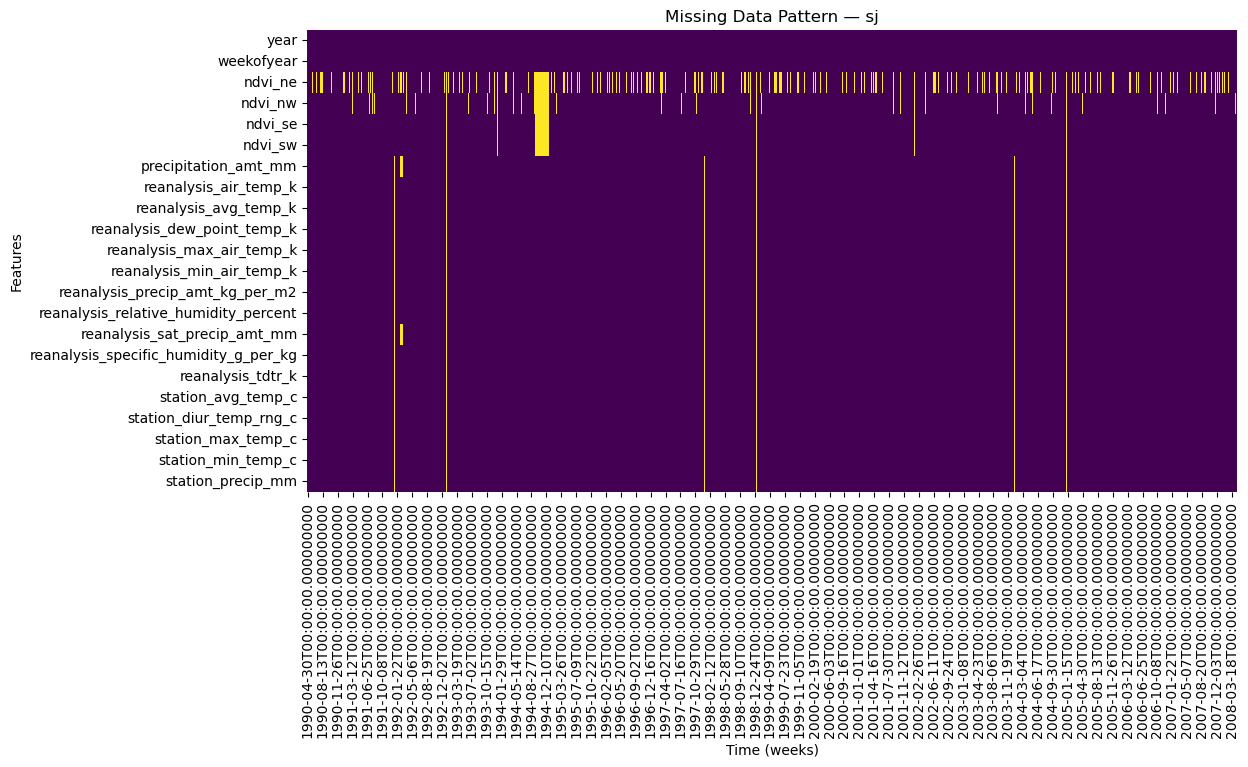

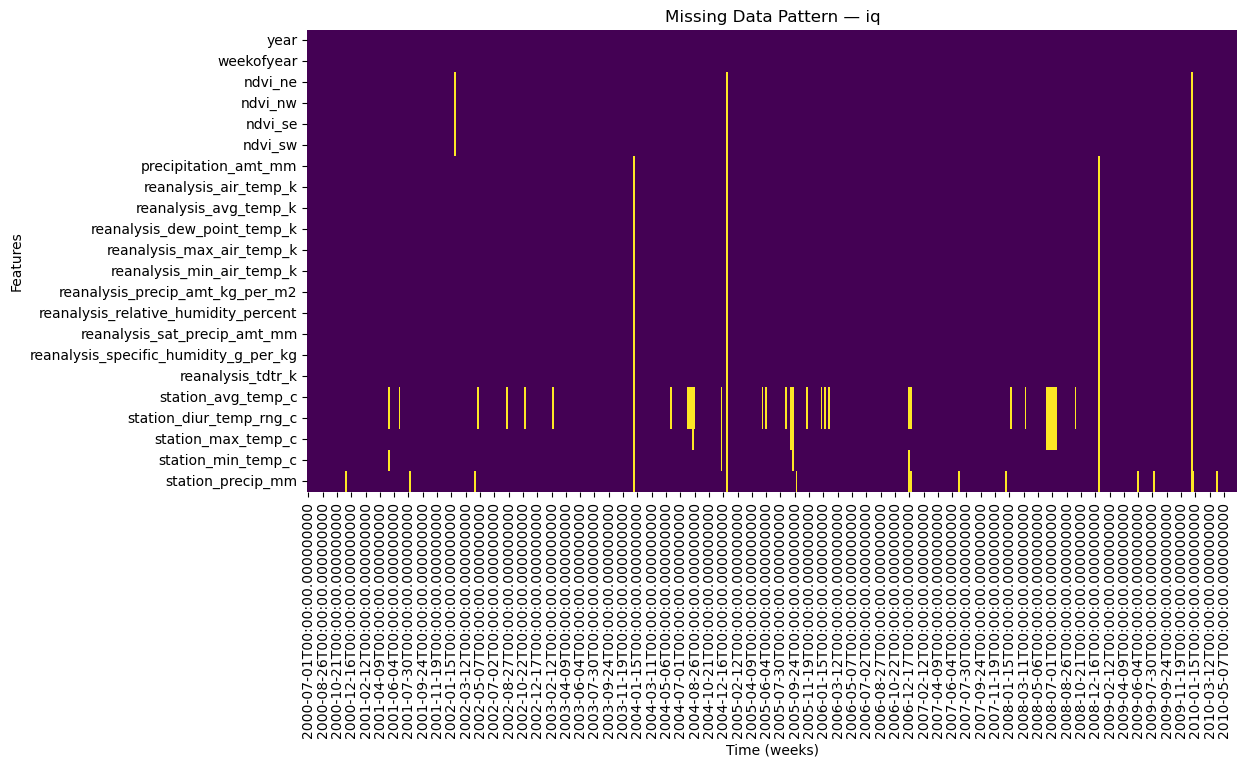

In [10]:
# Subset to avoid too many columns (if needed, select only climate vars)
feature_cols = [c for c in feat_train.columns if c not in ['city','week_start_date','total_cases']]

for city in train_df['city'].unique():
    df_city = (
        train_df.loc[train_df.city==city, ['week_start_date'] + feature_cols]
        .set_index('week_start_date')
        .sort_index()
    )

    plt.figure(figsize=(12,6))
    sns.heatmap(df_city.isna().T, cbar=False, cmap="viridis")
    plt.title(f"Missing Data Pattern — {city}")
    plt.xlabel("Time (weeks)")
    plt.ylabel("Features")
    plt.show()


**Missing Data Patterns**

**San Juan (sj):**
- Most reanalysis features are complete.  
- Noticeable gaps in **NDVI (vegetation indices)**, especially around early/mid 1990s and sporadically later.  
- Some isolated missing points in station-based variables (`station_max_temp_c`, `station_min_temp_c`, `station_precip_mm`).  
- Overall: missingness is sparse and mostly concentrated in NDVI. → Imputation (forward/backfill or interpolation) is feasible.

**Iquitos (iq):**
- Clearer and more frequent missingness compared to San Juan.  
- Many gaps in **station-based climate features** (`station_min_temp_c`, `station_max_temp_c`, `station_precip_mm`).  
- Reanalysis variables are largely complete, except for occasional missing weeks.  
- NDVI again shows gaps, but less extensive than in San Juan.  
- Overall: missingness is clustered in station features, which may reduce their reliability compared to reanalysis features.

---

## <span style="color:blue">Implications for Preprocessing</span>
- **NDVI features:** patchy coverage in both cities; may require imputation or even dropping if too unreliable.  
- **Station features:** more complete in San Juan, less so in Iquitos. → Consider prioritizing reanalysis features for modeling.  
- **Reanalysis features:** nearly complete → safest to rely on as primary covariates.  
- **Rolling/lagged features:** must be careful with missing weeks, since rolling means could propagate NaNs unless missing values are imputed first.

---

✅ **Takeaway:**  
- Missingness is not catastrophic — the series are mostly intact.  
- The main concern is **NDVI and station-based features**, especially in Iquitos.  
- Reanalysis climate features can serve as robust predictors, with interpolation applied to fill occasional gaps.


<a id="eda-features"></a>
### <span style="color:blue">**Feature analysis — distributions (histograms & boxplots):**</span>

We first examine the **marginal distributions** of the features to spot skew, outliers, and city differences.


For every numeric feature, we’ll draw **two panels**: **San Juan (left)** and **Iquitos (right)**. Each panel stacks a **boxplot on top** of a **histogram** sharing the same x-axis, so we see the distribution shape and the five-number summary together.

Total numeric features: 20


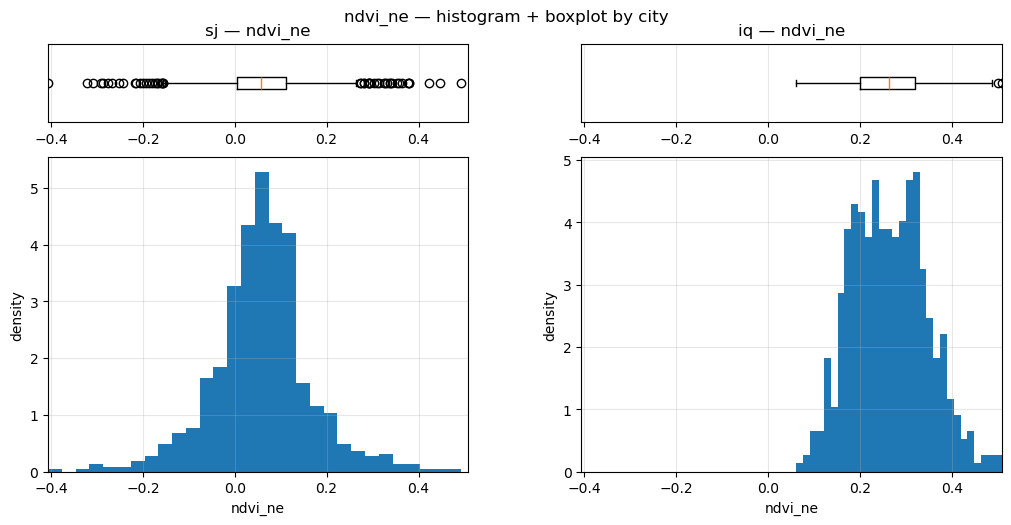

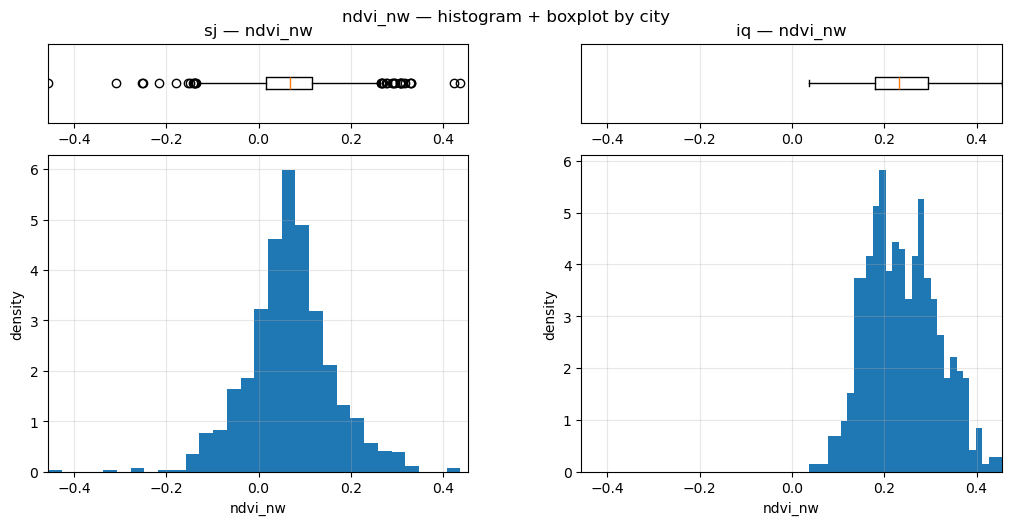

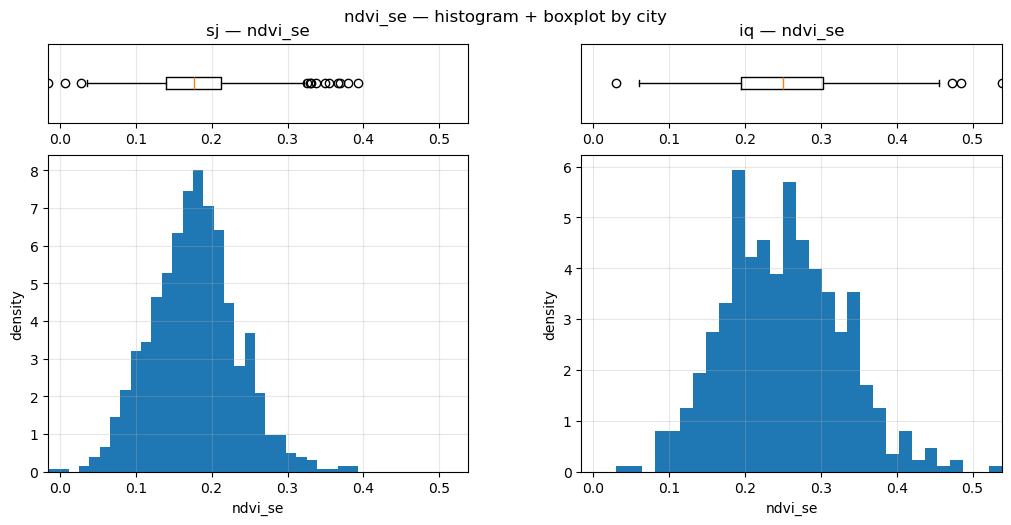

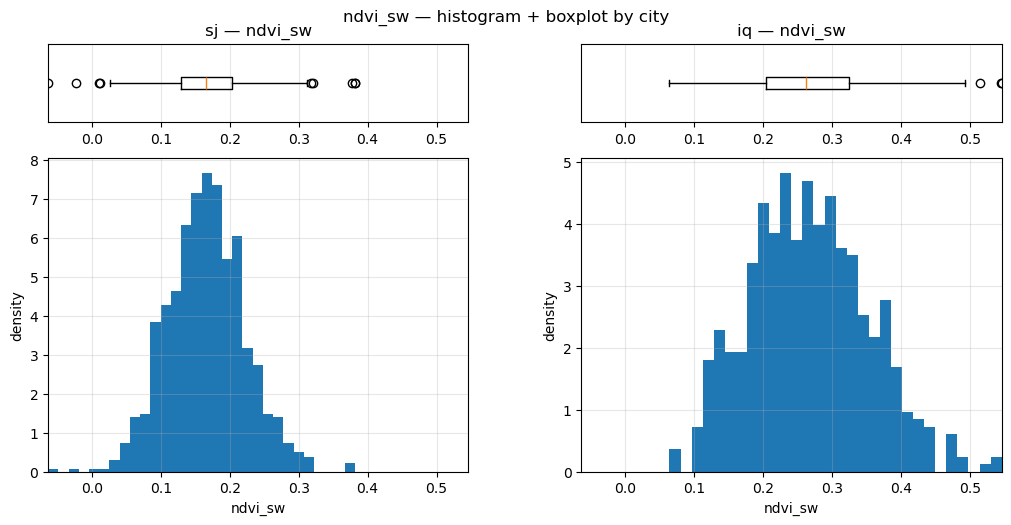

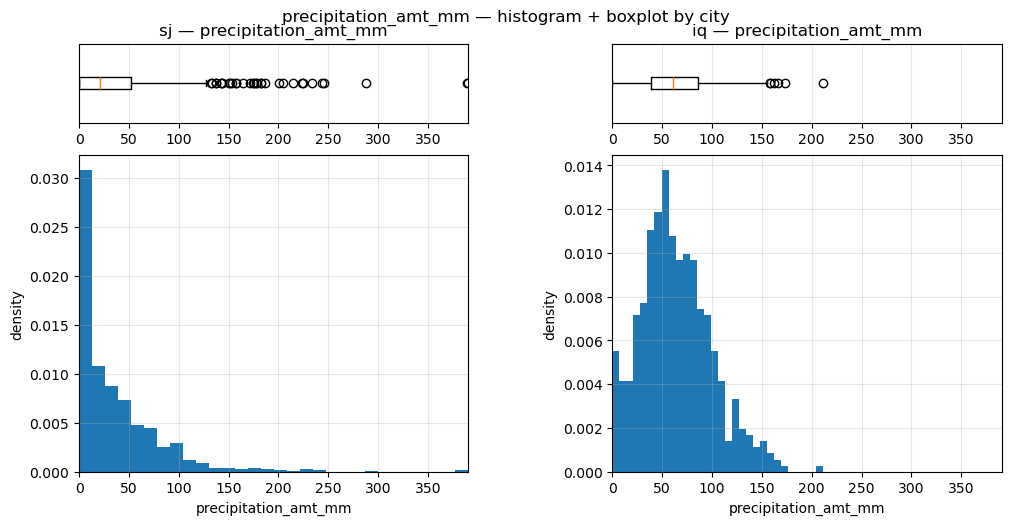

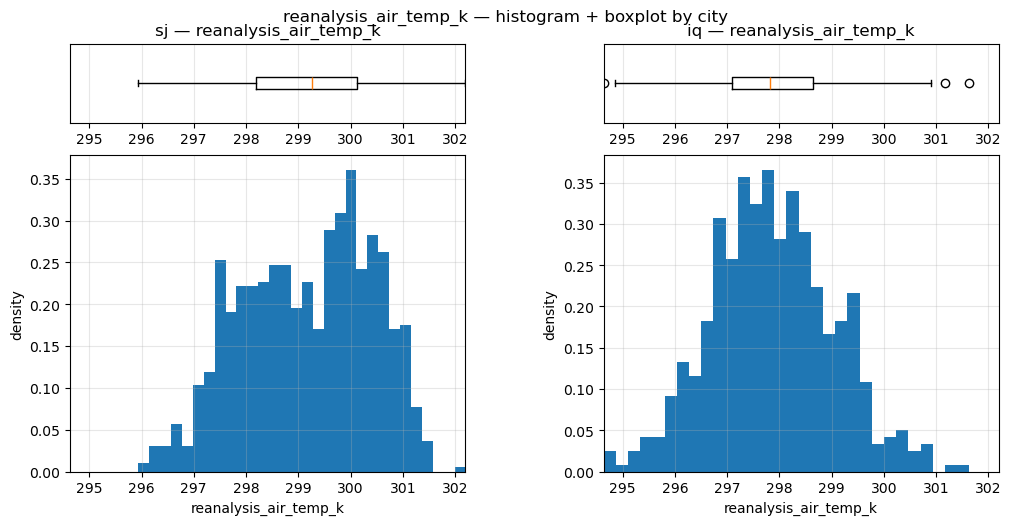

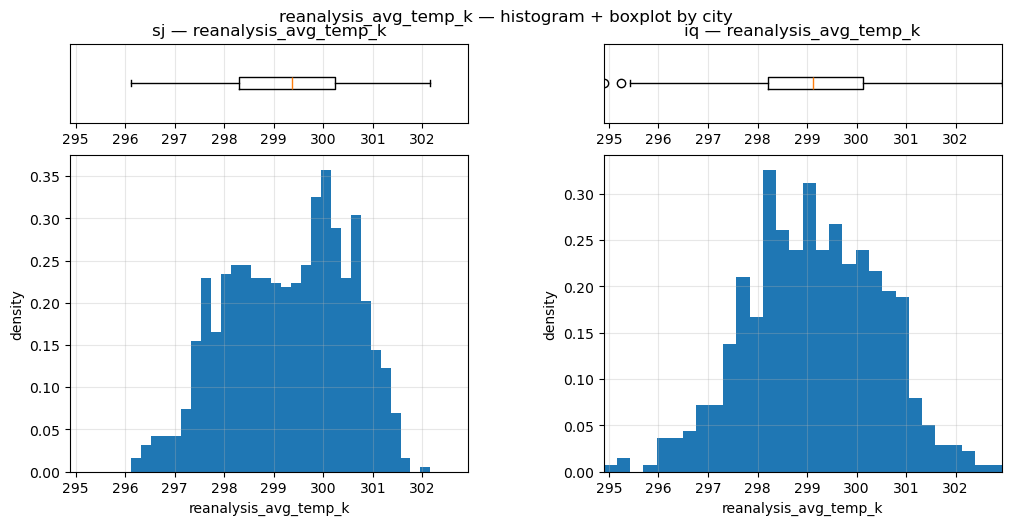

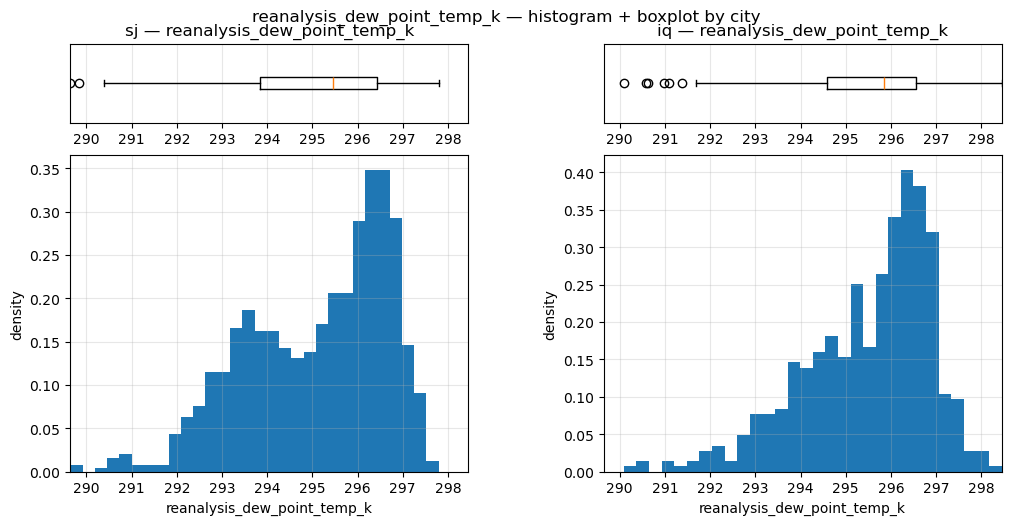

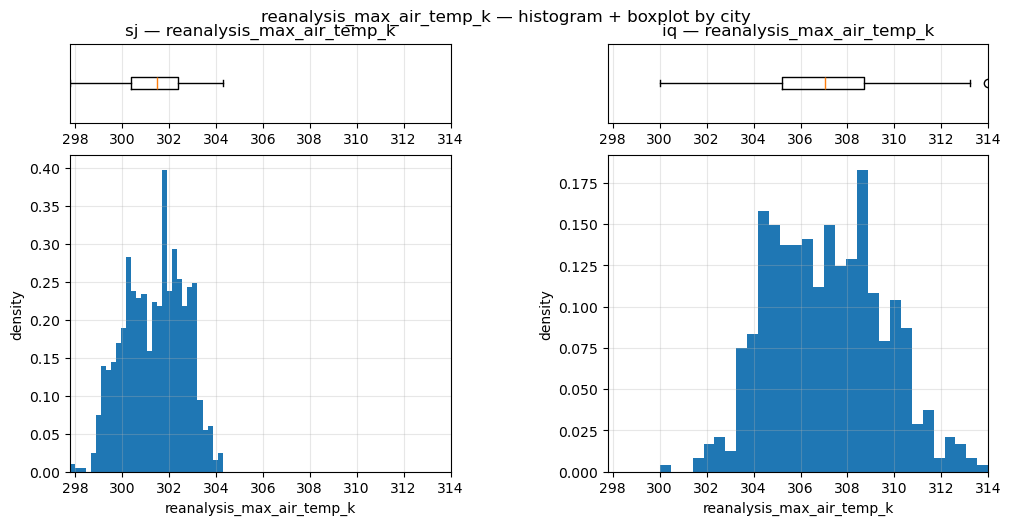

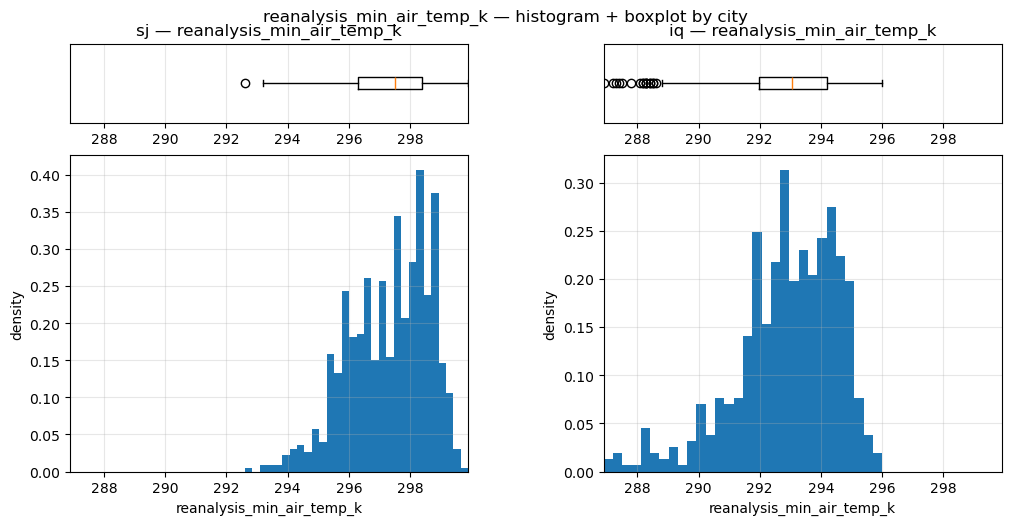

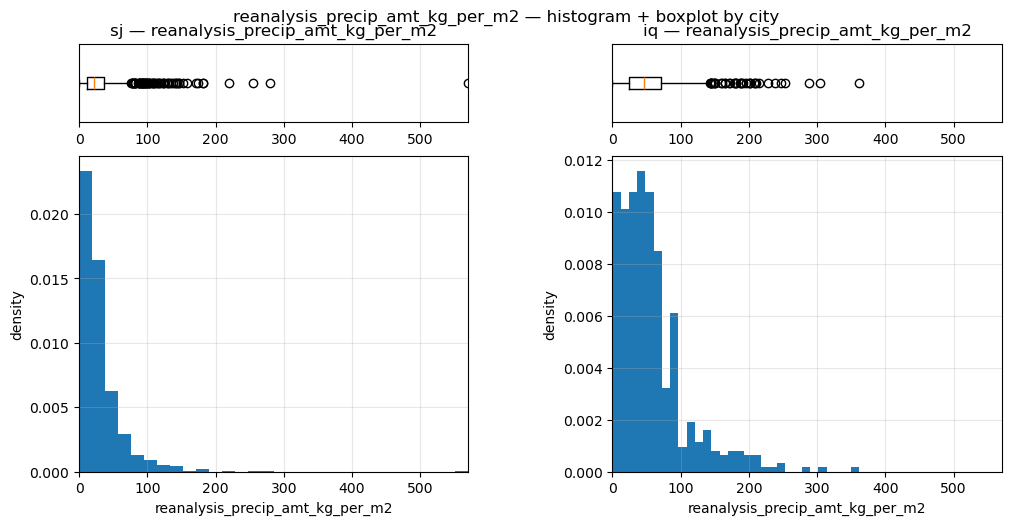

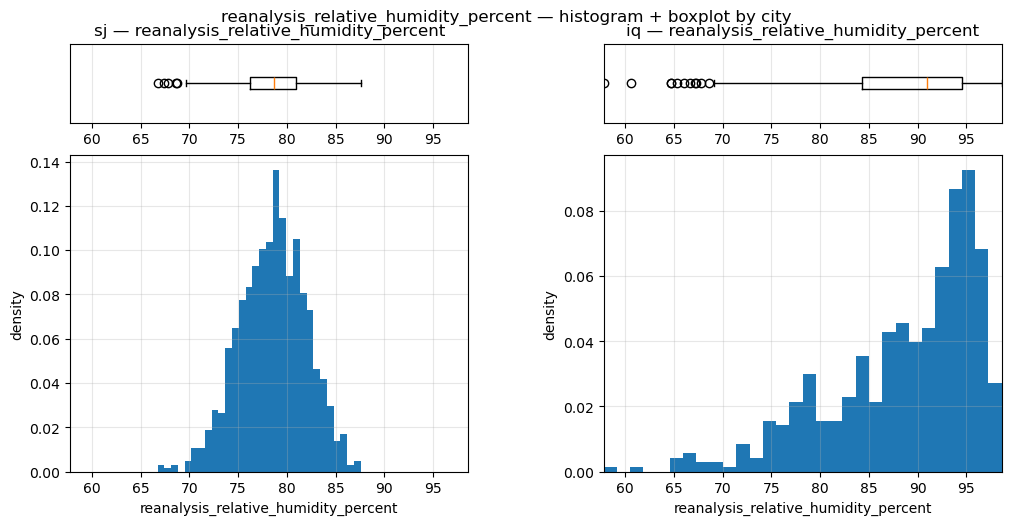

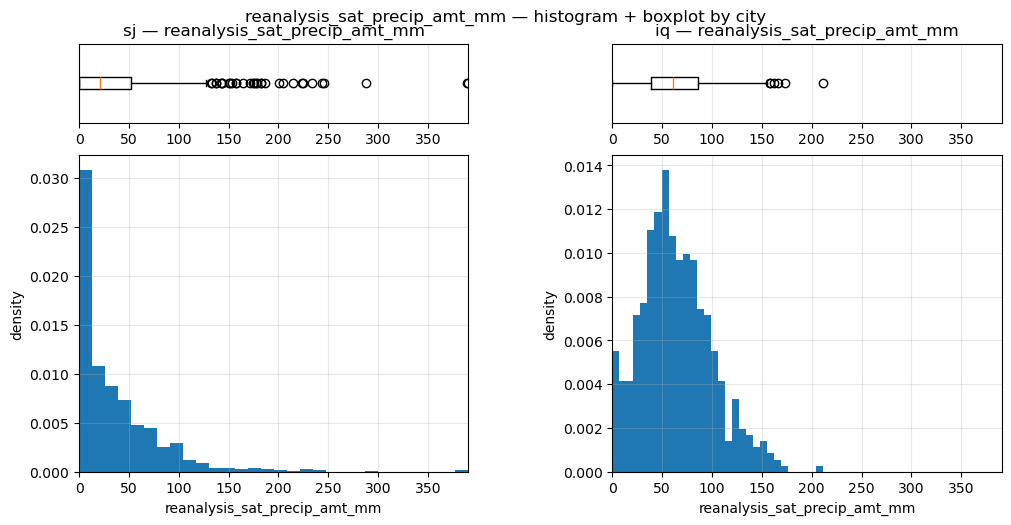

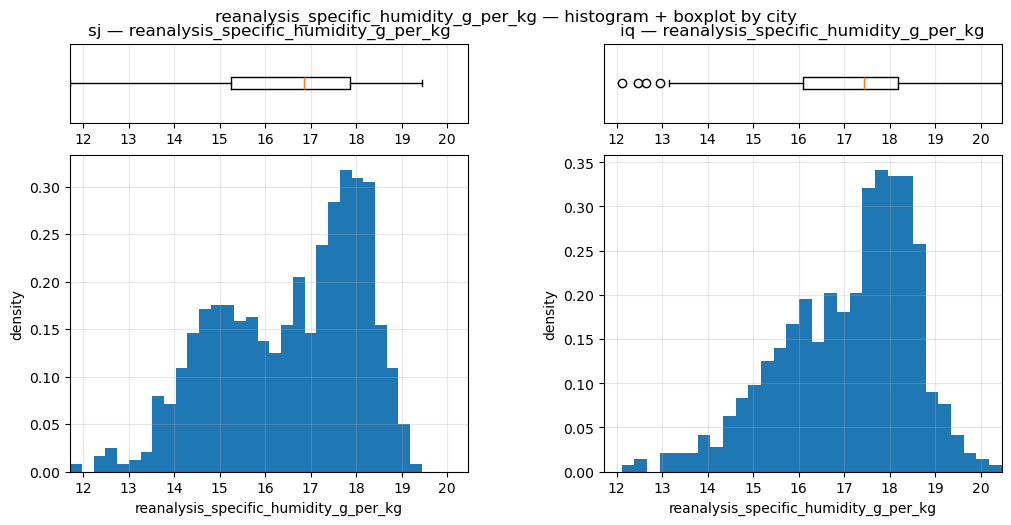

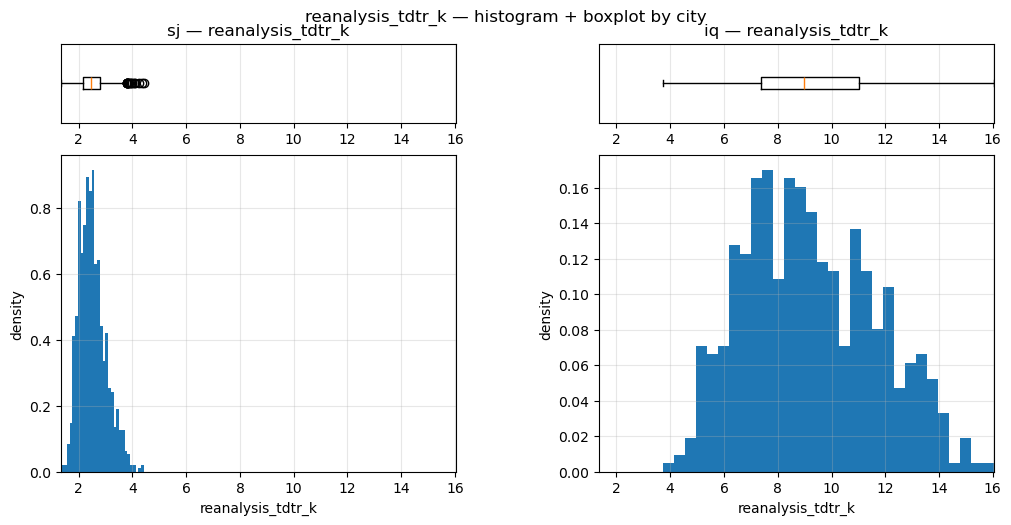

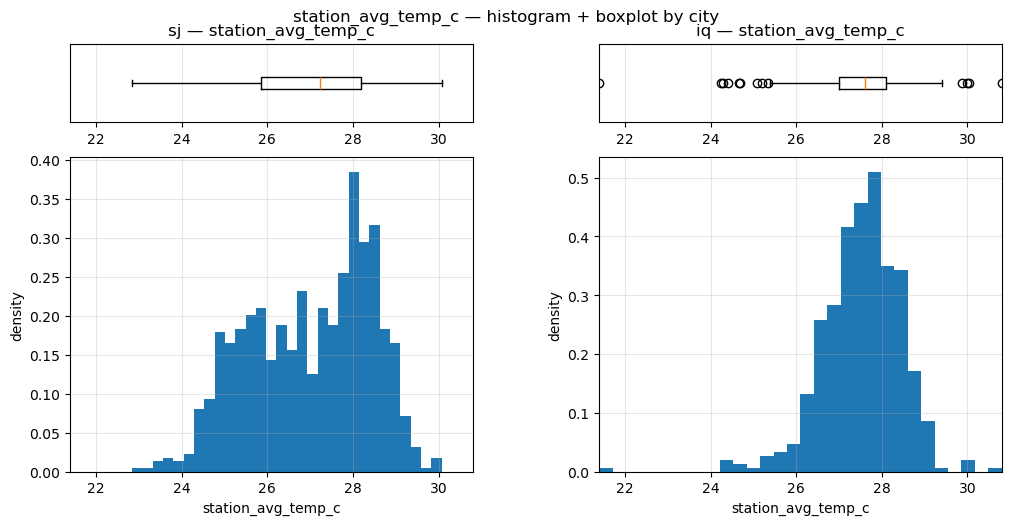

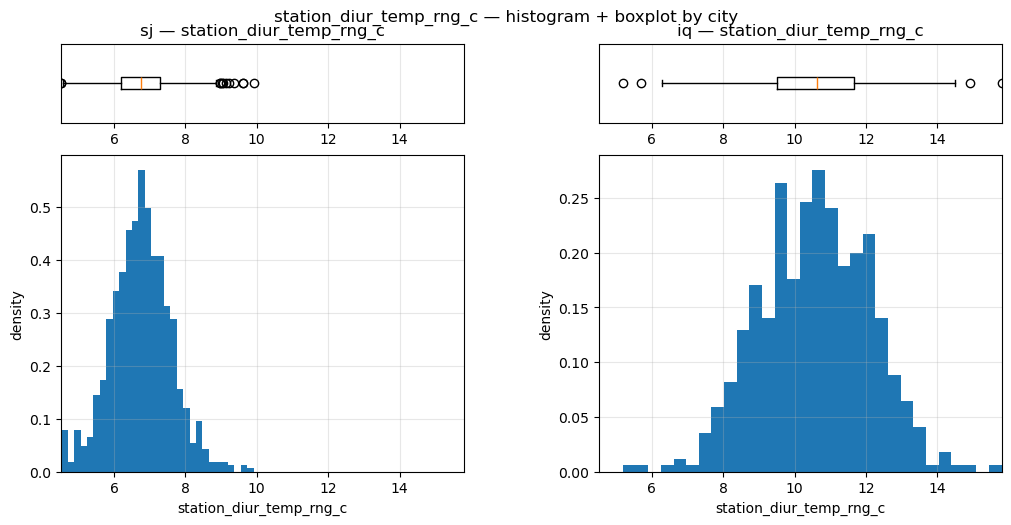

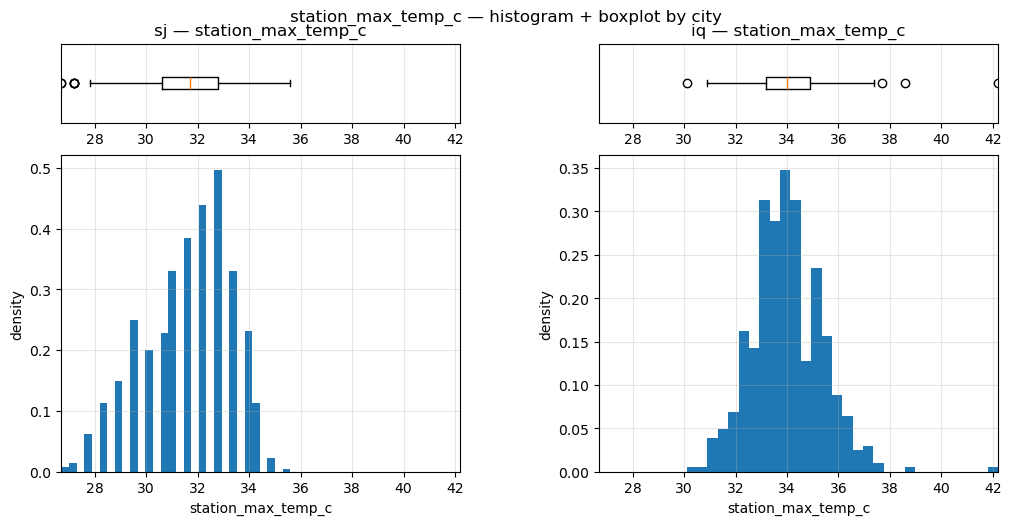

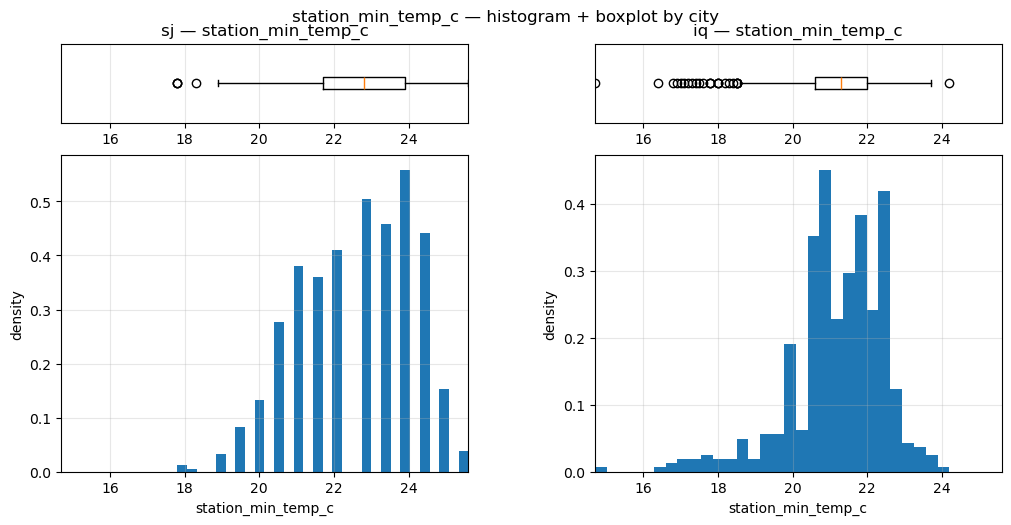

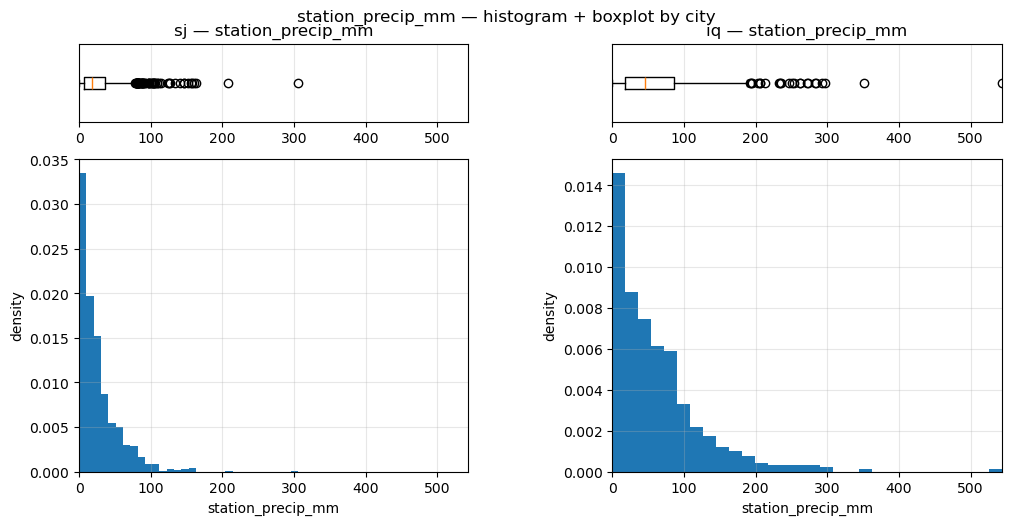

In [11]:
# Histograms + top boxplots for ALL numeric features, left=SJ, right=IQ

# Build the feature list (numeric features only, excluding keys/target)
TIME_KEYS = ["year", "weekofyear"]
NON_FEATURES = set(["city", "week_start_date", "total_cases"] + TIME_KEYS)
all_numeric_cols = feat_train.select_dtypes(include=[np.number]).columns.tolist()
FEATURES_ALL = [c for c in all_numeric_cols if c not in NON_FEATURES]

def plot_hist_box_by_city(df_feat: pd.DataFrame, col: str, cities=("sj","iq"), bins=30):
    """For a given feature col, draw SJ (left) and IQ (right): top=boxplot, bottom=histogram."""
    data_city = {c: df_feat.loc[df_feat["city"]==c, col].dropna().values for c in cities}
    # If both empty, skip
    if all(len(v)==0 for v in data_city.values()):
        print(f"[skip] {col}: no data for selected cities")
        return

    # Common x-limits across cities to align boxplots and histograms
    xs = np.concatenate([v for v in data_city.values() if len(v)>0])
    x_min, x_max = np.nanmin(xs), np.nanmax(xs)
    if not np.isfinite(x_min) or not np.isfinite(x_max) or x_min==x_max:
        # fallback if degenerate
        x_min, x_max = (x_min-1, x_max+1) if np.isfinite(x_min) else (-1, 1)

    fig = plt.figure(figsize=(10, 5), constrained_layout=True)
    gs = fig.add_gridspec(nrows=2, ncols=2, height_ratios=[1, 4], wspace=0.15)

    for j, city in enumerate(cities):
        arr = data_city[city]
        # BOX (top row)
        ax_box = fig.add_subplot(gs[0, j])
        if len(arr):
            ax_box.boxplot(arr, vert=False, showfliers=True)
        ax_box.set_xlim(x_min, x_max)
        ax_box.set_yticks([])
        ax_box.set_xlabel("")
        ax_box.set_title(f"{city} — {col}")
        ax_box.grid(True, axis="x", alpha=0.3)

        # HIST (bottom row)
        ax_hist = fig.add_subplot(gs[1, j])
        if len(arr):
            ax_hist.hist(arr, bins=bins, density=True)
        ax_hist.set_xlim(x_min, x_max)
        ax_hist.set_xlabel(col)
        ax_hist.set_ylabel("density")
        ax_hist.grid(True, alpha=0.3)

    fig.suptitle(f"{col} — histogram + boxplot by city", y=1.02, fontsize=12)
    plt.show()

print("Total numeric features:", len(FEATURES_ALL))
for feature in FEATURES_ALL:
    plot_hist_box_by_city(feat_train, feature)


**Histograms & boxplots — interpretation:**

**City contrasts (location & spread)**
- Many variables show **systematic shifts between cities**.
  - **NDVI**: distributions center **higher in Iquitos (iq)** (≈0.20–0.35+) than **San Juan (sj)** (≈0.05–0.25), with fatter right tails in iq.
  - **Diurnal temperature range** (`station_diur_temp_rng_c`, `reanalysis_tdtr_k`): **much larger in iq**; sj is tightly clustered at lower values.
  - **Station temperatures**: **iq** tends to have **higher max** temps and **lower min** temps than **sj** → wider station-range in iq.
  - **Relative humidity**: iq’s distribution is shifted toward **higher values** with right-skew; sj is centered lower and more symmetric.
  - **Reanalysis temps** (air/avg/min/max in K): both cities are compact and near-Gaussian, but **centers differ slightly**.

**Skewness & zero-inflation**
- **Precipitation** variables (`precipitation_amt_mm`, `reanalysis_precip_amt_kg_per_m2`, `station_precip_mm`) are **heavily right-skewed** in both cities with **many zeros** and numerous high-value outliers (seen in boxplots).

**Outliers**
- Most extreme points appear in **precipitation** (many high-end outliers, especially in sj’s station and reanalysis precip).
- Occasional NDVI extremes near the lower bound (negative values) are visible, but the bulk remains within typical ranges.

**Distribution shape & redundancy hints**
- Temperature families (min/avg/max/air/dew point) are **unimodal and narrow**, suggesting **strong redundancy** within the family.
- Humidity measures are moderately spread; iq leans higher.

---

**Conclusions we can draw *now* (from these plots alone)**
- Include **city effects** in modeling (at minimum a `city` indicator); pooling without accounting for city differences will blur signals.
- Handle **precipitation** with care: consider **transformations** (e.g., `log1p`) and a **wet/dry indicator** to address zero-inflation and long tails.
- Expect **redundancy** among temperature variables; regularization or selective inclusion can help linear models (trees will cope better).
- Watch **outliers**: clipping/winsorizing **precip** (and possibly rare NDVI extremes) may stabilize linear models.
- If standardizing features for linear models, prefer **city-wise scaling**, given the clear location shifts between sj and iq.

*Note:* Correlations, seasonality, and lag structure are **not** inferred here and will be analyzed in subsequent subsections.


<a id="eda-feature-outliers"></a>

### <span style="color:blue">EDA — Feature Outlier Detection</span>

We already inspected feature distributions with histograms and boxplots.  
Here, we apply a systematic **IQR rule** per city and feature:

- Compute Q1 (25th percentile) and Q3 (75th percentile).  
- Define IQR = Q3 − Q1.  
- Mark values as outliers if they are **below Q1 − 1.5·IQR** or **above Q3 + 1.5·IQR**.  

This helps us **detect** extreme values that may be true rare events (signal) or noise (e.g., sensor glitches).  
⚠️ At this stage we **do not remove or cap** them — we only quantify and visualize.  
Treatment decisions will be made later in **Feature Engineering**.


In [12]:
import pandas as pd

# Identify candidate features (exclude target + meta)
feature_cols = [c for c in feat_train.columns 
                if c not in ['city', 'week_start_date', 'total_cases']]

outlier_summary = []

for city, grp in feat_train.groupby('city'):
    for col in feature_cols:
        q1 = grp[col].quantile(0.25)
        q3 = grp[col].quantile(0.75)
        iqr = q3 - q1
        lower = q1 - 1.5 * iqr
        upper = q3 + 1.5 * iqr
        mask = (grp[col] < lower) | (grp[col] > upper)
        n_out = mask.sum()
        pct_out = 100 * n_out / len(grp)
        if n_out > 0:
            outlier_summary.append({
                'city': city,
                'feature': col,
                'n_outliers': n_out,
                'pct_outliers': round(pct_out, 2),
                'lower_thr': round(lower, 3),
                'upper_thr': round(upper, 3)
            })

outlier_df = pd.DataFrame(outlier_summary).sort_values(
    ['city', 'pct_outliers'], ascending=[True, False]
)

display(outlier_df.head(20))  # show top 20 for inspection



city                                feature  n_outliers  pct_outliers  \
9    iq        reanalysis_precip_amt_kg_per_m2          38          7.31   
16   iq                     station_min_temp_c          25          4.81   
17   iq                      station_precip_mm          23          4.42   
8    iq              reanalysis_min_air_temp_k          17          3.27   
13   iq                     station_avg_temp_c          13          2.50   
10   iq   reanalysis_relative_humidity_percent          11          2.12   
3    iq                   precipitation_amt_mm           6          1.15   
6    iq            reanalysis_dew_point_temp_k           6          1.15   
11   iq           reanalysis_sat_precip_amt_mm           6          1.15   
1    iq                                ndvi_se           4          0.77   
12   iq  reanalysis_specific_humidity_g_per_kg           4          0.77   
14   iq                station_diur_temp_rng_c           4          0.77   
15   iq                     station_max_temp_c           4          0.77   
2    iq                                ndvi_sw           3          0.58   
4    iq                  reanalysis_air_temp_k           3          0.58   
0    iq                                ndvi_ne           2          0.38   
5    iq                  reanalysis_avg_temp_k           2          0.38   
7    iq              reanalysis_max_air_temp_k           1          0.19   
25   sj        reanalysis_precip_amt_kg_per_m2          65          6.94   
32   sj                      station_precip_mm          58          6.20   

    lower_thr  upper_thr  
9     -46.446    141.584  
16     18.500     24.100  
17    -85.925    189.075  
8     288.638    297.537  
13     25.350     29.750  
10     68.892    109.967  
3     -30.874    155.736  
6     291.662    299.481  
11    -30.874    155.736  
1       0.033      0.464  
12     12.987     21.297  
14      6.267     14.888  
15     30.650     37.450  
2       0.023      0.507  
4     294.757    300.984  
0       0.020      0.500  
5     295.369    302.976  
7     299.950    313.950  
25    -28.437     76.262  
32    -36.113     78.388

To better understand the nature of detected outliers, we overlay them on time-series plots for each feature.  
- **Blue line:** full feature time series.  
- **Red dots:** values flagged as outliers by the IQR rule.  

This helps distinguish between **true rare events** (e.g., sudden rainfall spikes aligned with outbreaks) versus **spurious sensor noise**.

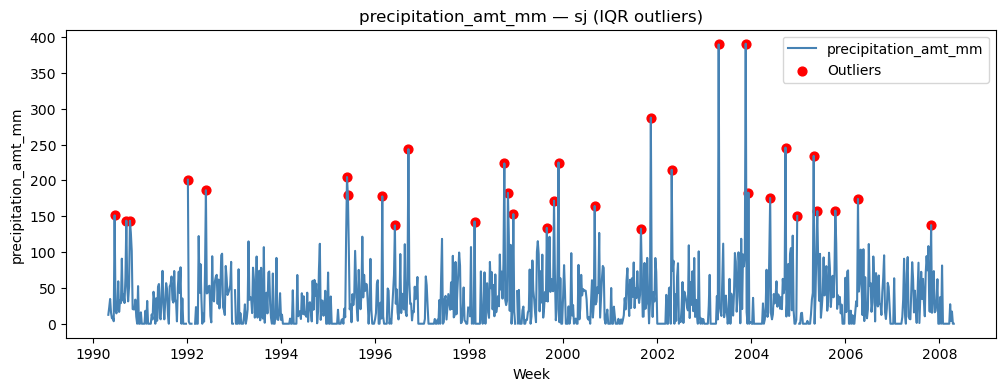

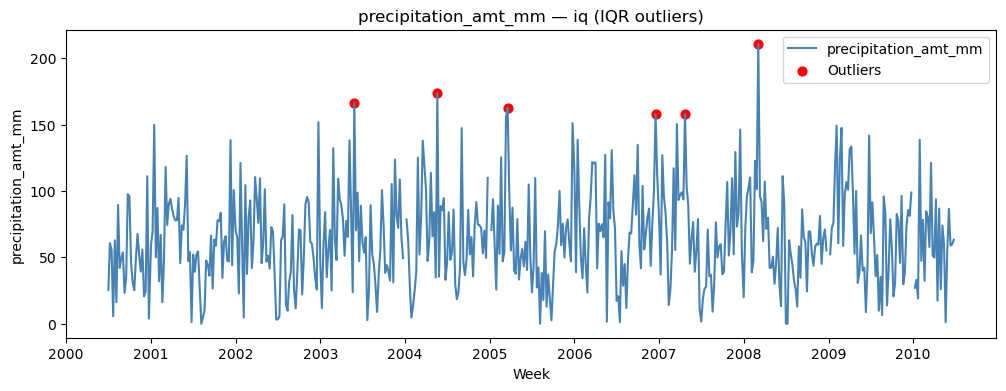

In [13]:
def plot_feature_outliers(df, feature, city):
    """Plot a single feature over time with outliers highlighted."""
    sub = df[df['city'] == city].copy()
    q1 = sub[feature].quantile(0.25)
    q3 = sub[feature].quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    mask = (sub[feature] < lower) | (sub[feature] > upper)

    plt.figure(figsize=(12, 4))
    plt.plot(sub['week_start_date'], sub[feature], color='steelblue', label=feature)
    plt.scatter(sub.loc[mask, 'week_start_date'], sub.loc[mask, feature],
                color='red', s=40, label='Outliers')
    plt.title(f"{feature} — {city} (IQR outliers)")
    plt.xlabel("Week")
    plt.ylabel(feature)
    plt.legend()
    plt.show()

# Example usage: visualize one feature per city
plot_feature_outliers(feat_train, feature='precipitation_amt_mm', city='sj')
plot_feature_outliers(feat_train, feature='precipitation_amt_mm', city='iq')


<a id="eda-features-corr"></a>
### <span style="color:blue">**Feature analysis — correlations (features vs. features):**</span>

We examine **linear correlations** among numeric **features only** (no target yet) to spot redundancy and families that move together.  
Notes: we **exclude time keys** (`year`, `weekofyear`) and compute pairwise correlations using non-missing rows. We show a **global** heatmap (both cities together) and **per-city** heatmaps to reveal city-specific patterns. A table of the **top correlated pairs** helps identify candidates for pruning or regularization later.


In [14]:
# Build the feature list (numeric features only, excluding keys/target)

TIME_KEYS = ["year", "weekofyear"]
NON_FEATURES = set(["city", "week_start_date", "total_cases"] + TIME_KEYS)

num_cols = feat_train.select_dtypes(include=[np.number]).columns.tolist()
FEATURES_ONLY = [c for c in num_cols if c not in NON_FEATURES]

print("Number of numeric features:", len(FEATURES_ONLY))


Number of numeric features: 20


In [15]:
# Utility: plot a correlation heatmap with matplotlib (no seaborn)

def plot_corr_heatmap(corr_df, title):
    cols = corr_df.columns.tolist()
    fig, ax = plt.subplots(figsize=(10, 8))
    im = ax.imshow(corr_df.values, vmin=-1, vmax=1)
    ax.set_xticks(np.arange(len(cols))); ax.set_yticks(np.arange(len(cols)))
    ax.set_xticklabels(cols, rotation=90, fontsize=8)
    ax.set_yticklabels(cols, fontsize=8)
    cbar = plt.colorbar(im, ax=ax); cbar.set_label("Pearson r")
    ax.set_title(title)
    plt.tight_layout()
    plt.show()

def top_corr_pairs(corr_df, k=20, min_abs=None):
    """Return top |corr| pairs from an NxN matrix (upper triangle, no diagonal)."""
    cols = corr_df.columns
    vals = []
    for i in range(len(cols)):
        for j in range(i+1, len(cols)):
            r = corr_df.iloc[i, j]
            vals.append((cols[i], cols[j], r, abs(r)))
    out = pd.DataFrame(vals, columns=["feat_1","feat_2","corr","abs_corr"]).sort_values("abs_corr", ascending=False)
    if min_abs is not None:
        out = out[out["abs_corr"] >= min_abs]
    return out.head(k)


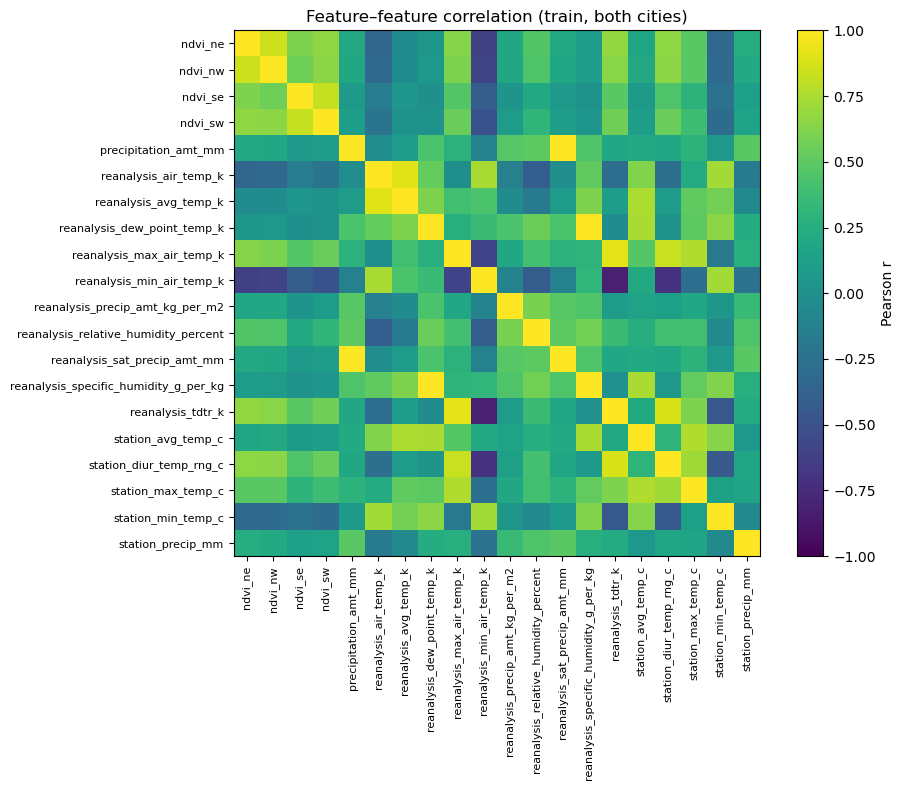

Top correlated feature pairs (global):


feat_1  \
77                    precipitation_amt_mm   
117            reanalysis_dew_point_temp_k   
129              reanalysis_max_air_temp_k   
85                   reanalysis_air_temp_k   
176                      reanalysis_tdtr_k   
0                                  ndvi_ne   
131              reanalysis_max_air_temp_k   
37                                 ndvi_se   
139              reanalysis_min_air_temp_k   
181                     station_avg_temp_c   
132              reanalysis_max_air_temp_k   
107                  reanalysis_avg_temp_k   
170  reanalysis_specific_humidity_g_per_kg   
119            reanalysis_dew_point_temp_k   
88                   reanalysis_air_temp_k   
143              reanalysis_min_air_temp_k   
97                   reanalysis_air_temp_k   
141              reanalysis_min_air_temp_k   
184                station_diur_temp_rng_c   
13                                 ndvi_ne   

                                    feat_2      corr  abs_corr  
77            reanalysis_sat_precip_amt_mm  1.000000  1.000000  
117  reanalysis_specific_humidity_g_per_kg  0.997051  0.997051  
129                      reanalysis_tdtr_k  0.918578  0.918578  
85                   reanalysis_avg_temp_k  0.901777  0.901777  
176                station_diur_temp_rng_c  0.881176  0.881176  
0                                  ndvi_nw  0.850902  0.850902  
131                station_diur_temp_rng_c  0.834263  0.834263  
37                                 ndvi_sw  0.820924  0.820924  
139                      reanalysis_tdtr_k -0.815511  0.815511  
181                     station_max_temp_c  0.764576  0.764576  
132                     station_max_temp_c  0.763446  0.763446  
107                     station_avg_temp_c  0.751330  0.751330  
170                     station_avg_temp_c  0.747809  0.747809  
119                     station_avg_temp_c  0.743506  0.743506  
88               reanalysis_min_air_temp_k  0.736765  0.736765  
143                     station_min_temp_c  0.720701  0.720701  
97                      station_min_temp_c  0.719612  0.719612  
141                station_diur_temp_rng_c -0.715676  0.715676  
184                     station_max_temp_c  0.715217  0.715217  
13                       reanalysis_tdtr_k  0.673935  0.673935

In [16]:
# 1) Global (both cities) feature–feature correlations
corr_all = feat_train[FEATURES_ONLY].corr(method="pearson")
plot_corr_heatmap(corr_all, "Feature–feature correlation (train, both cities)")

print("Top correlated feature pairs (global):")
display(top_corr_pairs(corr_all, k=20))

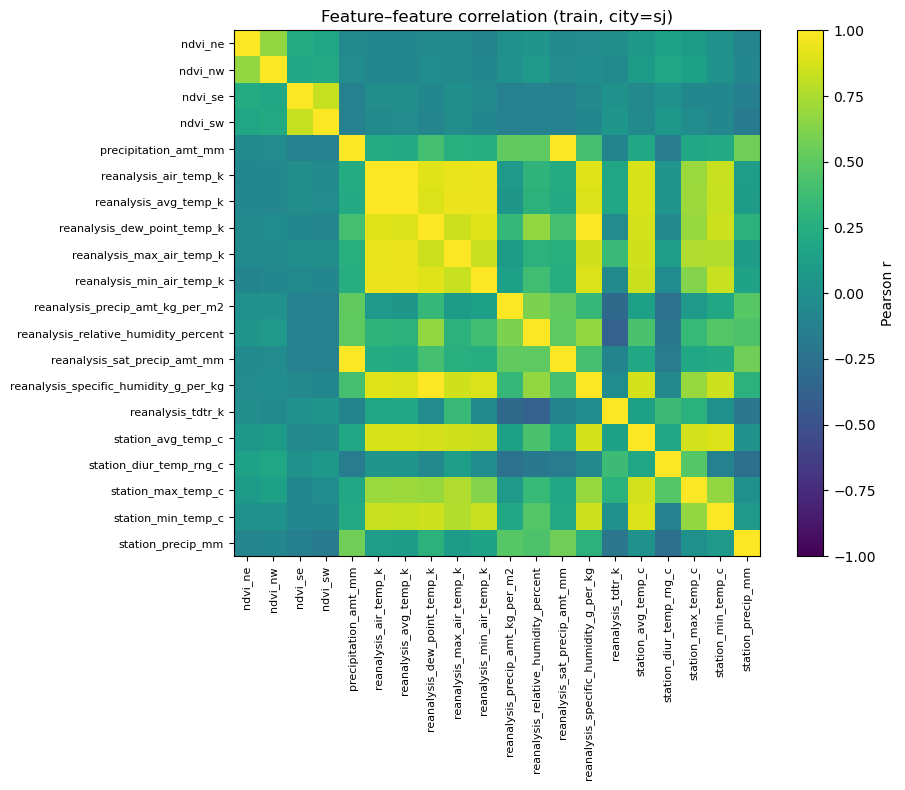

Top correlated pairs — city=sj:


feat_1                                 feat_2  \
77          precipitation_amt_mm           reanalysis_sat_precip_amt_mm   
117  reanalysis_dew_point_temp_k  reanalysis_specific_humidity_g_per_kg   
85         reanalysis_air_temp_k                  reanalysis_avg_temp_k   
88         reanalysis_air_temp_k              reanalysis_min_air_temp_k   
101        reanalysis_avg_temp_k              reanalysis_min_air_temp_k   
100        reanalysis_avg_temp_k              reanalysis_max_air_temp_k   
87         reanalysis_air_temp_k              reanalysis_max_air_temp_k   
92         reanalysis_air_temp_k  reanalysis_specific_humidity_g_per_kg   
86         reanalysis_air_temp_k            reanalysis_dew_point_temp_k   
113  reanalysis_dew_point_temp_k              reanalysis_min_air_temp_k   
182           station_avg_temp_c                     station_min_temp_c   
138    reanalysis_min_air_temp_k  reanalysis_specific_humidity_g_per_kg   
105        reanalysis_avg_temp_k  reanalysis_specific_humidity_g_per_kg   
99         reanalysis_avg_temp_k            reanalysis_dew_point_temp_k   
94         reanalysis_air_temp_k                     station_avg_temp_c   

         corr  abs_corr  
77   1.000000  1.000000  
117  0.998532  0.998532  
85   0.997495  0.997495  
88   0.942254  0.942254  
101  0.939120  0.939120  
100  0.938952  0.938952  
87   0.935089  0.935089  
92   0.904819  0.904819  
86   0.903287  0.903287  
113  0.898814  0.898814  
182  0.898393  0.898393  
138  0.896218  0.896218  
105  0.896178  0.896178  
99   0.895123  0.895123  
94   0.880931  0.880931

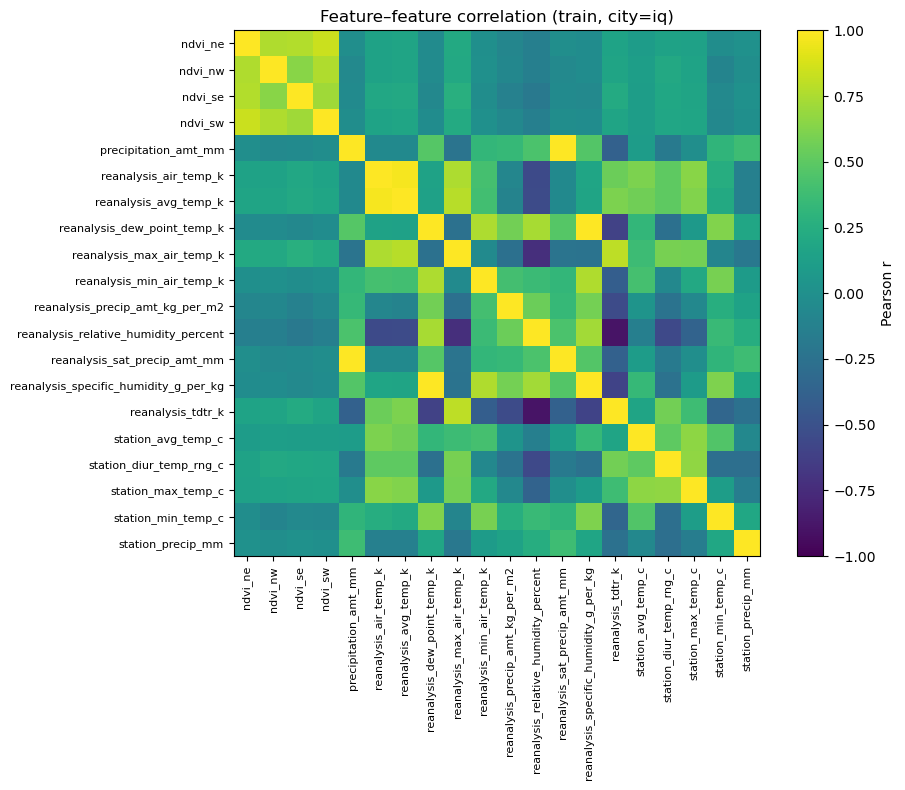

Top correlated pairs — city=iq:


feat_1  \
77                   precipitation_amt_mm   
117           reanalysis_dew_point_temp_k   
85                  reanalysis_air_temp_k   
156  reanalysis_relative_humidity_percent   
2                                 ndvi_ne   
129             reanalysis_max_air_temp_k   
100                 reanalysis_avg_temp_k   
1                                 ndvi_ne   
20                                ndvi_nw   
0                                 ndvi_ne   
138             reanalysis_min_air_temp_k   
113           reanalysis_dew_point_temp_k   
87                  reanalysis_air_temp_k   
115           reanalysis_dew_point_temp_k   
126             reanalysis_max_air_temp_k   

                                    feat_2      corr  abs_corr  
77            reanalysis_sat_precip_amt_mm  1.000000  1.000000  
117  reanalysis_specific_humidity_g_per_kg  0.997775  0.997775  
85                   reanalysis_avg_temp_k  0.973319  0.973319  
156                      reanalysis_tdtr_k -0.896491  0.896491  
2                                  ndvi_sw  0.842784  0.842784  
129                      reanalysis_tdtr_k  0.799293  0.799293  
100              reanalysis_max_air_temp_k  0.783955  0.783955  
1                                  ndvi_se  0.767745  0.767745  
20                                 ndvi_sw  0.764829  0.764829  
0                                  ndvi_nw  0.764407  0.764407  
138  reanalysis_specific_humidity_g_per_kg  0.758604  0.758604  
113              reanalysis_min_air_temp_k  0.754751  0.754751  
87               reanalysis_max_air_temp_k  0.752356  0.752356  
115   reanalysis_relative_humidity_percent  0.741762  0.741762  
126   reanalysis_relative_humidity_percent -0.726586  0.726586

In [17]:
# 2) Per-city correlations
for city in ["sj", "iq"]:
    subset = feat_train.loc[feat_train["city"] == city, FEATURES_ONLY]
    corr_city = subset.corr(method="pearson")
    plot_corr_heatmap(corr_city, f"Feature–feature correlation (train, city={city})")
    print(f"Top correlated pairs — city={city}:")
    display(top_corr_pairs(corr_city, k=15))


**Feature analysis — correlations: interpretation (features vs. features)**

**Strong redundancy (|r| ≥ 0.9) — clear duplicates/families**
- **Precipitation (satellite):** `precipitation_amt_mm` ↔ `reanalysis_sat_precip_amt_mm` ≈ **1.00** in **both** cities → effectively duplicates; keep **one**.
- **Temperature level (reanalysis):**
  - `reanalysis_air_temp_k` ↔ `reanalysis_avg_temp_k` ≈ **0.90–0.97**.
  - `reanalysis_min_air_temp_k`/`max_air_temp_k` each correlate strongly with the **avg/air** temp (≈ **0.89–0.94**).
- **Moisture state:** `reanalysis_dew_point_temp_k` ↔ `reanalysis_specific_humidity_g_per_kg` ≈ **0.99**.
- **NDVI quadrants:** within-quadrant pairs are high (e.g., `ndvi_ne` ↔ `ndvi_nw` ≈ **0.85**, `ndvi_se` ↔ `ndvi_sw` ≈ **0.82**).

**Moderate-to-strong structure (0.7 ≤ |r| < 0.9) — related but not identical**
- **Thermal range vs. level:** `reanalysis_tdtr_k` (diurnal range) relates to level measures:
  - Positive with `reanalysis_max_air_temp_k` (≈ **0.80** global).
  - Negative with `reanalysis_min_air_temp_k` (≈ **−0.82** global).
- **Station vs. reanalysis temps:** station averages/max/min correlate with reanalysis temps (**0.72–0.76**), i.e., same signal measured differently.

**City-specific notes**
- In **sj**, temp–temp correlations are **very high** (avg/air/min/max often **> 0.93**), reinforcing redundancy.
- In **iq**, `reanalysis_relative_humidity_percent` ↔ `reanalysis_tdtr_k` is **strongly negative** (≈ **−0.90**), stronger than in sj — local climate dynamics differ.
- The perfect precip duplicate holds in **both** cities.

**What we can safely conclude from these correlation plots**
- Several columns are **near-duplicates**; carrying all of them adds little information and increases multicollinearity.
- Reasonable **minimal representatives** (for linear baselines) could be:
  - **Precipitation:** keep **one** of {`precipitation_amt_mm`, `reanalysis_sat_precip_amt_mm`}; consider keeping **station_precip_mm** as an independent source.
  - **Temperature level:** keep **one** level metric (e.g., `reanalysis_avg_temp_k` **or** `reanalysis_air_temp_k`) **plus** a **range** metric (`reanalysis_tdtr_k` or `station_diur_temp_rng_c`).
  - **Moisture:** keep **one** of {`reanalysis_dew_point_temp_k`, `reanalysis_specific_humidity_g_per_kg`}.
  - **NDVI:** compress quadrants (e.g., mean or first PC) or keep **one per hemisphere** if needed.
- For **tree ensembles**, redundancy is less harmful, but it can **dilute feature importance**; still reasonable to prune exact duplicates (precip pair).

*Scope note:* These conclusions are based solely on **feature–feature** correlations (no target). We’ll assess **feature–target** relationships and **seasonality** in subsequent subsections.


<a id="eda-features-seasonality"></a>
### <span style="color:blue">**Feature analysis — seasonality (features only):**</span>

We examine **annual cycles** of every numeric **feature** by averaging values over `weekofyear` for each **city**.  
Below we (1) plot per-feature seasonal profiles (sj vs iq), and (2) compute a compact **seasonality summary** per feature & city (peak week, trough week, amplitude, relative amplitude).


In [18]:
# Build the feature list (numeric features only, excluding keys/target)

TIME_KEYS = ["year", "weekofyear"]
NON_FEATURES = set(["city", "week_start_date", "total_cases"] + TIME_KEYS)
all_numeric_cols = feat_train.select_dtypes(include=[np.number]).columns.tolist()
FEATURES_ALL = [c for c in all_numeric_cols if c not in NON_FEATURES]

print("Total numeric features:", len(FEATURES_ALL))


Total numeric features: 20


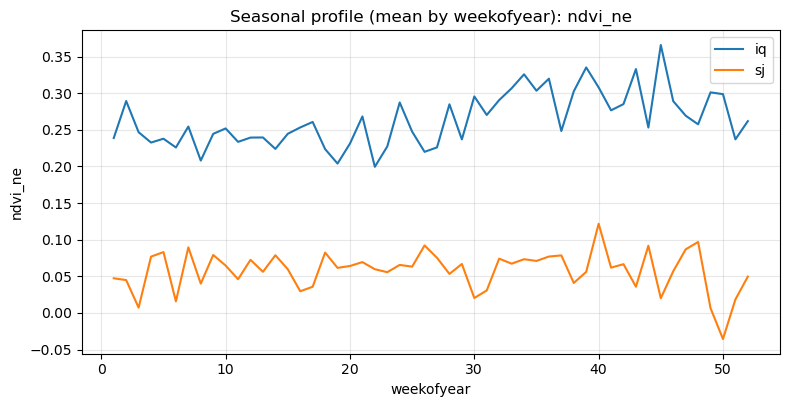

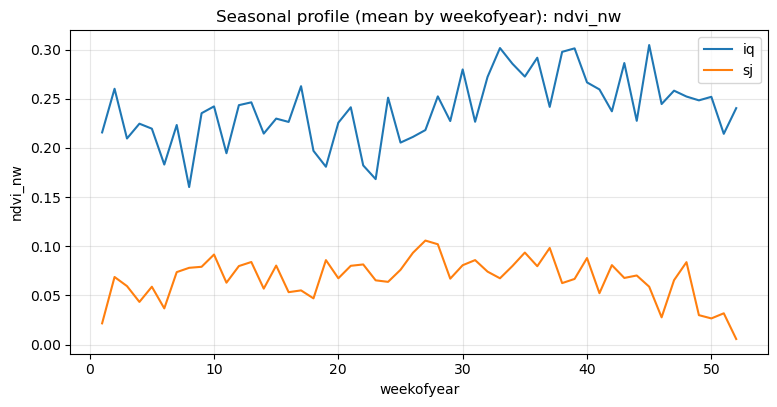

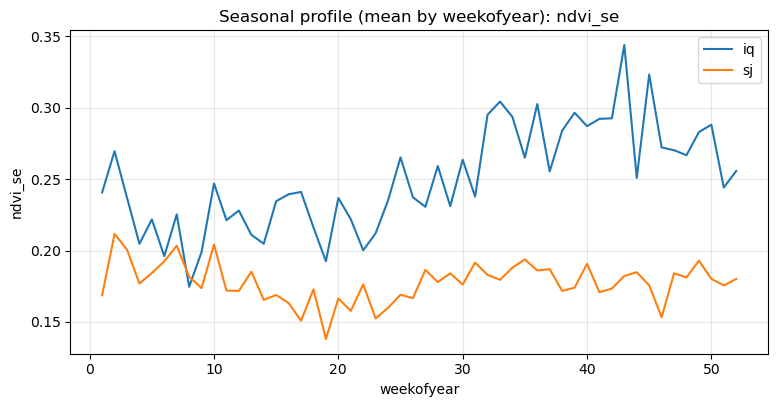

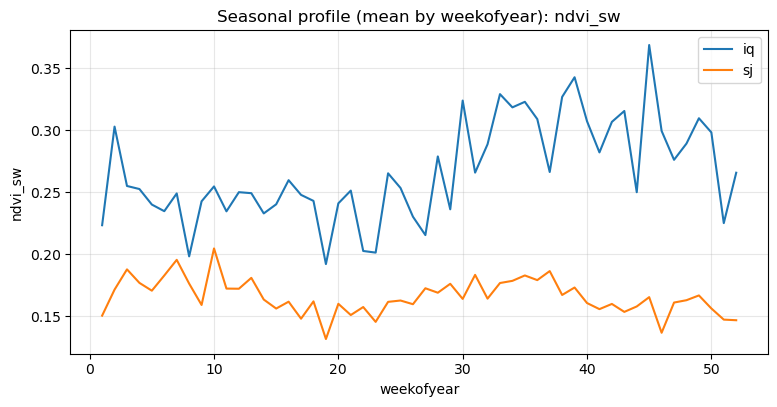

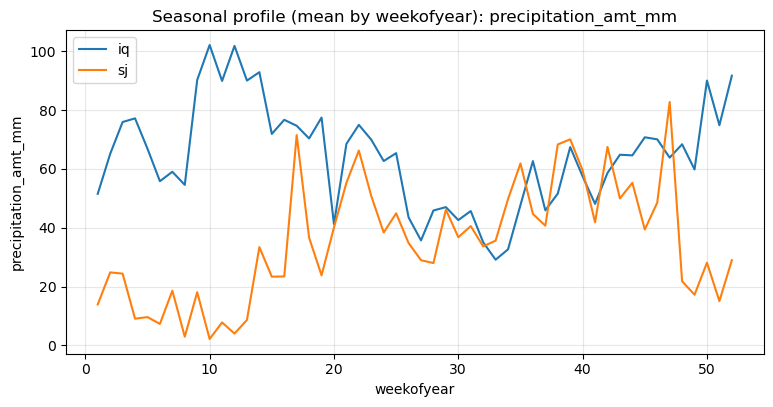

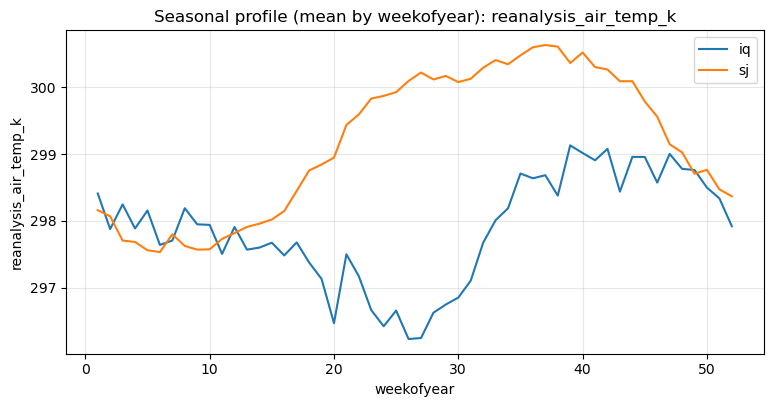

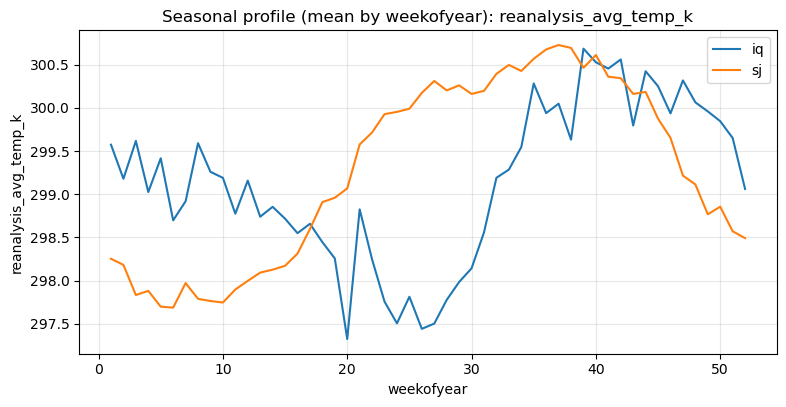

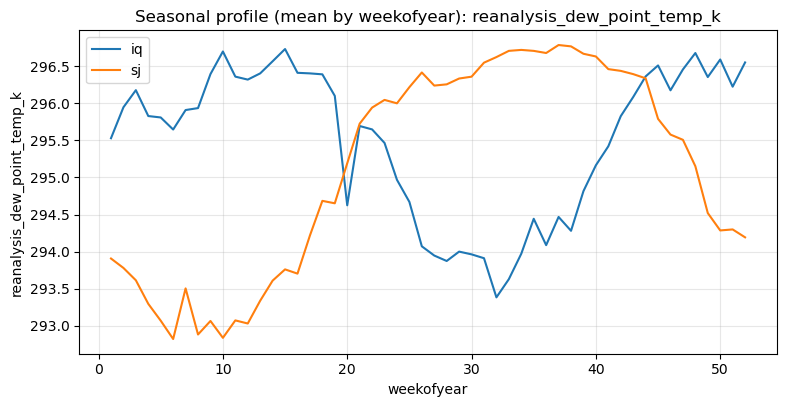

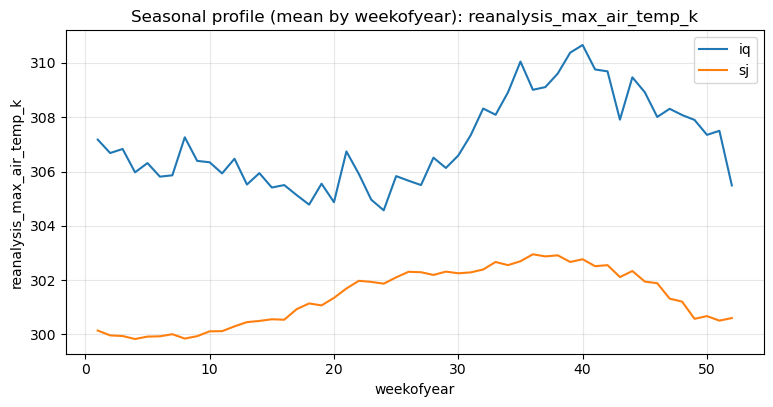

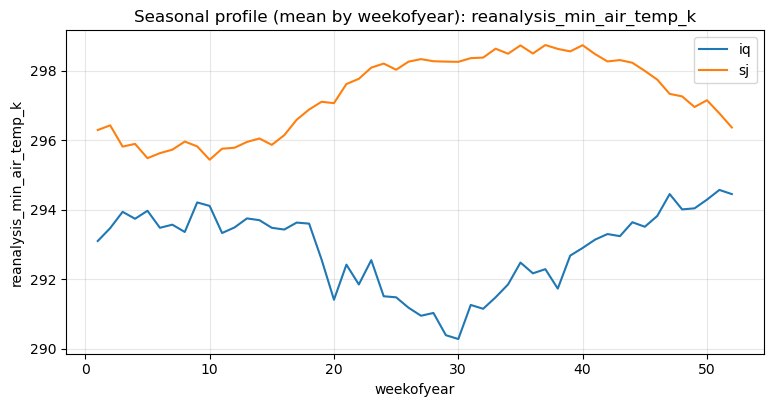

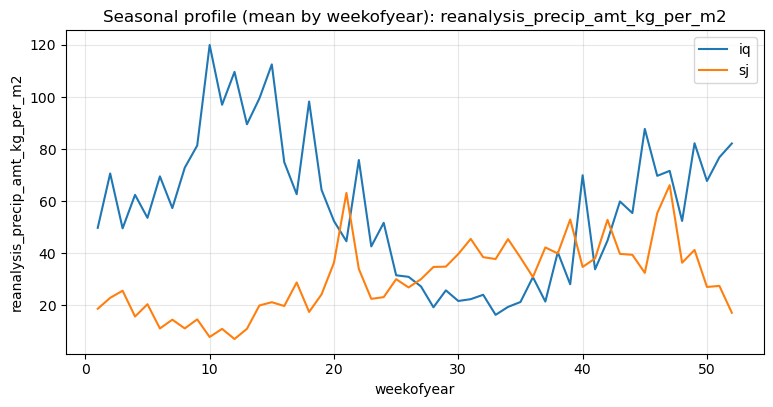

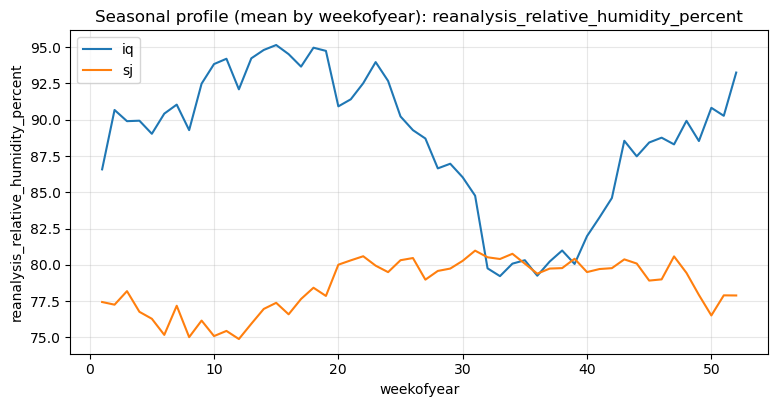

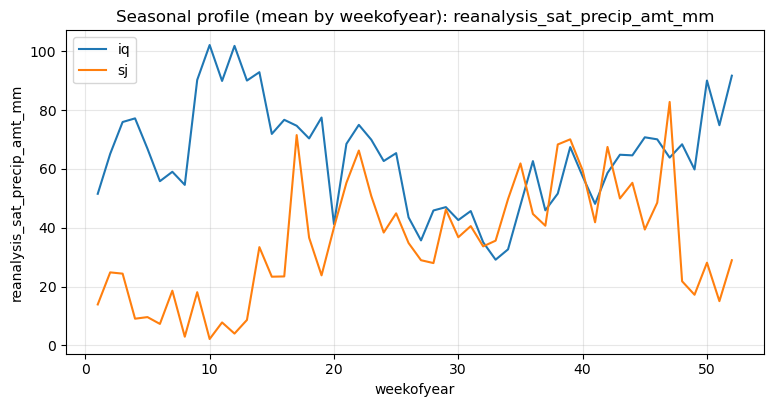

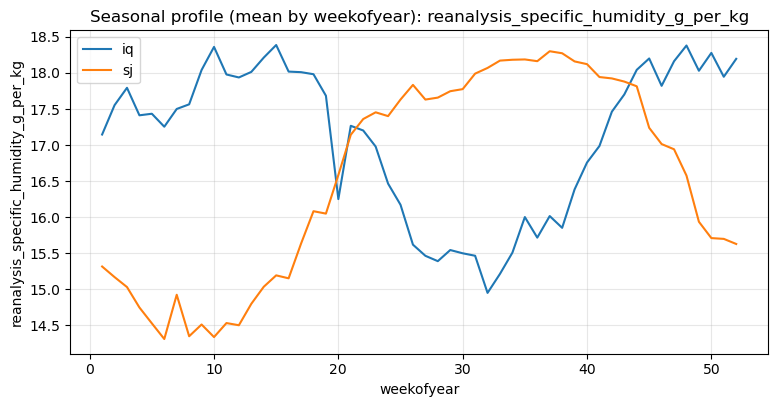

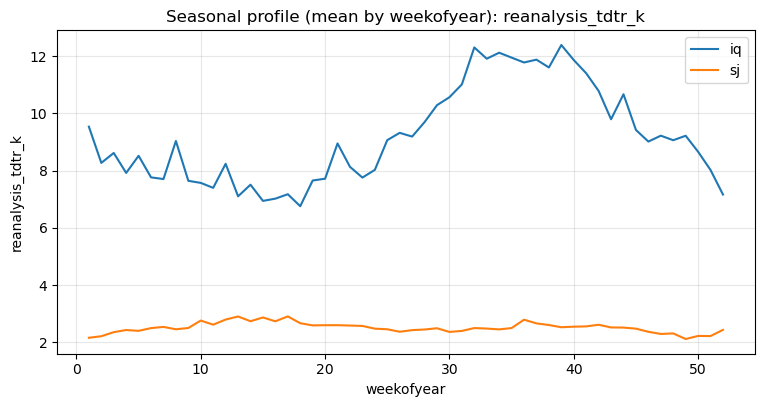

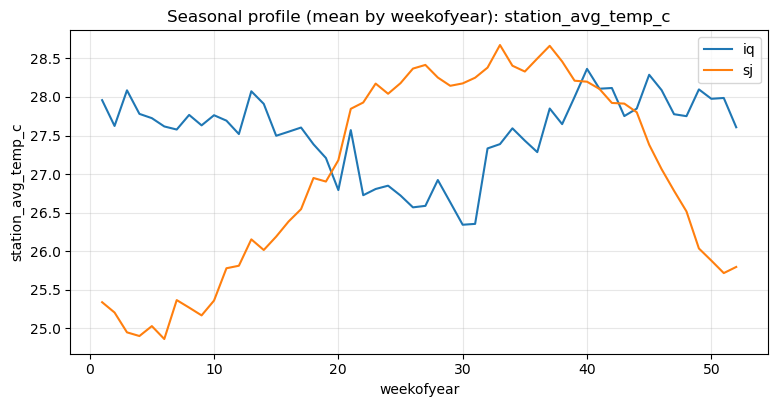

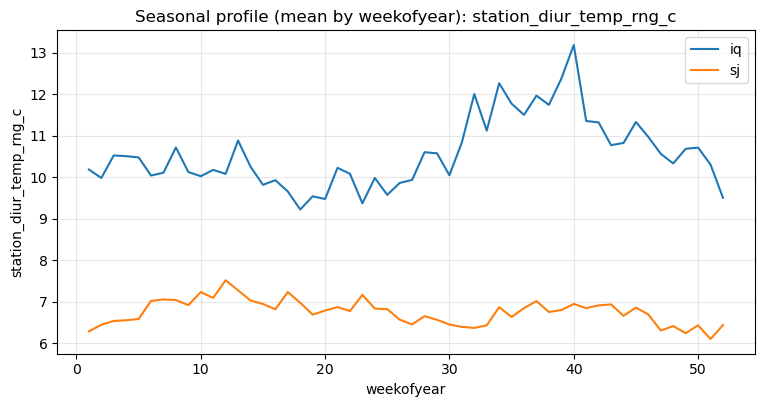

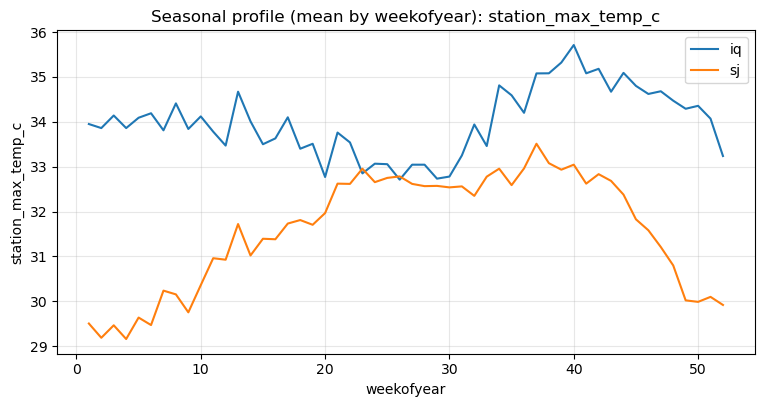

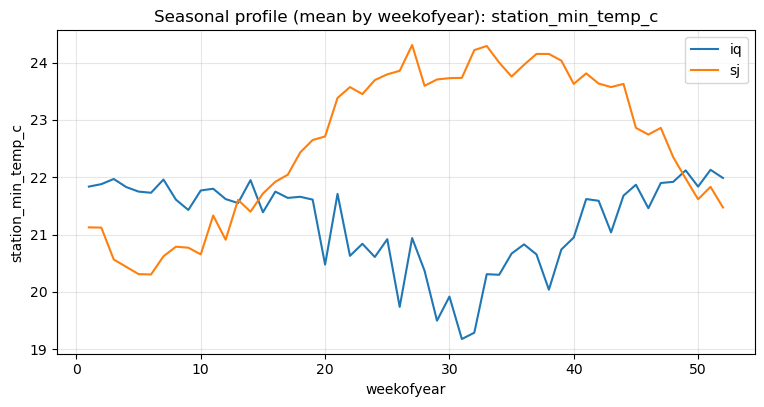

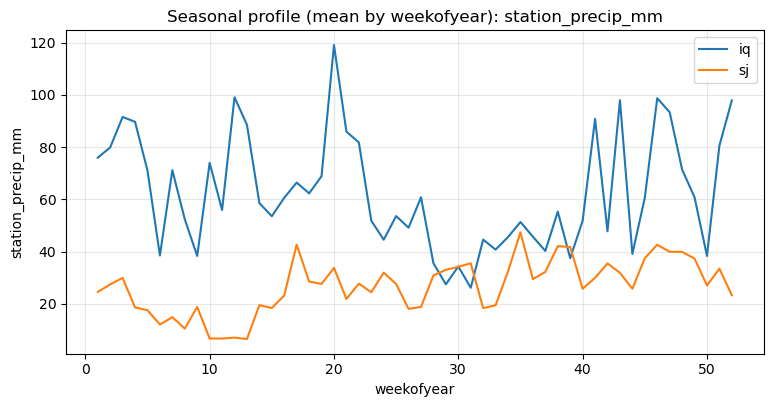

In [19]:
# 1) Seasonal profile plots for ALL features (mean by weekofyear), overlay sj vs iq
for col in FEATURES_ALL:
    prof = (
        feat_train.groupby(["city", "weekofyear"])[col]
        .mean()
        .reset_index()
        .sort_values(["city", "weekofyear"])
    )
    plt.figure(figsize=(9, 4.2))
    for city, g in prof.groupby("city"):
        plt.plot(g["weekofyear"], g[col], label=city)
    plt.title(f"Seasonal profile (mean by weekofyear): {col}")
    plt.xlabel("weekofyear"); plt.ylabel(col)
    plt.grid(alpha=0.3); plt.legend(); plt.show()


**Feature analysis — seasonality (interpretation from plots):**

**NDVI**
- **iq** sits consistently **higher** than **sj** across all quadrants.
- iq shows a **late-year rise** with peaks roughly **wk 35–45**; sj is **lower and flatter** with only a mild late-year bump.

**Precipitation**
- **iq**: pronounced **wet season** in **wk ~8–16**, a **mid-year lull** (**wk ~24–30**), then a **secondary rise** toward **wk ~40–52** (bi-modal pattern).
- **sj**: relatively **dry early year**, then **rainy season** peaks around **wk ~35–45**.
- Satellite and station/reanalysis series **agree** on these shapes.

**Temperature**
- **sj** shows a clear **summer hump** (air/avg/max/min) peaking **wk ~30–40** and cooling afterward.
- **iq** varies **less in level** but **dips mid-year** (wk ~25–35) then increases late-year; **max** temp also humps mid-year.
- **Diurnal range** (`reanalysis_tdtr_k`, `station_diur_temp_rng_c`) is **much larger in iq** and **peaks mid-year**; in sj it is **small and fairly flat**.

**Humidity**
- **iq**: **very high** (often >90% RH) with a **mid-year dip** aligned with higher diurnal range; **specific humidity & dew point** fall mid-year and recover later.
- **sj**: **moderate** RH that **rises into mid/late year**; dew point and specific humidity track the same pattern.

**Consistencies across data sources**
- Station vs. reanalysis/satellite curves show **coherent seasonal shapes**, increasing confidence in the signals.

**Takeaways from these seasonal profiles**
- Both cities exhibit **strong annual cycles**, but **phases differ** (e.g., iq’s early-year rains vs. sj’s late-year rains).
- **Amplitude** is feature- and city-dependent (e.g., **large** for iq diurnal range and RH, **small** for sj NDVI).
- These phase and amplitude differences imply we should **encode seasonality explicitly** (cyclic time) and allow **city-specific** seasonal behavior in later modeling.

- **“Encode seasonality explicitly (cyclic time)”**  
  Your plots show strong *yearly cycles*, but `weekofyear` is an integer where **week 52 and week 1 look far apart** even though they are consecutive.  
  So we map time-of-year onto a **circle** with sine/cosine:
 $$
  \theta = 2\pi \cdot \frac{\text{day-of-year}}{L}\quad (L=365\text{ or }366),\quad
  \text{season\_sin}=\sin\theta,\ \text{season\_cos}=\cos\theta
 $$
  (optionally add harmonics $k=2,3$ for semi-annual, etc.).  
  This lets any model “see” that the year **wraps around** smoothly.

- **“Allow city-specific seasonal behavior”**  
  The **timing (phase)** and **size (amplitude)** of cycles differ between **sj** and **iq** in your plots (e.g., iq’s early-year rains vs. sj’s late-year peak).  
  Don’t force one identical seasonal curve for both cities. Give the model **separate seasonal weights per city**. Three common ways:
  1. **Interactions (global model):** include `city` × (seasonal sin/cos) so each city has its **own coefficients** for the same cyclic basis.  
     *Example idea:* `season_sin1 * [city==iq]`, `season_cos1 * [city==iq]` (and similarly for sj or with one-hot dummies).
  2. **Two separate models:** train one model for **sj** and one for **iq** so each learns its own seasonality.
  3. **Flexible models with city feature:** tree ensembles can learn different patterns by splitting on `city`, but adding explicit interactions still helps linear/GLM models.

**Net effect:** cyclic features capture *the shape* of the year, and city-specific coefficients (or per-city models) capture the **different phase/amplitude** you observed.


**Seasonality metrics — what they mean:**

- **Peak week**  
  The `weekofyear` at which the **mean value** of a feature (averaged over all years for that city) is **highest**.  
  *Use*: when in the year the feature typically peaks.

- **Trough week**  
  The `weekofyear` at which the **mean value** is **lowest**.  
  *Use*: when the feature is typically at its minimum.

- **Amplitude**  
  The **size of the seasonal swing**:  
 $$
  \text{amplitude} = \text{peak\_value} - \text{trough\_value}
  $$ 
  Units are the same as the feature (e.g., °C, mm, NDVI).  
  *Use*: how large the annual cycle is in absolute terms.

- **Relative amplitude**  
  A **unitless** measure of seasonal strength that makes features comparable:  
 $$
  \text{relative amplitude} = \frac{\text{amplitude}}{\text{mean\_level}}
  $$  
  Often read as a percentage (e.g., 0.25 → 25% swing around the mean).  
  *Use*: compare seasonality strength across features/cities.

**Interpretation tips**
- Peak/trough weeks give the **timing** of highs/lows; they help reason about **lags** to the target later.
- Amplitude shows **how much** a feature moves seasonally; relative amplitude compares **across scales**.
- For features with very small means (e.g., precipitation in dry seasons), relative amplitude can be unstable; consider smoothing the weekly means (e.g., 3–5 week rolling) before computing these metrics.


In [20]:
# 2) Seasonality summary table: peak/trough week and amplitudes per feature & city
rows = []
for col in FEATURES_ALL:
    for city, g in feat_train.groupby("city"):
        prof = g.groupby("weekofyear")[col].mean()
        if prof.dropna().empty:
            continue
        peak_week = int(prof.idxmax())
        trough_week = int(prof.idxmin())
        peak_val = float(prof.loc[peak_week])
        trough_val = float(prof.loc[trough_week])
        amp = peak_val - trough_val
        mean_val = float(prof.mean())
        rel_amp = amp / mean_val if mean_val != 0 else np.nan
        rows.append({
            "feature": col,
            "city": city,
            "peak_week": peak_week,
            "trough_week": trough_week,
            "amplitude": amp,
            "relative_amplitude": rel_amp,
            "mean_level": mean_val
        })

seasonality_summary = pd.DataFrame(rows).sort_values(
    ["city", "relative_amplitude"], ascending=[True, False]
).reset_index(drop=True)

print("Seasonality summary (sorted by relative amplitude within city):")
display(seasonality_summary)


Seasonality summary (sorted by relative amplitude within city):


feature city  peak_week  trough_week  \
0         reanalysis_precip_amt_kg_per_m2   iq         10           33   
1                       station_precip_mm   iq         20           31   
2                    precipitation_amt_mm   iq         10           33   
3            reanalysis_sat_precip_amt_mm   iq         10           33   
4                                 ndvi_se   iq         43            8   
5                                 ndvi_sw   iq         45           19   
6                                 ndvi_ne   iq         45           22   
7                       reanalysis_tdtr_k   iq         39           18   
8                                 ndvi_nw   iq         45            8   
9                 station_diur_temp_rng_c   iq         40           18   
10  reanalysis_specific_humidity_g_per_kg   iq         15           32   
11   reanalysis_relative_humidity_percent   iq         15           33   
12                     station_min_temp_c   iq         51           31   
13                     station_max_temp_c   iq         40           26   
14                     station_avg_temp_c   iq         40           30   
15              reanalysis_max_air_temp_k   iq         40           24   
16              reanalysis_min_air_temp_k   iq         51           30   
17            reanalysis_dew_point_temp_k   iq         15           32   
18                  reanalysis_avg_temp_k   iq         39           20   
19                  reanalysis_air_temp_k   iq         39           26   
20                                ndvi_ne   sj         40           50   
21                   precipitation_amt_mm   sj         47           10   
22           reanalysis_sat_precip_amt_mm   sj         47           10   
23        reanalysis_precip_amt_kg_per_m2   sj         47           12   
24                      station_precip_mm   sj         35           13   
25                                ndvi_nw   sj         27           52   
26                                ndvi_sw   sj         10           19   
27                                ndvi_se   sj          2           19   
28                      reanalysis_tdtr_k   sj         17           49   
29  reanalysis_specific_humidity_g_per_kg   sj         37            6   
30                station_diur_temp_rng_c   sj         12           51   
31                     station_min_temp_c   sj         27            6   
32                     station_avg_temp_c   sj         33            6   
33                     station_max_temp_c   sj         37            4   
34   reanalysis_relative_humidity_percent   sj         31           12   
35            reanalysis_dew_point_temp_k   sj         37            6   
36              reanalysis_min_air_temp_k   sj         37           10   
37              reanalysis_max_air_temp_k   sj         36            4   
38                  reanalysis_air_temp_k   sj         37            6   
39                  reanalysis_avg_temp_k   sj         37            6   

     amplitude  relative_amplitude  mean_level  
0   103.555000            1.795516   57.674240  
1    92.900000            1.483964   62.602596  
2    72.990000            1.135102   64.302615  
3    72.990000            1.135102   64.302615  
4     0.169375            0.677247    0.250094  
5     0.176968            0.663489    0.266724  
6     0.166276            0.630282    0.263812  
7     5.631429            0.612098    9.200206  
8     0.144488            0.605180    0.238752  
9     3.963704            0.375014   10.569487  
10    3.436429            0.200954   17.100531  
11   15.922143            0.179609   88.648931  
12    2.950000            0.139136   21.202228  
13    2.998889            0.088219   33.993798  
14    2.020556            0.073417   27.521810  
15    6.090000            0.019832  307.076971  
16    4.290000            0.014648  292.873654  
17    3.348143            0.011331  295.497185  
18    3.362143            0.011240  299.134464  
19    2.898000     

### <span style="color:blue">**Seasonal index & Anomalies:**</span>

**Idea.** For each feature, city, and `weekofyear`, compute a **seasonal index**  
\\(S_{c,w} = \mathrm{mean}\big[x \mid \text{city}=c,\ \text{weekofyear}=w\big]\\).  
Then define **anomalies** as deviations from this seasonal baseline:
- absolute: \\(a = x - S_{c,w}\\)
- percent: \\(a_{\%} = \frac{x - S_{c,w}}{S_{c,w}}\\) (when $S_{c,w}\neq 0$\)

**Why.** This separates “typical seasonal level” from **departures** (e.g., unusually wet weeks). Later, you can feed anomalies (and the baseline itself) as covariates.

> ⚠️ EDA here uses the full dataset just to **inspect** behavior.  
> For modeling, re-compute the seasonal index **inside each time-aware CV fold using past data only** to avoid leakage.


In [21]:
# Seasonal index & anomalies for ALL numeric features (excluding keys/target)

TIME_KEYS = ["year", "weekofyear"]
NON_FEATURES = set(["city", "week_start_date", "total_cases"] + TIME_KEYS)

all_numeric_cols = feat_train.select_dtypes(include=[np.number]).columns.tolist()
FEATURES_ALL = [c for c in all_numeric_cols if c not in NON_FEATURES]

# 1) Seasonal index per (city, weekofyear)
seasonal_idx = (
    feat_train.groupby(["city","weekofyear"])[FEATURES_ALL]
    .mean()
    .reset_index()
)

# 2) Merge back to get seasonal means alongside raw features
feat_train_si = feat_train.merge(
    seasonal_idx, on=["city","weekofyear"], suffixes=("", "_seasonal_mean")
)

# 3) Create anomalies (absolute and percent) with a safe denominator
EPS = 1e-9
for col in FEATURES_ALL:
    base = f"{col}_seasonal_mean"
    feat_train_si[f"{col}_anom"] = feat_train_si[col] - feat_train_si[base]
    denom = feat_train_si[base].where(feat_train_si[base].abs() > EPS, np.nan)
    feat_train_si[f"{col}_anom_pct"] = (feat_train_si[col] - feat_train_si[base]) / denom

print("Created seasonal means and anomalies for", len(FEATURES_ALL), "features.")


Created seasonal means and anomalies for 20 features.


In [22]:
# Quick summary table: how variable are anomalies around zero? (per feature & city)
def mad(x):
    m = np.nanmedian(x)
    return np.nanmedian(np.abs(x - m))

rows = []
for col in FEATURES_ALL:
    for city, g in feat_train_si.groupby("city"):
        a = g[f"{col}_anom"]
        ap = g[f"{col}_anom_pct"]
        rows.append({
            "feature": col,
            "city": city,
            "anom_std": float(np.nanstd(a)),
            "anom_mad": float(mad(a)),
            "anom_pct_std": float(np.nanstd(ap)),
            "seasonal_mean_mean": float(np.nanmean(g[f"{col}_seasonal_mean"])),
        })
seasonal_anom_summary = pd.DataFrame(rows).sort_values(
    ["city","anom_pct_std"], ascending=[True, False]
).reset_index(drop=True)

print("Seasonal anomaly summary (largest % variability first within city):")
display(seasonal_anom_summary.head(20))


Seasonal anomaly summary (largest % variability first within city):


feature city   anom_std   anom_mad  \
0                       station_precip_mm   iq  59.269540  29.743889   
1         reanalysis_precip_amt_kg_per_m2   iq  42.316417  18.516000   
2                    precipitation_amt_mm   iq  30.485703  19.519875   
3            reanalysis_sat_precip_amt_mm   iq  30.485703  19.519875   
4                                 ndvi_nw   iq   0.068498   0.049371   
5                                 ndvi_sw   iq   0.076373   0.051970   
6                                 ndvi_ne   iq   0.072427   0.052164   
7                                 ndvi_se   iq   0.068260   0.048227   
8                       reanalysis_tdtr_k   iq   1.782221   1.236429   
9                 station_diur_temp_rng_c   iq   1.287408   0.896667   
10   reanalysis_relative_humidity_percent   iq   5.884380   3.165429   
11  reanalysis_specific_humidity_g_per_kg   iq   0.997962   0.577929   
12                     station_min_temp_c   iq   0.990656   0.620000   
13                     station_max_temp_c   iq   1.093679   0.692222   
14                     station_avg_temp_c   iq   0.768243   0.443333   
15              reanalysis_max_air_temp_k   iq   1.741475   1.180000   
16              reanalysis_min_air_temp_k   iq   1.207958   0.755000   
17            reanalysis_dew_point_temp_k   iq   0.998093   0.547143   
18                  reanalysis_avg_temp_k   iq   0.969708   0.605000   
19                  reanalysis_air_temp_k   iq   0.844617   0.490143   

    anom_pct_std  seasonal_mean_mean  
0       0.887454           62.466506  
1       0.696988           57.579667  
2       0.509155           64.196762  
3       0.509155           64.196762  
4       0.293788            0.238746  
5       0.293365            0.266727  
6       0.279207            0.263819  
7       0.277458            0.250072  
8       0.200737            9.208060  
9       0.124300           10.573582  
10      0.067947           88.631167  
11      0.059538           17.096304  
12      0.047821           21.199196  
13      0.032034           33.996718  
14      0.028078           27.521482  
15      0.005671          307.083108  
16      0.004132          292.867568  
17      0.003382          295.493119  
18      0.003242          299.134746  
19      0.002835          297.871631

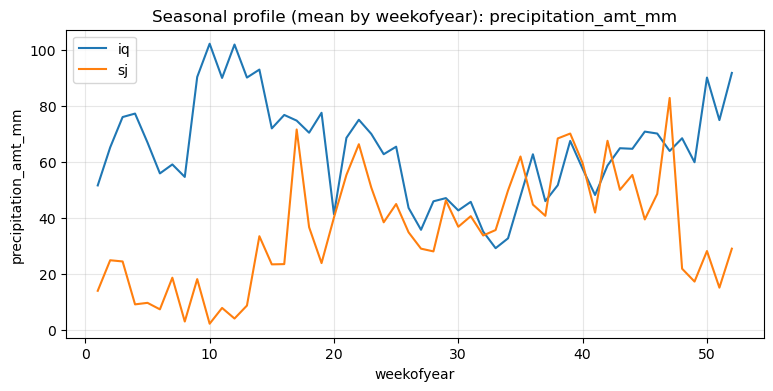

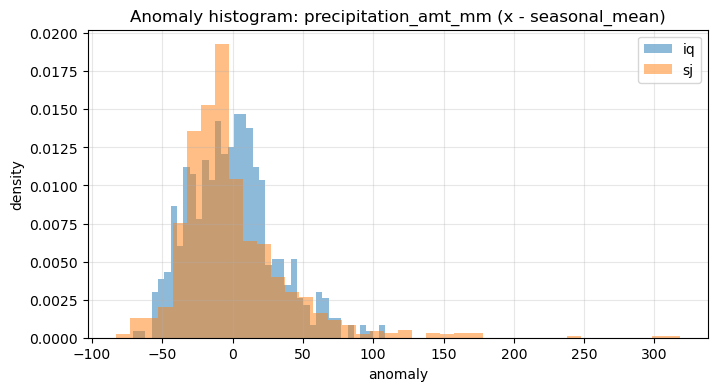

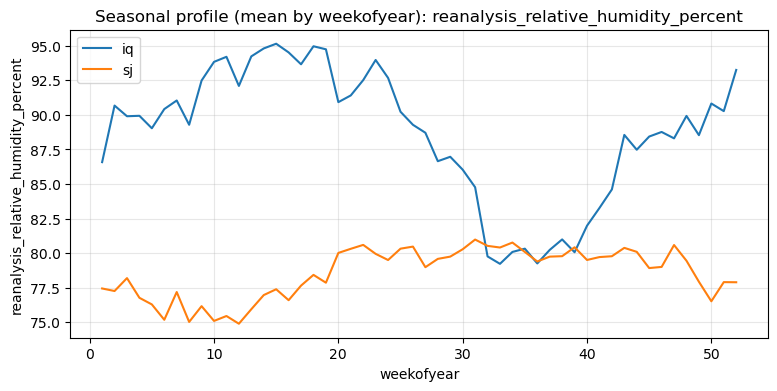

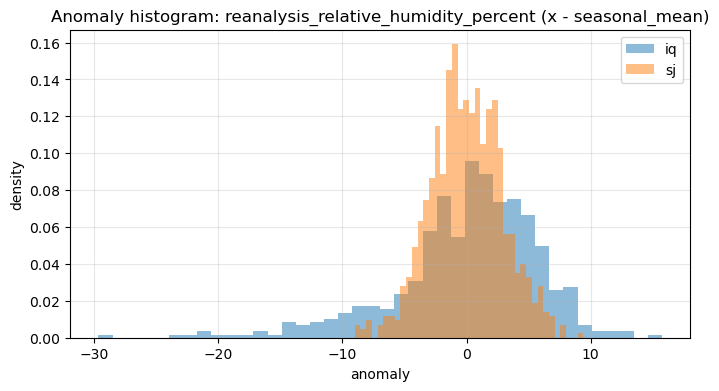

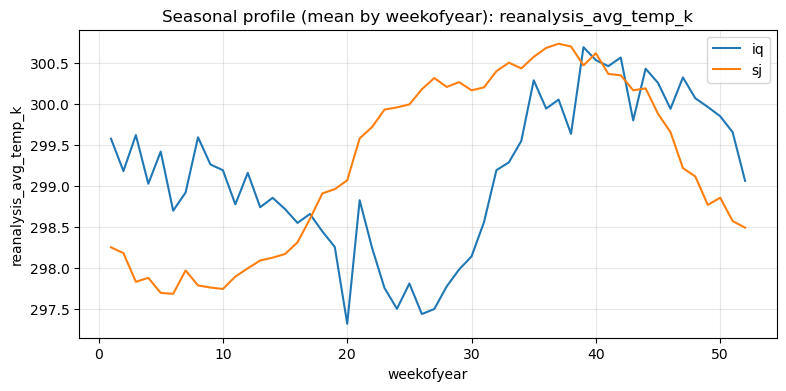

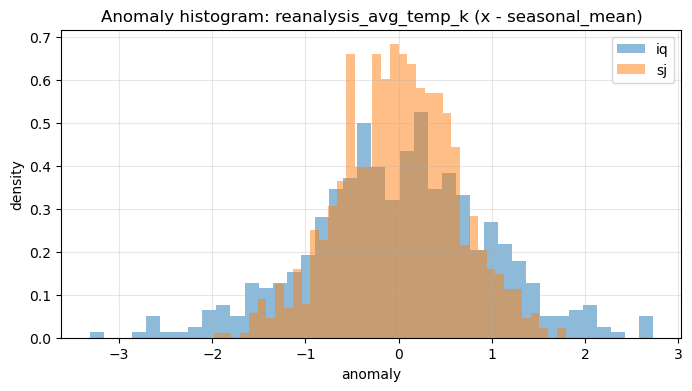

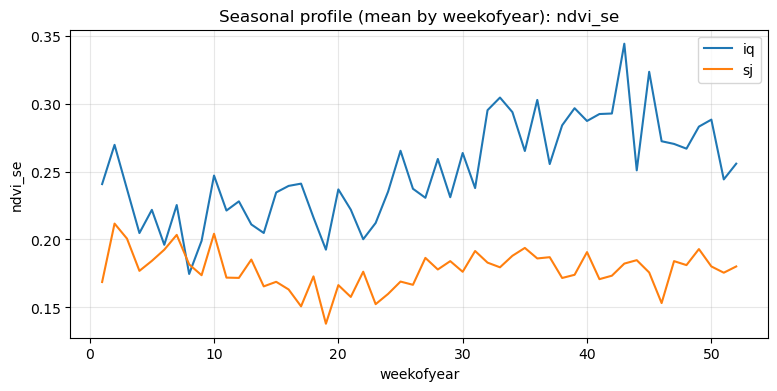

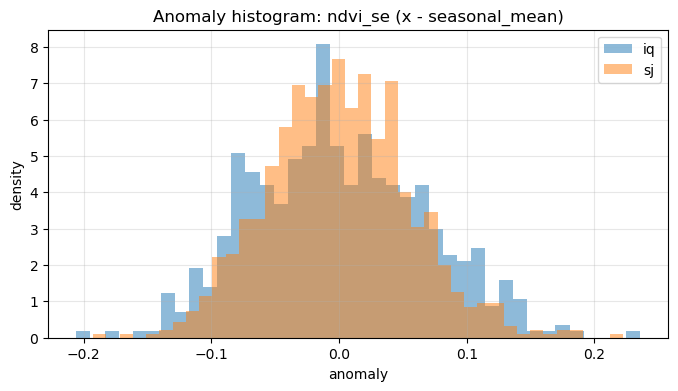

In [23]:
# Diagnostic plots for a few key features: seasonal curve + anomaly hist per city
import matplotlib.pyplot as plt

inspect_cols = [
    "precipitation_amt_mm",
    "reanalysis_relative_humidity_percent",
    "reanalysis_avg_temp_k",
    "ndvi_se",
]

for col in inspect_cols:
    # Seasonal profile (mean by weekofyear)
    prof = (
        feat_train.groupby(["city","weekofyear"])[col]
        .mean().reset_index().sort_values(["city","weekofyear"])
    )
    plt.figure(figsize=(9,4))
    for city, g in prof.groupby("city"):
        plt.plot(g["weekofyear"], g[col], label=city)
    plt.title(f"Seasonal profile (mean by weekofyear): {col}")
    plt.xlabel("weekofyear"); plt.ylabel(col); plt.grid(alpha=0.3); plt.legend(); plt.show()

    # Anomaly histogram per city
    plt.figure(figsize=(8,4))
    for city, g in feat_train_si.groupby("city"):
        data = g[f"{col}_anom"].dropna()
        plt.hist(data, bins=40, density=True, alpha=0.5, label=city)
    plt.title(f"Anomaly histogram: {col} (x - seasonal_mean)")
    plt.xlabel("anomaly"); plt.ylabel("density"); plt.grid(alpha=0.3); plt.legend(); plt.show()


**How to read this**
- If anomaly histograms are **centered near 0** and fairly **narrow**, the seasonal index captures most of the yearly structure.
- Features with **wide anomaly spread** (large `anom_pct_std`) have **volatile departures** from their typical season—often informative for dengue risk (e.g., unusually wet or dry periods).
- In Feature Engineering, you can keep **both** the seasonal baseline (the `*_seasonal_mean`) and the **anomaly** variables; remember to recompute seasonals **within each CV fold** using only past data.


**Seasonal index & anomalies — interpretation (features only):**

**Precipitation (`precipitation_amt_mm`)**
- **Seasonal profile:** iq has an **early wet season** (≈wk 8–16), a lull mid-year, then another rise; sj is **drier early** and gets **wetter late** (≈wk 35–45).
- **Anomaly histogram (x − seasonal_mean):** centered near **0** but **strongly right-skewed** with **very large positive spikes** (occasionally > +200 mm), and a broad negative side down to ~−50 mm.  
  **Implications:** positive **rainfall shocks** are rare but large—good candidates for **lagged effects**; use **log1p** and/or **winsorize** for stability; add **wet/dry flags** and **anomaly roll-ups** (e.g., 4/8/12-week sums of positive anomalies).

**Relative humidity (`reanalysis_relative_humidity_percent`)**
- **Seasonal profile:** iq stays **very humid** with a mid-year dip; sj is **moderate** and rises toward late year.
- **Anomaly histogram:** **narrow, near-Gaussian** around 0 (most within ~±10pp).  
  **Implications:** RH anomalies are **small but systematic**; keep **absolute anomalies** (pp) and consider **joint features** with temperature/diurnal range (e.g., heat-moisture interaction).

**Temperature level (`reanalysis_avg_temp_k`)**
- **Seasonal profile:** clear, smooth **annual cycle**, out of phase between cities (sj peaks later; iq dips mid-year).
- **Anomaly histogram:** **tight, symmetric** around 0 (≈±1 K for most weeks).  
  **Implications:** most temperature variation is **explained by seasonality**; anomalies are modest—use **cyclic time features** for the baseline and keep **temp anomalies** to capture heatwaves/cold snaps (with lags).

**Vegetation (`ndvi_se`)**
- **Seasonal profile:** iq’s baseline **higher** than sj, with a **gradual late-year rise**.
- **Anomaly histogram:** centered near 0, **moderate spread**, roughly symmetric.  
  **Implications:** NDVI anomalies reflect **greenness departures** (e.g., unusual dryness/wetness periods); consider **lagged anomalies** and **rolling means** (plant growth/insect habitat responds slowly).

---

**What these plots tell us about feature engineering (based on features only)**
- The **seasonal index works**: anomaly distributions are centered near **0**, meaning the baseline captures typical annual levels.
- Keep **both** the **seasonal means** (`*_seasonal_mean`) and the **anomalies** (`*_anom`, optionally `%`) as covariates; compute them **per city** and **leakage-safe** inside each time split.
- For **precipitation**, expect **zero-inflation and heavy tails** → add **log1p**, **wet/dry indicators**, and **lagged/rolling sums of positive anomalies**.
- For **temperature & humidity**, the **baseline (cyclic)** carries most signal; anomalies are **subtle** but may still matter with **appropriate lags** or **interactions** (e.g., high humidity + high temp).
- For **NDVI**, use **lagged/rolling anomalies** to capture slower ecological responses.


<a id="eda-target-distribution"></a>
### <span style="color:blue">**EDA — Target (Distribution & Spread):**</span>

In this section we examine the distribution of **`total_cases`** per city to understand scale, skew, and tail behavior. We plot histograms and Empirical Cumulative Distribution Functions (ECDFs) for both the raw counts and their `log1p` transform (which often stabilizes heavy right tails), and we summarize spread statistics by city. We also compute an overdispersion ratio (`var / mean`) to anticipate whether count models like **Negative Binomial** may be more appropriate than Poisson. These diagnostics guide later choices for transformations, evaluation metrics, and feature engineering (e.g., city-wise handling, lagging, and seasonal encodings).





Sources


In [24]:
import numpy as np
import pandas as pd

# Minimal target EDA frame
y_df = (
    train_df[['city', 'week_start_date', 'total_cases']]
    .copy()
)
y_df['week_start_date'] = pd.to_datetime(y_df['week_start_date'])
y_df['log1p_total'] = np.log1p(y_df['total_cases'].astype(float))
y_df = y_df.sort_values(['city', 'week_start_date']).reset_index(drop=True)

# Per-city distribution / spread summary
spread = (
    y_df.groupby('city')['total_cases']
        .agg(count='count', mean='mean', median='median', std='std', var='var', min='min', max='max')
        .assign(overdispersion=lambda d: d['var'] / d['mean'])
        .round(3)
)
display(spread)

y_df.head()


count    mean  median     std       var  min  max  overdispersion
city                                                                   
iq      520   7.565     5.0  10.765   115.896    0  116          15.319
sj      936  34.181    19.0  51.381  2640.045    0  461          77.238

city week_start_date  total_cases  log1p_total
0   iq      2000-07-01            0          0.0
1   iq      2000-07-08            0          0.0
2   iq      2000-07-15            0          0.0
3   iq      2000-07-22            0          0.0
4   iq      2000-07-29            0          0.0

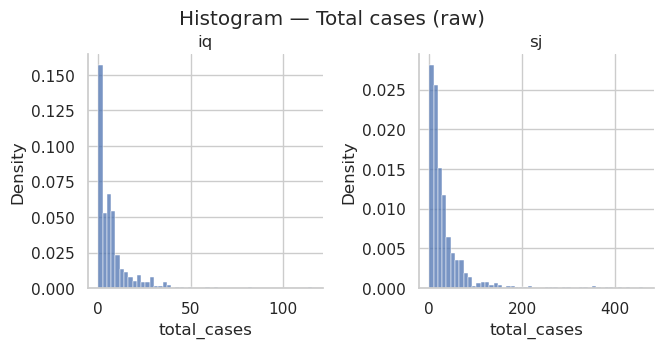

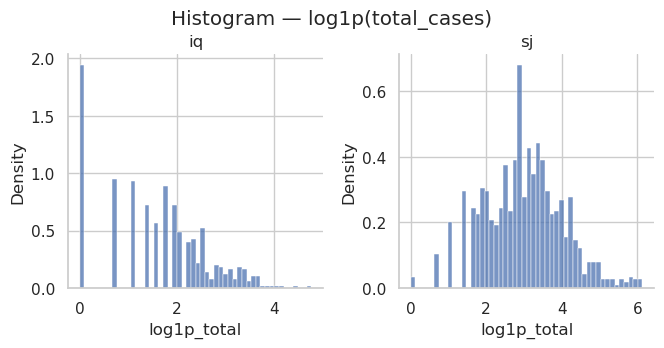

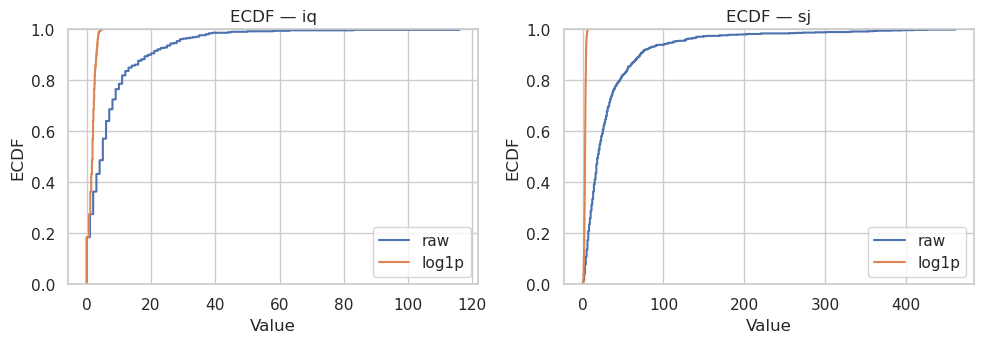

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(context="notebook", style="whitegrid")

# ── Histograms per city ─────────────────────────────────────────────────────────
for col, title in [('total_cases', 'Total cases (raw)'), ('log1p_total', 'log1p(total_cases)')]:
    g = sns.FacetGrid(y_df, col="city", col_wrap=2, sharex=False, sharey=False, height=3.4)
    g.map_dataframe(sns.histplot, x=col, bins=50, stat="density")
    g.set_titles("{col_name}")
    for ax in g.axes.flatten():
        ax.set_ylabel("Density")
        ax.set_xlabel(col)
    g.fig.suptitle(f'Histogram — {title}', y=1.02)
    plt.show()

# ── ECDFs per city: overlay raw vs log1p ────────────────────────────────────────
cities = y_df['city'].unique().tolist()
rows = (len(cities) + 1) // 2
fig, axes = plt.subplots(nrows=rows, ncols=2, figsize=(10, 3.6 * rows), squeeze=False)
axes = axes.flatten()

for i, c in enumerate(cities):
    ax = axes[i]
    sub = y_df[y_df['city'] == c]
    sns.ecdfplot(sub, x='total_cases', ax=ax, label='raw')
    sns.ecdfplot(sub, x='log1p_total', ax=ax, label='log1p')
    ax.set_title(f'ECDF — {c}')
    ax.set_xlabel('Value')
    ax.set_ylabel('ECDF')
    ax.legend(loc='lower right')

# Hide any unused axes if #cities is odd
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


**Target Distribution — Quick Takeaways**

- **Right-skewed:** Many low/zero weeks and long outbreak tails in both cities (hist/ECDF).
- **City contrast:**
  - **sj:** mean **34.18**, median **19**, var **2640.05**, max **461**.
  - **iq:** mean **7.57**, median **5**, var **115.90**, max **116**.  
  → Favor per-city modeling or include city interactions/scalers.
- **Overdispersion:** variance ≫ mean (OD = var/mean): **sj ≈ 77.24**, **iq ≈ 15.32** ⇒ Poisson likely too narrow; consider **Negative Binomial** / **Tweedie** (or heteroskedastic-aware losses).
- **Log transform helps:** `log1p(total_cases)` is closer to unimodal/symmetric and stabilizes variance. If training on log scale, back-transform with `expm1` and consider bias correction.
- **Quantiles:** ECDF medians align with the table (≈ **5** for **iq**, ≈ **19** for **sj**); slow approach to 1 underscores rare but large outbreaks.

<a id="eda-target-boxplots"></a>

### <span style="color:blue">EDA — Target (Box & Violin Plots)</span>


Boxplots and violin plots allow us to see the central tendency and spread of `total_cases` by city while also highlighting potential **outlier weeks** (large outbreak spikes). Because the distributions are right-skewed, these visualizations make the **median vs. extreme values** contrast very clear.

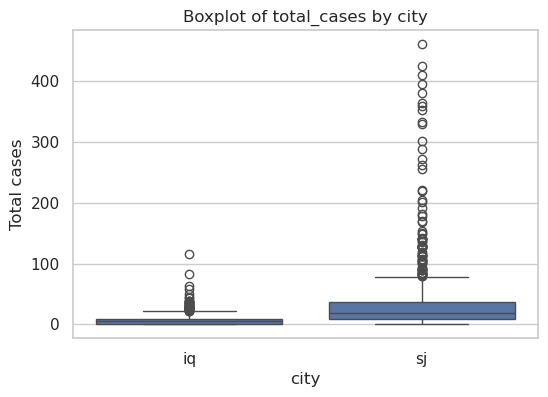

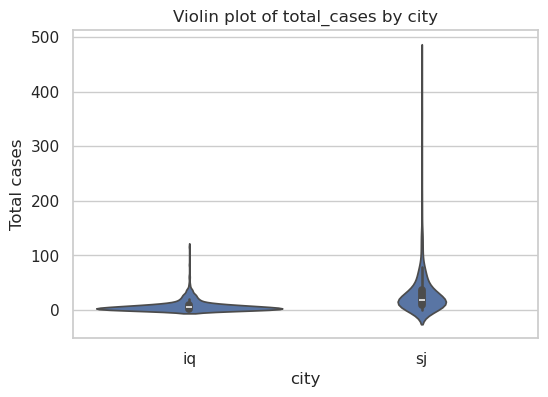

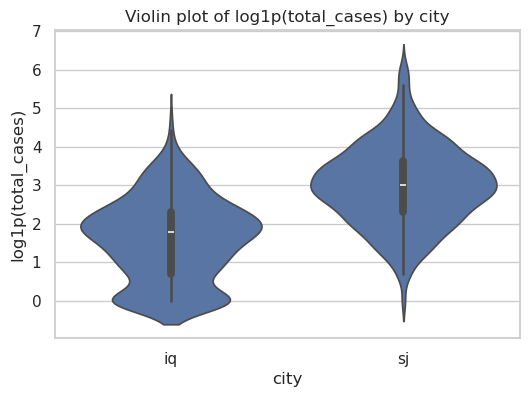

In [26]:
sns.set_theme(context="notebook", style="whitegrid")

# ── Boxplots ──────────────────────────────────────────────
plt.figure(figsize=(6, 4))
sns.boxplot(data=y_df, x='city', y='total_cases')
plt.title("Boxplot of total_cases by city")
plt.ylabel("Total cases")
plt.show()

# ── Violin plots ──────────────────────────────────────────
plt.figure(figsize=(6, 4))
sns.violinplot(data=y_df, x='city', y='total_cases', inner="box")
plt.title("Violin plot of total_cases by city")
plt.ylabel("Total cases")
plt.show()

# ── Log1p violin plots (better for skew) ───────────────────
plt.figure(figsize=(6, 4))
sns.violinplot(data=y_df, x='city', y='log1p_total', inner="box")
plt.title("Violin plot of log1p(total_cases) by city")
plt.ylabel("log1p(total_cases)")
plt.show()


<a id="eda-target-ts-diagnostics"></a>

### <span style="color:blue">EDA — Target (Time-Series Diagnostics)</span>

To understand the temporal dynamics of dengue cases we now analyze the **target variable as a time series**.  
We will start with **decomposition** to separate trend, seasonality, and residuals.  
This helps identify:  
- long-term trends (increasing/decreasing endemic levels),  
- seasonal cycles (e.g. annual dengue seasonality),  
- irregular spikes (epidemic outbreaks).

**Methods for decomposition:**
- **STL (Seasonal-Trend decomposition using LOESS):** flexible, handles non-stationary seasonality (ideal for weekly epidemiology).  
- **Classical decomposition (additive/multiplicative):** simpler, assumes fixed seasonal pattern, less robust.  
- **X-13ARIMA-SEATS:** advanced seasonal adjustment (mainly in economics; not usually needed here).  

<a id="eda-target-stl"></a>

#### <span style="color:blue">STL Decomposition</span>


We’ll decompose weekly **`total_cases`** into **Trend + Seasonal + Remainder** using **STL**. Epidemiologically, dengue and other arboviruses have a strong annual cycle (linked to rainy season, temperature, mosquito ecology), so we start with period ≈ 52 weeks.  
This reveals the long-term level, the annual cycle, and irregular outbreak noise. We’ll run it **per city** on the raw counts (and optionally on `log1p(total_cases)` to stabilize variance) and summarize seasonal/trend strength.

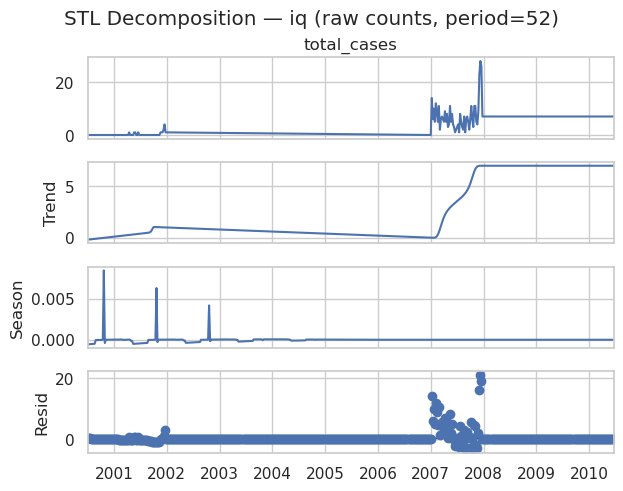

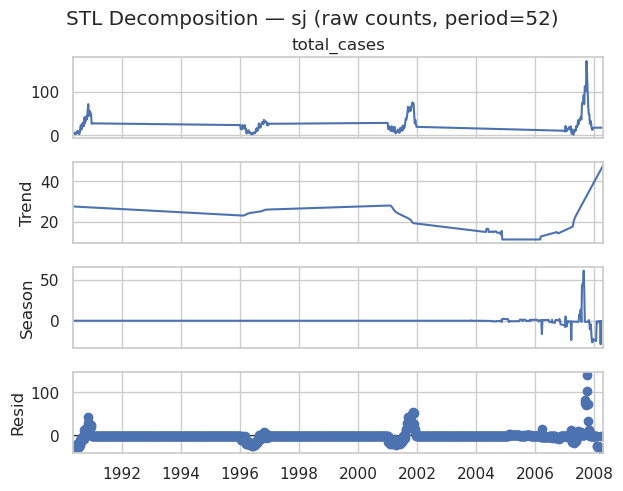

city scale  season_strength  trend_strength
0   iq   raw           -0.000           0.682
1   sj   raw            0.129           0.201

In [27]:
def stl_decompose(series, period=52, robust=True):
    """Run STL and return the fitted result object."""
    return STL(series, period=period, robust=robust).fit()

def stl_strengths(res):
    """
    Seasonality & trend strengths (Cleveland et al.):
    Fs = 1 - Var(remainder)/Var(seasonal + remainder)
    Ft = 1 - Var(remainder)/Var(trend + remainder)
    """
    s = res.seasonal
    t = res.trend
    r = res.resid
    # Guard against zero variance
    def safe_var(x): 
        v = np.var(x[~np.isnan(x)])
        return v if v > 1e-12 else np.nan
    vr = safe_var(r)
    vsr = safe_var(s + r)
    vtr = safe_var(t + r)
    Fs = 1.0 - (vr / vsr) if (vsr and not np.isnan(vsr) and vr is not np.nan) else np.nan
    Ft = 1.0 - (vr / vtr) if (vtr and not np.isnan(vtr) and vr is not np.nan) else np.nan
    return Fs, Ft

period = 52  # weekly seasonality

strength_rows = []

for city in y_df['city'].unique():
    # Build weekly series with a proper DateTimeIndex
    s = (y_df.loc[y_df.city==city, ['week_start_date','total_cases']]
             .dropna()
             .sort_values('week_start_date')
             .set_index('week_start_date')
             .asfreq('W-MON'))  # ensure weekly frequency (align to Mondays)
    
    # Fill small gaps if any (keeps structure; avoids breaking STL)
    s['total_cases'] = s['total_cases'].interpolate(limit_direction='both')

    # Run STL on raw counts
    res = stl_decompose(s['total_cases'], period=period, robust=True)
    Fs, Ft = stl_strengths(res)
    strength_rows.append({'city': city, 'scale': 'raw', 'season_strength': Fs, 'trend_strength': Ft})

    # Plot components
    fig = res.plot()
    fig.suptitle(f'STL Decomposition — {city} (raw counts, period={period})', y=1.02)
    plt.show()

# Summary table of strengths (closer to 1.0 ⇒ stronger component)
stl_summary = pd.DataFrame(strength_rows).round(3)
display(stl_summary)


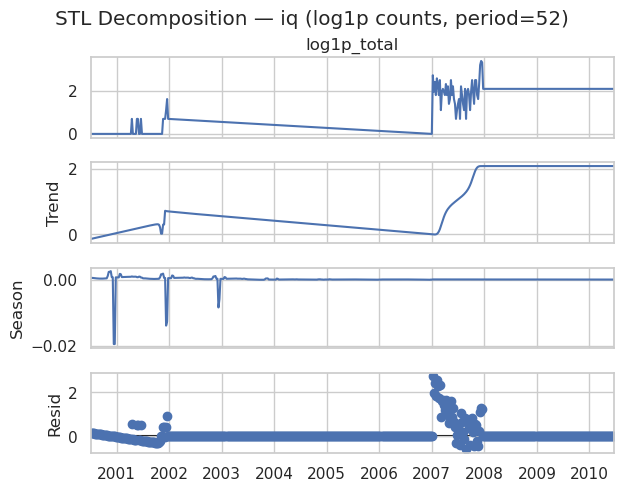

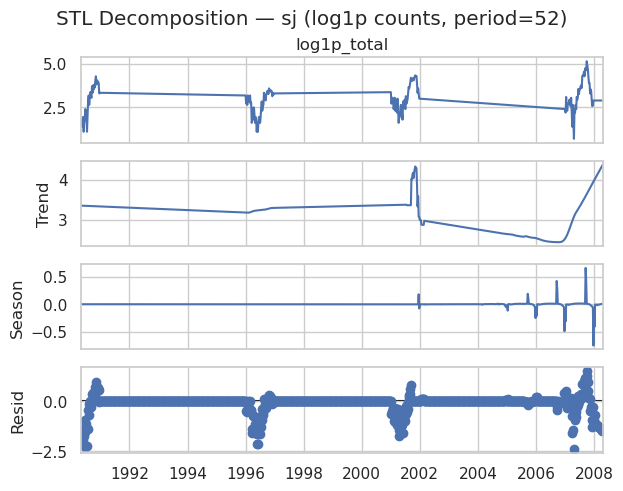

In [28]:
period = 52  # annual cycle for weekly data

for city in y_df['city'].unique():
    # Prepare weekly log1p series
    s = (
        y_df.loc[y_df.city==city, ['week_start_date','log1p_total']]
          .dropna()
          .sort_values('week_start_date')
          .set_index('week_start_date')
          .asfreq('W-MON')  # enforce weekly frequency
    )
    # Fill missing weeks by interpolation
    s['log1p_total'] = s['log1p_total'].interpolate(limit_direction='both')

    # Run STL
    res = STL(s['log1p_total'], period=period, robust=True).fit()

    # Plot
    fig = res.plot()
    fig.suptitle(f"STL Decomposition — {city} (log1p counts, period={period})", y=1.02)
    plt.show()

**STL Decomposition Interpretation**

The STL decompositions for both **raw counts** and **log1p counts** did not extract a clear seasonal component.  
This is unexpected for dengue but can be explained by several factors:

- **Index/frequency sensitivity:**  
  STL requires perfectly regular time steps. Even after resampling to weekly frequency, gaps and interpolation may reduce the strength of repeating cycles, making the seasonal signal collapse.

- **Low signal-to-noise ratio (especially in Iquitos):**  
  Most weeks have very low case counts, with only a few outbreak spikes.  
  This creates a series where variance is dominated by rare events rather than consistent seasonal patterns.

- **Irregular and shifting seasonality:**  
  Dengue epidemics are influenced by rainfall, temperature, and mosquito dynamics, which vary year-to-year.  
  The seasonal peak is not perfectly aligned across years, so STL (which assumes a fixed seasonal pattern repeated every 52 weeks) fails to isolate it.

- **Outbreak-driven variance:**  
  Large epidemic bursts dominate the variance, and the smoother allocates this variance to the **trend** and **residuals** instead of the seasonal component.

**Takeaway:**  
STL is not well suited for dengue case counts in this dataset.  
Seasonality is present (as shown in the **seasonal profile by week-of-year**), but it is **weak, irregular, and outbreak-dependent**, so STL does not capture it.  
For practical purposes, **seasonal profiles, lag correlations (ACF/PACF), and engineered features (e.g., week-of-year sin/cos, rainfall-driven lags)** could be more informative than STL decomposition.


<a id="eda-target-seasonal-profile"></a>

#### <span style="color:blue">Seasonal Profile: Week-of-Year</span>


To check whether a **yearly seasonal cycle** exists, we plot the **average dengue cases by week-of-year** (1–52) for each city.  
If dengue has strong annual seasonality, we should see consistent peaks and troughs at the same weeks each year.  
This method is robust and easier to interpret than STL when data are noisy or have gaps.


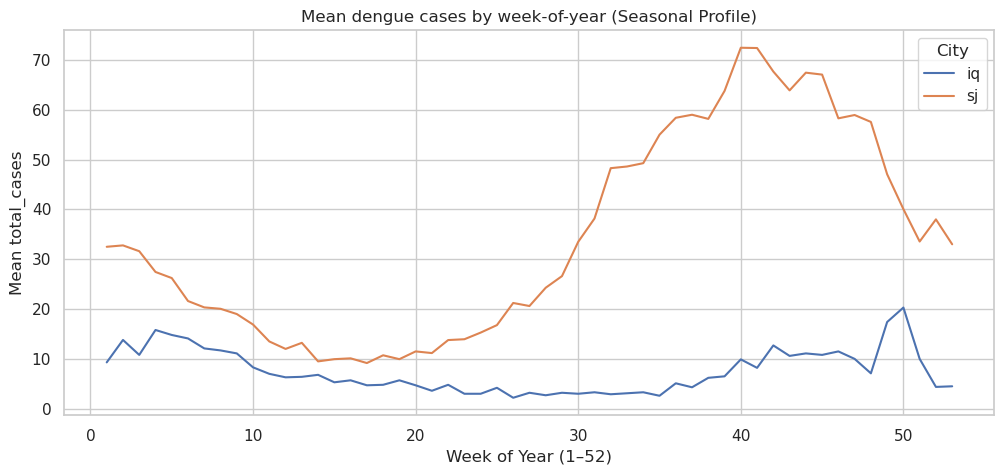

In [29]:
# Extract week-of-year
y_df['weekofyear'] = y_df['week_start_date'].dt.isocalendar().week.astype(int)

# Average profile by city & week-of-year
profile = (
    y_df.groupby(['city', 'weekofyear'])['total_cases']
        .mean()
        .reset_index()
)

plt.figure(figsize=(12, 5))
sns.lineplot(data=profile, x='weekofyear', y='total_cases', hue='city')
plt.title("Mean dengue cases by week-of-year (Seasonal Profile)")
plt.xlabel("Week of Year (1–52)")
plt.ylabel("Mean total_cases")
plt.legend(title="City")
plt.show()


**Seasonal Profile Interpretation**

**San Juan (sj):**
- Very clear annual cycle.  
- Cases are lowest around weeks ~10–20 (spring), rise steadily mid-year, and **peak sharply around weeks 40–45 (autumn)**.  
- Confirms strong seasonality: using **period = 52** in STL is appropriate here.  

**Iquitos (iq):**
- Seasonality is weaker but still visible.  
- Slight peaks around **weeks 1–5** and **weeks 45–50**.  
- Variability is lower overall (case counts rarely exceed 20 on average).  
- Seasonality exists but is less pronounced than in San Juan.  

**Overall:**
- Confirms that dengue has a **yearly seasonal structure** in both cities, much stronger in San Juan.  
- Justifies creating **week-of-year seasonal features** (`sin/cos(2π·woy/52)`) or a **learned seasonal index**.  
- Also confirms the choice of **period = 52** for STL decomposition and SARIMA/ETS baselines.  


<a id="eda-target-acf-pacf"></a>

#### <span style="color:blue">Lag Correlations: ACF/PACF</span>

To explore **temporal dependence** in dengue case counts, we examine the **autocorrelation function (ACF)** and **partial autocorrelation function (PACF)** for each city:

- **ACF:** correlation of the series with its own lags.  
  Peaks at lag *k* indicate that cases at time *t* are correlated with cases at *t–k*.  
- **PACF:** correlation of the series with its own lags, after removing the effects of shorter lags.  
  Useful for identifying the order of autoregressive terms.

**Why this matters:**  
- Reveals how persistent outbreaks are (short-term memory: 1–8 weeks).  
- Confirms whether annual seasonality (~52 weeks) shows up as a correlation spike.  
- Guides **feature engineering** (which lagged target values to include) and baseline time-series models (e.g., SARIMA orders).


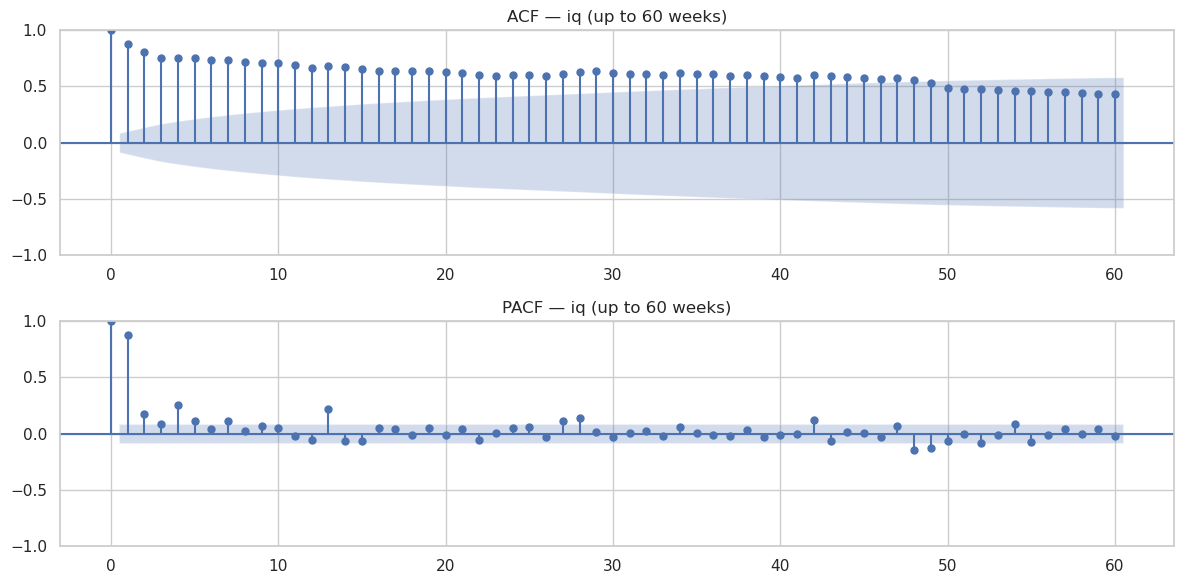

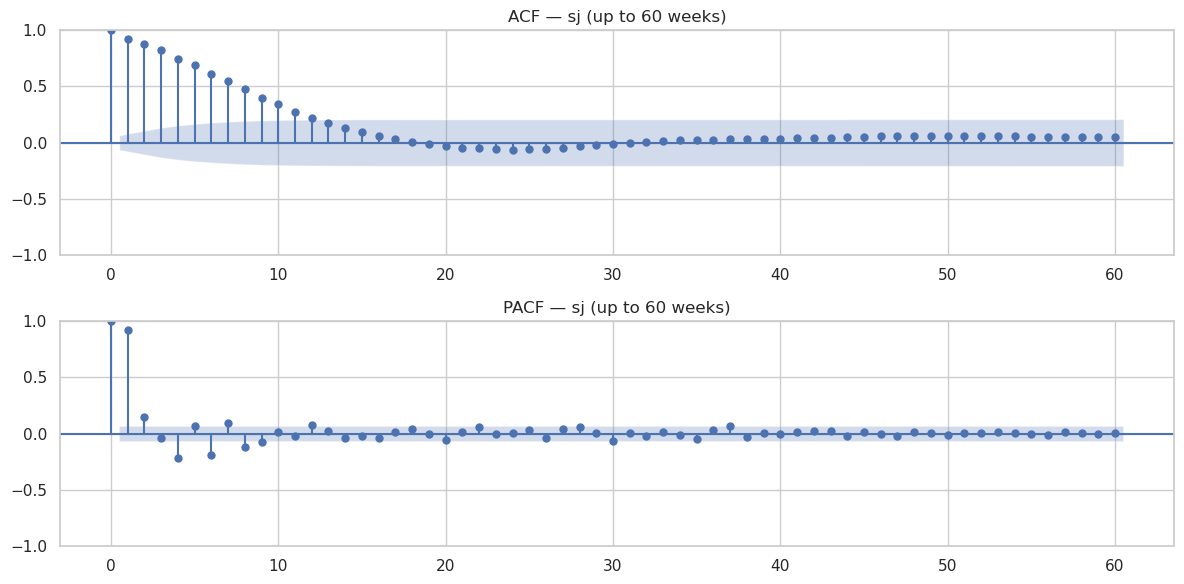

In [30]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

max_lag = 60  # look at ~1 year of lags

for city in y_df['city'].unique():
    # prepare weekly series
    s = (
        y_df.loc[y_df.city==city, ['week_start_date','total_cases']]
            .set_index('week_start_date')
            .asfreq('W-MON')['total_cases']
            .interpolate(limit_direction='both')
    )

    fig, axes = plt.subplots(2, 1, figsize=(12, 6))
    plot_acf(s, lags=max_lag, ax=axes[0])
    axes[0].set_title(f"ACF — {city} (up to {max_lag} weeks)")
    plot_pacf(s, lags=max_lag, ax=axes[1])
    axes[1].set_title(f"PACF — {city} (up to {max_lag} weeks)")
    plt.tight_layout()
    plt.show()


**ACF/PACF Interpretation**

**Iquitos (iq):**
- **ACF:** strong positive autocorrelation at short lags (1–5 weeks), decaying slowly and staying significant up to ~40 weeks.  
  → outbreaks are *persistent*: once they start, they last for many weeks.  
- **PACF:** sharp spike at lag 1, smaller at lags 2–3, then cuts off.  
  → the persistence seen in ACF is largely explained by **direct dependence on the last 1–3 weeks**.  
- ✅ **Interpretation:** most of the predictive signal comes from recent history (`y_{t-1}, y_{t-2}, y_{t-3}`); longer autocorrelation is an *indirect echo* of these short lags.

**San Juan (sj):**
- **ACF:** strong correlation at lags 1–8 weeks, then decays toward insignificance by ~30–40 weeks.  
  → confirms short-term persistence and possible weaker seasonal memory.  
- **PACF:** dominant spike at lag 1 (maybe lag 2), almost flat afterwards.  
  → direct dependence is concentrated in the most recent week or two.  
- ✅ **Interpretation:** short lags explain most of the dependence; seasonal cycles are better captured by week-of-year or climate features than by pure autoregressive terms.

**Conclusions for Modeling:**
- **Lagged target features:** include `y_{t-1}`, `y_{t-2}`, and `y_{t-3}` for both cities. For San Juan, also consider lags up to `y_{t-8}`.  
- **Seasonality:** ACF does not show a clear spike at 52 weeks; instead, capture seasonality with engineered **week-of-year features** (`sin/cos(2π·woy/52)`) or a learned seasonal index.  
- **Model structure:**  
  - **GLM/Negative Binomial regression** with recent lagged targets + seasonal features is a good fit.  
  - **ARIMA/SARIMA:** an **AR(1) or AR(2)** model would align with the PACF cutoff. Seasonal AR terms at lag 52 are less justified here.  
  - **Tree-based models / boosting:** can handle multiple short lags and interactions; pair them with engineered climate lags and seasonal encodings.


<a id="eda-target-stationarity"></a>

#### <span style="color:blue">EDA — Target Stationarity Checks</span>

Classical time-series models such as **ARIMA/SARIMA** assume the series is **stationary**:  
- constant mean,  
- constant variance,  
- stable autocorrelation over time.  

We test stationarity of `total_cases` using:  
- **ADF (Augmented Dickey–Fuller):** null = series has a unit root (non-stationary).  
- **KPSS (Kwiatkowski–Phillips–Schmidt–Shin):** null = series is stationary.  

This combination gives a more balanced view:  
- If ADF rejects but KPSS does not → stationary.  
- If ADF fails to reject and KPSS rejects → non-stationary.  
- If results disagree → the series may be trend- or seasonally-stationary.  

**Note:** For ML models with lagged features, strict stationarity is not required.  
This diagnostic is most relevant for **ARIMA-type baselines**.


In [31]:
def stationarity_tests(series, city):
    print(f"--- {city} ---")
    s = (
        series.dropna()
             .sort_index()
    )

    # ADF test
    adf_res = adfuller(s)
    print("ADF Test:")
    print(f"  Test Statistic: {adf_res[0]:.3f}")
    print(f"  p-value: {adf_res[1]:.3f}")
    print("  -> Reject H0 (unit root)?" , "Yes" if adf_res[1] < 0.05 else "No")

    # KPSS test
    try:
        kpss_res = kpss(s, regression='c', nlags="auto")
        print("KPSS Test:")
        print(f"  Test Statistic: {kpss_res[0]:.3f}")
        print(f"  p-value: {kpss_res[1]:.3f}")
        print("  -> Reject H0 (stationarity)?" , "Yes" if kpss_res[1] < 0.05 else "No")
    except Exception as e:
        print("KPSS Test could not run:", e)

    print("\n")

# Run tests per city
for city in y_df['city'].unique():
    s = (y_df.loc[y_df.city==city, ['week_start_date','total_cases']]
             .set_index('week_start_date')
             .asfreq('W-MON')['total_cases'])
    stationarity_tests(s, city)


--- iq ---
ADF Test:
  Test Statistic: 0.114
  p-value: 0.967
  -> Reject H0 (unit root)? No
KPSS Test:
  Test Statistic: 1.184
  p-value: 0.010
  -> Reject H0 (stationarity)? Yes


--- sj ---
ADF Test:
  Test Statistic: -3.772
  p-value: 0.003
  -> Reject H0 (unit root)? Yes
KPSS Test:
  Test Statistic: 0.405
  p-value: 0.075
  -> Reject H0 (stationarity)? No




/tmp/ipykernel_2422/3903926974.py:17: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_res = kpss(s, regression='c', nlags="auto")


**Stationarity Test Results**

**Iquitos (iq):**  
- **ADF:** fails to reject → non-stationary.  
- **KPSS:** rejects stationarity → non-stationary.  
- ✅ Conclusion: strong evidence of **non-stationarity** (would need differencing/seasonal adjustment if using ARIMA).  

**San Juan (sj):**  
- **ADF:** rejects → stationary.  
- **KPSS:** does not reject → stationary.  
- ✅ Conclusion: series is likely **stationary** (or close to).  

---

**Overall:**  
- *Iquitos:* non-stationary → differencing required for ARIMA-type baselines.  
- *San Juan:* approximately stationary → ARIMA could be applied without differencing.  
- *ML models:* no need to enforce stationarity; this diagnostic mainly informs ARIMA/SARIMA baselines.  



***Visual Stationarity Checks**

In addition to statistical tests (ADF, KPSS), it is useful to **visually inspect stationarity** using:  

- **Rolling mean** (e.g. 52-week window): checks if the average level is stable over time.  
- **Rolling variance**: checks if variability changes over time.  

If the rolling mean or variance drifts, the series is likely non-stationary.  
This visual check is especially helpful to interpret why ADF/KPSS may give different results across cities.


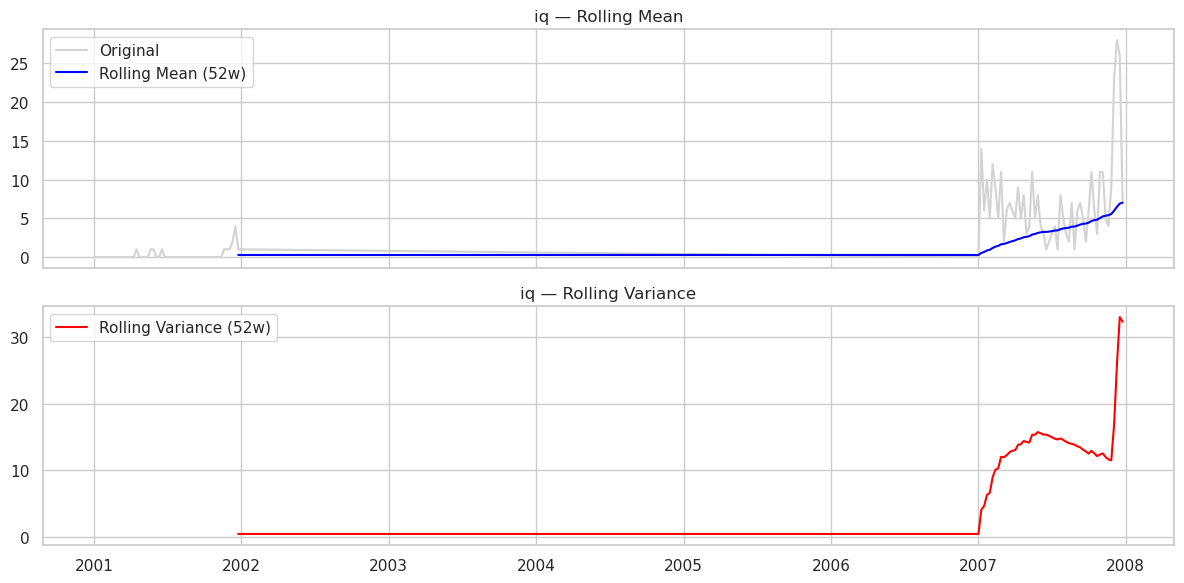

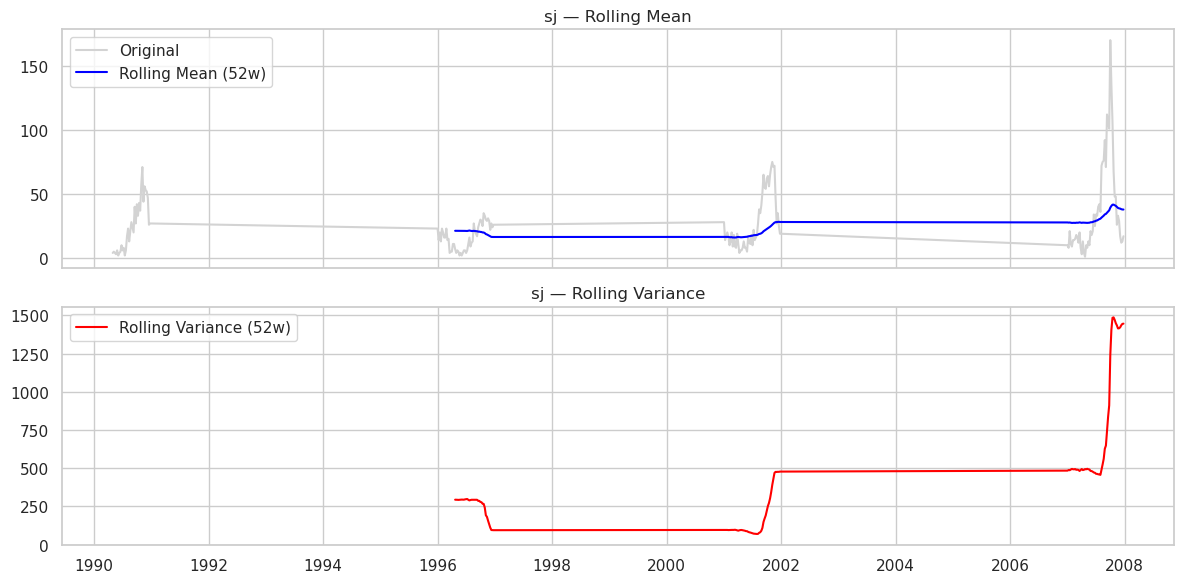

In [32]:
def plot_rolling_stats(series, city, window=52):
    """Plot rolling mean and variance for stationarity check."""
    s = series.dropna().sort_index()
    rol_mean = s.rolling(window=window).mean()
    rol_var = s.rolling(window=window).var()

    fig, ax = plt.subplots(2, 1, figsize=(12,6), sharex=True)

    # Rolling mean
    ax[0].plot(s.index, s, color='lightgray', label='Original')
    ax[0].plot(rol_mean.index, rol_mean, color='blue', label=f'Rolling Mean ({window}w)')
    ax[0].set_title(f"{city} — Rolling Mean")
    ax[0].legend()

    # Rolling variance
    ax[1].plot(rol_var.index, rol_var, color='red', label=f'Rolling Variance ({window}w)')
    ax[1].set_title(f"{city} — Rolling Variance")
    ax[1].legend()

    plt.tight_layout()
    plt.show()

# Plot for each city
for city in y_df['city'].unique():
    s = (
        y_df.loc[y_df.city==city, ['week_start_date','total_cases']]
             .set_index('week_start_date')
             .asfreq('W-MON')['total_cases']
    )
    plot_rolling_stats(s, city)


**Visual Stationarity Checks Interpretation**

**Iquitos (iq):**
- Rolling mean drifts upwards sharply after 2006, reflecting changing epidemic levels.  
- Rolling variance increases dramatically during outbreak years (2006–2008).  
- ✅ Confirms **non-stationarity**: both mean and variance are unstable over time.  

**San Juan (sj):**
- Rolling mean is relatively flat, with only moderate shifts across years.  
- Rolling variance is more stable (though spikes appear during major outbreaks).  
- ✅ Suggests the series is **closer to stationary**, consistent with the ADF/KPSS results.  


<a id="eda-feature-lagged-corr"></a>

### <span style="color:blue">EDA — Target vs. Feature Lagged Correlations</span>

To identify **which climate drivers matter and at what delays**, we examine correlations between `total_cases` and lagged or smoothed versions of the input features.

- **Lagged features:** test lags of 0–20 weeks.  
- **Rolling averages:** smooth climate noise with 4–8 week windows.  
- **Goal:** shortlist promising lagged features for use in Feature Engineering.


In [33]:
import pandas as pd

# Select candidate features (exclude meta + target)
feature_cols = [c for c in feat_train.columns if c not in ['city','week_start_date','total_cases']]

max_lag = 20
lag_corrs = []

for city, grp in train_df.groupby('city'):
    grp = grp.sort_values('week_start_date').reset_index(drop=True)
    for col in feature_cols:
        for lag in range(0, max_lag+1):
            corr = grp['total_cases'].corr(grp[col].shift(lag))
            lag_corrs.append({'city': city, 'feature': col, 'lag': lag, 'corr': corr})

lag_corr_df = pd.DataFrame(lag_corrs).dropna()

# Top correlations per city
top_corrs = (lag_corr_df
             .sort_values(['city','corr'], ascending=[True, False])
             .groupby('city')
             .head(20))
display(top_corrs)



city                                feature  lag      corr
31    iq                             weekofyear   10  0.271923
32    iq                             weekofyear   11  0.267802
30    iq                             weekofyear    9  0.267773
33    iq                             weekofyear   12  0.259182
34    iq                             weekofyear   13  0.251100
29    iq                             weekofyear    8  0.246327
35    iq                             weekofyear   14  0.245543
315   iq  reanalysis_specific_humidity_g_per_kg    0  0.236476
189   iq            reanalysis_dew_point_temp_k    0  0.230401
36    iq                             weekofyear   15  0.230297
316   iq  reanalysis_specific_humidity_g_per_kg    1  0.225996
317   iq  reanalysis_specific_humidity_g_per_kg    2  0.221080
28    iq                             weekofyear    7  0.221003
190   iq            reanalysis_dew_point_temp_k    1  0.220891
37    iq                             weekofyear   16  0.217529
191   iq            reanalysis_dew_point_temp_k    2  0.215446
231   iq              reanalysis_min_air_temp_k    0  0.214514
420   iq                     station_min_temp_c    0  0.211702
421   iq                     station_min_temp_c    1  0.206547
318   iq  reanalysis_specific_humidity_g_per_kg    3  0.205429
829   sj                     station_avg_temp_c   10  0.368997
828   sj                     station_avg_temp_c    9  0.368082
827   sj                     station_avg_temp_c    8  0.364173
830   sj                     station_avg_temp_c   11  0.364096
892   sj                     station_min_temp_c   10  0.362388
891   sj                     station_min_temp_c    9  0.360011
831   sj                     station_avg_temp_c   12  0.357664
826   sj                     station_avg_temp_c    7  0.356195
893   sj                     station_min_temp_c   11  0.353041
890   sj                     station_min_temp_c    8  0.352773
889   sj                     station_min_temp_c    7  0.346549
825   sj                     station_avg_temp_c    6  0.344708
894   sj                     station_min_temp_c   12  0.341847
832   sj                     station_avg_temp_c   13  0.340828
888   sj                     station_min_temp_c    6  0.338266
824   sj                     station_avg_temp_c    5  0.330192
895   sj                     station_min_temp_c   13  0.323191
833   sj                     station_avg_temp_c   14  0.322350
887   sj                     station_min_temp_c    5  0.322272
872   sj                     station_max_temp_c   11  0.315344

**Lagged Feature Correlation Interpretation**

**Iquitos (iq):**
- Top correlations come from the **`weekofyear`** variable (lags 7–16 weeks, corr ≈ 0.22–0.27).  
  → confirms weak but present annual seasonality.  
- Among climate features, the strongest are:  
  - **Specific humidity (g/kg)** (corr ≈ 0.23, best at lag 0–2).  
  - **Dew point temperature (K)** (corr ≈ 0.21–0.23, best at lag 0–2).  
  - **Minimum air temperature** and **station min temperature** (corr ≈ 0.21).  
- **Interpretation:** Iquitos case counts respond mainly to **humidity and temperature**, with **short lags (0–2 weeks)**. Seasonality is weaker, but climate has direct influence almost immediately.

**San Juan (sj):**
- Strongest correlations are with **station average and minimum temperature**:  
  - Avg temp, lags 8–12 weeks: corr ≈ 0.35–0.37.  
  - Min temp, lags 8–12 weeks: corr ≈ 0.35–0.36.  
- Station max temp also shows positive correlation (corr ≈ 0.31 at lag 11).  
- **Interpretation:** In San Juan, **temperature has a delayed effect** (~8–12 weeks) on case counts, consistent with biological lags in mosquito breeding and virus incubation.  
- These are substantially stronger than the top correlations in Iquitos, confirming San Juan’s stronger climate–dengue coupling.

---

**Modeling Implications**
- **Lagged features matter:**  
  - For **Iquitos**: use **short climate lags (0–2 weeks)** for humidity and dew point, plus week-of-year seasonal encodings.  
  - For **San Juan**: include **medium lags (8–12 weeks)** of temperature features, which show the highest correlations.  
- **Rolling averages:** smoothing may further strengthen signal, especially for noisy weekly climate data.  
- **City-specific feature engineering:**  
  - Feature importance differs between cities → build lags per city separately or include city–feature interactions.  
- **Baseline climate drivers:**  
  - **San Juan:** temperature (avg/min) at medium lags.  
  - **Iquitos:** humidity & dew point at short lags.


To visualize how the predictive relationship between climate features and dengue cases evolves with delay,  
we plot **correlation vs. lag** curves for the most relevant features in each city:

- **Iquitos (iq):** humidity and dew point show strongest correlation at short lags (0–2 weeks).  
- **San Juan (sj):** average and minimum temperature peak in correlation at medium lags (8–12 weeks).  

These plots help identify which lagged or smoothed versions of features are most informative for feature engineering.


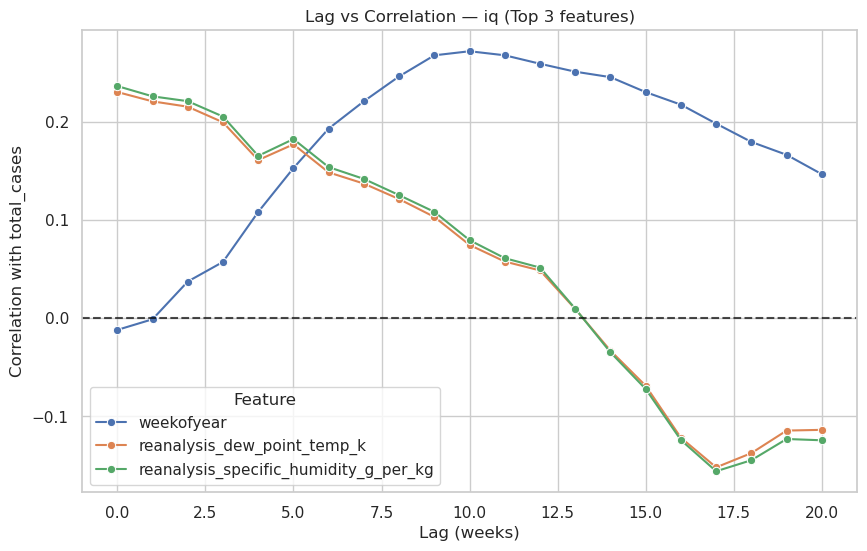

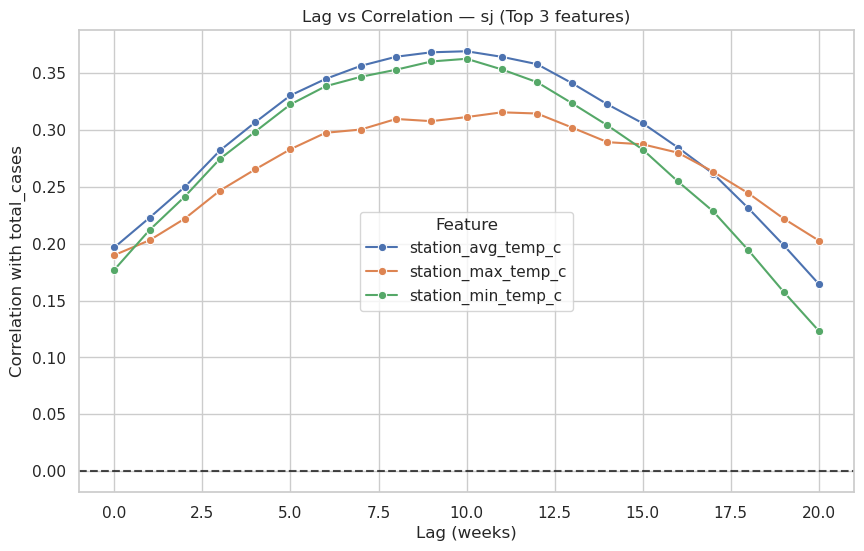

In [34]:
# Take correlation results from lag_corr_df (computed earlier)
# Choose top N features per city based on max correlation
top_n = 3

plots = []
for city in lag_corr_df['city'].unique():
    top_feats = (
        lag_corr_df[lag_corr_df['city']==city]
        .groupby('feature')['corr']
        .max()
        .sort_values(ascending=False)
        .head(top_n)
        .index.tolist()
    )
    
    plt.figure(figsize=(10,6))
    subset = lag_corr_df[(lag_corr_df['city']==city) & (lag_corr_df['feature'].isin(top_feats))]
    sns.lineplot(data=subset, x='lag', y='corr', hue='feature', marker="o")
    plt.title(f"Lag vs Correlation — {city} (Top {top_n} features)")
    plt.xlabel("Lag (weeks)")
    plt.ylabel("Correlation with total_cases")
    plt.legend(title="Feature")
    plt.axhline(0, color='black', linestyle='--', alpha=0.7)
    plt.show()


<a id="eda-target-feature-ccf"></a>

### <span style="color:blue">EDA — Target vs. Features (Cross-Correlation Functions)</span>

The **Cross-Correlation Function (CCF)** measures correlation between two time series  
when one is shifted by a given lag:

$$
\rho_k = \text{Corr}(Y_t, X_{t-k})
$$

- \(Y_t\) = dengue cases at time *t*.  
- \(X_{t-k}\) = climate feature value *k* weeks earlier.  
- Positive lag \(k\): cases lag behind the feature (feature may predict cases).  
- Negative lag \(k\): cases lead the feature (less interpretable, usually spurious).  

**Why use CCF instead of simple lag-correlation tables?**  
- Provides **confidence intervals** to assess which lags are statistically significant.  
- Helps detect **delayed effects** of climate features on dengue cases.  
- Useful for confirming lag windows to include in feature engineering.

We will illustrate CCF for a few key climate drivers (temperature, precipitation, humidity), separately for San Juan and Iquitos.


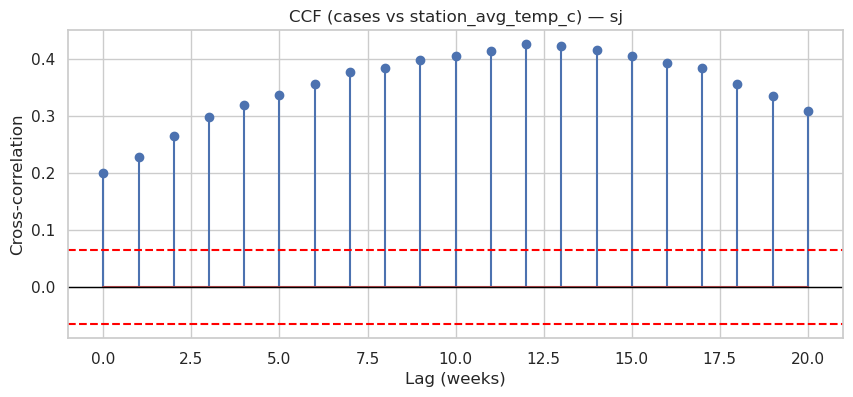

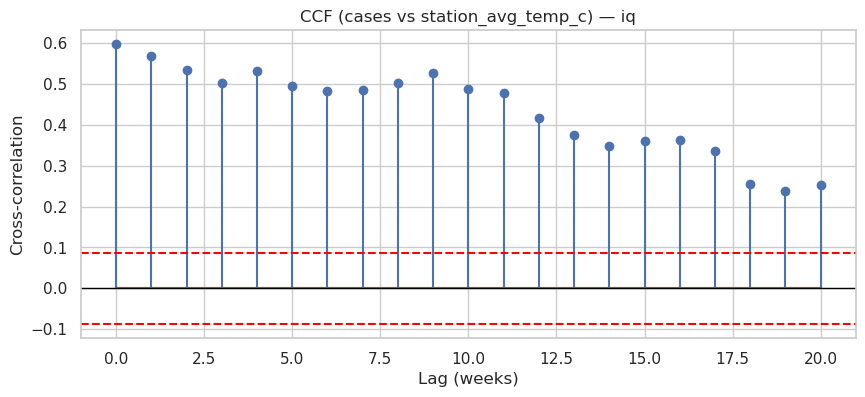

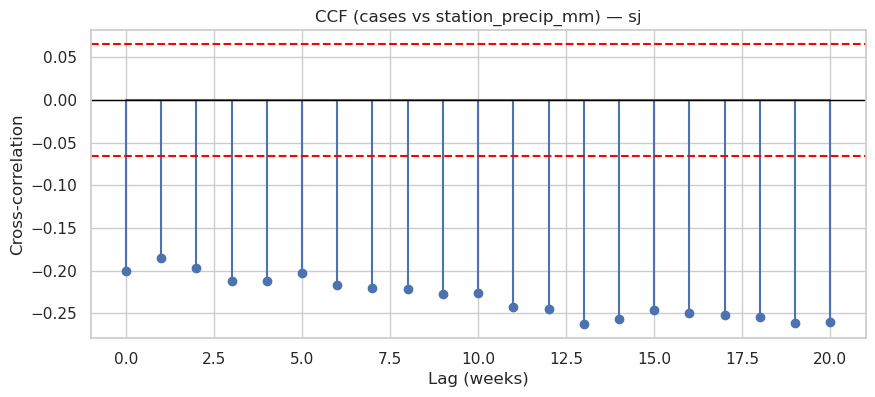

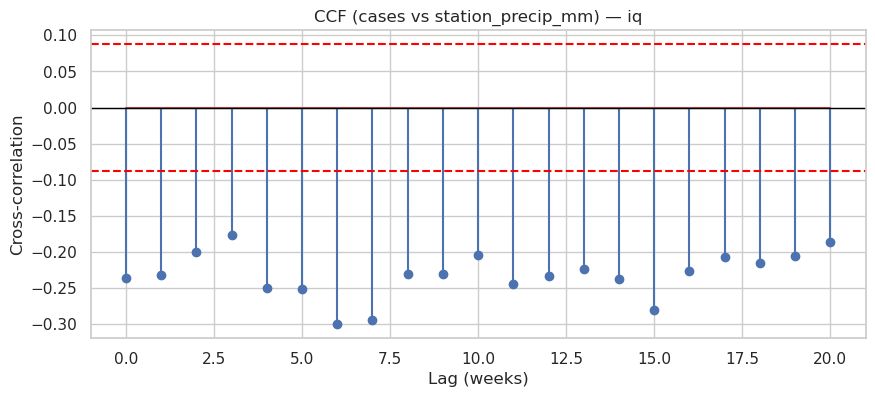

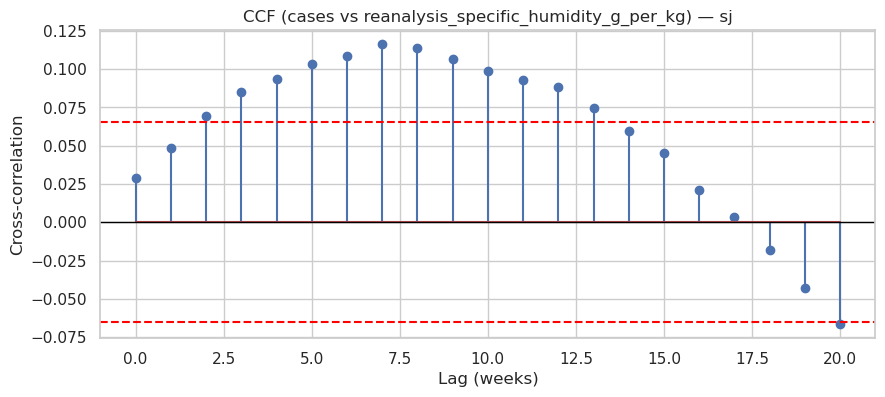

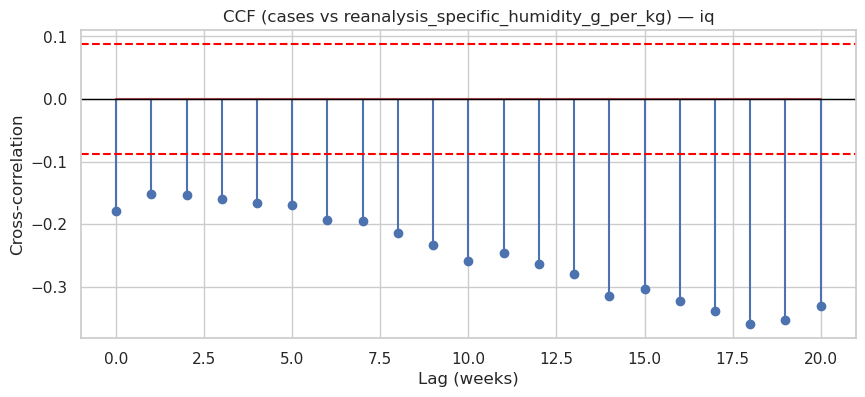

In [35]:
def plot_ccf(city, feature, max_lag=20):
    df_city = (
        train_df.loc[train_df.city==city, ['week_start_date','total_cases',feature]]
        .set_index('week_start_date')
        .asfreq('W-MON')
        .interpolate(limit_direction='both')
    )

    y = df_city['total_cases'] - df_city['total_cases'].mean()
    x = df_city[feature] - df_city[feature].mean()
    corr = ccf(y, x)[:max_lag+1]  # only positive lags

    # 95% CI ≈ ±2/sqrt(N)
    N = len(df_city)
    ci = 2 / np.sqrt(N)

    plt.figure(figsize=(10,4))
    plt.stem(range(max_lag+1), corr)
    plt.axhline(0, color='black', linewidth=1)
    plt.axhline(ci, color='red', linestyle='--')
    plt.axhline(-ci, color='red', linestyle='--')
    plt.title(f"CCF (cases vs {feature}) — {city}")
    plt.xlabel("Lag (weeks)")
    plt.ylabel("Cross-correlation")
    plt.show()

# Example: run for a few features
for feat in ["station_avg_temp_c", "station_precip_mm", "reanalysis_specific_humidity_g_per_kg"]:
    for city in train_df['city'].unique():
        plot_ccf(city, feat, max_lag=20)


**CCF Interpretation**

**1. Temperature (`station_avg_temp_c`)**  
- **San Juan (sj):**  
  - Cross-correlations are significant and positive, peaking around **8–12 weeks**.  
  - Confirms that **sustained warm temperatures lead to higher dengue cases after ~2–3 months**.  
- **Iquitos (iq):**  
  - Very high correlations at **lag 0–5 weeks**, gradually declining afterwards.  
  - Suggests a **much shorter climate–case response window**.  

**2. Precipitation (`station_precip_mm`)**  
- **Both cities:** correlations are significantly **negative** across all lags.  
  - Interpretation: weekly rainfall does not directly increase cases — possibly too noisy or dominated by flood effects.  
  - More likely, **rolling averages or cumulative rainfall** matter rather than concurrent/lagged weekly totals.  
- ✅ Implication: use **smoothed rainfall** instead of raw lagged rainfall.  

**3. Specific humidity (`reanalysis_specific_humidity_g_per_kg`)**  
- **San Juan (sj):**  
  - Positive correlations, significant at **short-to-medium lags (0–12 weeks)**.  
  - Suggests that **sustained humidity supports mosquito breeding and virus survival**, with delayed impact.  
- **Iquitos (iq):**  
  - Negative correlations at almost all lags.  
  - May reflect **data artifacts** (Iquitos already humid year-round → additional variation doesn’t explain much).  

---

**Modeling Implications**
- **Temperature:**  
  - San Juan → include **medium lags (8–12 weeks)**.  
  - Iquitos → include **short lags (0–4 weeks)**.  
- **Precipitation:**  
  - Raw rainfall not predictive; focus on **rolling or cumulative precipitation** features.  
- **Humidity:**  
  - San Juan → positive driver at lags up to ~12 weeks.  
  - Iquitos → little/no useful signal from humidity.  
- **City-specific feature engineering is essential**:  
  - San Juan: strong climate–dengue coupling, delayed effects.  
  - Iquitos: weaker, more immediate climate response, autoregressive terms may matter more.


<a id="eda-feature-rolling"></a>

### <span style="color:blue">EDA — Rolling Averages of Features</span>

To identify meaningful smoothing windows, we compare correlations between dengue cases and **rolling averages** of climate variables.  
Candidate windows: 2, 4, 8, and 12 weeks.  
This helps decide whether short-term or longer-term climate conditions better explain outbreak dynamics.


In [36]:
roll_windows = [2, 4, 8, 12]
roll_corrs = []

for city, grp in train_df.groupby('city'):
    grp = grp.sort_values('week_start_date').reset_index(drop=True)
    for col in feature_cols:
        for w in roll_windows:
            rolled = grp[col].rolling(window=w, min_periods=1).mean()
            corr = grp['total_cases'].corr(rolled)
            roll_corrs.append({'city': city, 'feature': col, 'window': w, 'corr': corr})

roll_corr_df = pd.DataFrame(roll_corrs).dropna()

# Show top rolling correlations per city
top_rolls = (
    roll_corr_df
    .sort_values(['city','corr'], ascending=[True, False])
    .groupby('city')
    .head(20)
)
display(top_rolls)


city                                feature  window      corr
46    iq              reanalysis_min_air_temp_k       8  0.259608
81    iq                     station_min_temp_c       4  0.258097
61    iq  reanalysis_specific_humidity_g_per_kg       4  0.257829
37    iq            reanalysis_dew_point_temp_k       4  0.254226
45    iq              reanalysis_min_air_temp_k       4  0.251944
60    iq  reanalysis_specific_humidity_g_per_kg       2  0.249695
36    iq            reanalysis_dew_point_temp_k       2  0.245140
62    iq  reanalysis_specific_humidity_g_per_kg       8  0.244143
47    iq              reanalysis_min_air_temp_k      12  0.242276
38    iq            reanalysis_dew_point_temp_k       8  0.240916
80    iq                     station_min_temp_c       2  0.238786
82    iq                     station_min_temp_c       8  0.230827
44    iq              reanalysis_min_air_temp_k       2  0.228472
63    iq  reanalysis_specific_humidity_g_per_kg      12  0.222450
39    iq            reanalysis_dew_point_temp_k      12  0.218753
71    iq                     station_avg_temp_c      12  0.215965
70    iq                     station_avg_temp_c       8  0.210482
7     iq                             weekofyear      12  0.194125
31    iq                  reanalysis_air_temp_k      12  0.192608
79    iq                     station_max_temp_c      12  0.192141
171   sj                     station_min_temp_c      12  0.376040
159   sj                     station_avg_temp_c      12  0.367089
167   sj                     station_max_temp_c      12  0.360741
135   sj              reanalysis_min_air_temp_k      12  0.324822
127   sj            reanalysis_dew_point_temp_k      12  0.323832
170   sj                     station_min_temp_c       8  0.322538
151   sj  reanalysis_specific_humidity_g_per_kg      12  0.322399
158   sj                     station_avg_temp_c       8  0.316840
131   sj              reanalysis_max_air_temp_k      12  0.314919
94    sj                             weekofyear       8  0.314684
166   sj                     station_max_temp_c       8  0.310957
95    sj                             weekofyear      12  0.306239
93    sj                             weekofyear       4  0.305786
119   sj                  reanalysis_air_temp_k      12  0.302520
123   sj                  reanalysis_avg_temp_k      12  0.299705
150   sj  reanalysis_specific_humidity_g_per_kg       8  0.295009
126   sj            reanalysis_dew_point_temp_k       8  0.294529
92    sj                             weekofyear       2  0.294510
134   sj              reanalysis_min_air_temp_k       8  0.292878
130   sj              reanalysis_max_air_temp_k       8  0.285923

**Rolling Averages Interpretation**

**Iquitos (iq):**
- Top correlations are moderate (max ≈ 0.26).  
- Best-performing windows are **4–8 weeks**, especially for:  
  - `reanalysis_min_air_temp_k` (corr ≈ 0.26 at 8 weeks).  
  - `station_min_temp_c` (corr ≈ 0.26 at 4 weeks).  
  - `specific_humidity` and `dew_point_temp` (corr ≈ 0.25–0.26 at 2–4 weeks).  
- **Interpretation:** In Iquitos, **short- to medium-term smoothing (2–8 weeks)** strengthens the climate–dengue signal slightly compared to raw values, but correlations remain modest overall.  
- Seasonality (`weekofyear`) is weaker here (lower ranks, corr < 0.20 with smoothing).

**San Juan (sj):**
- Correlations are much stronger (up to ≈ 0.38).  
- Best windows are **longer (8–12 weeks)**, especially for:  
  - `station_min_temp_c` (corr ≈ 0.38 at 12 weeks).  
  - `station_avg_temp_c` (corr ≈ 0.37 at 12 weeks).  
  - `station_max_temp_c` (corr ≈ 0.36 at 12 weeks).  
- Humidity (`specific_humidity`, `dew_point_temp`) also shows useful correlations (~0.32 at 12 weeks).  
- **Interpretation:** In San Juan, dengue cases respond more strongly to **sustained climate conditions**. Rolling averages over **8–12 weeks** give the strongest signals, consistent with biological lags in mosquito population growth and virus transmission.

---

**Modeling Implications**
- **Iquitos:**  
  - Include **short rolling windows (2–4 weeks)** for humidity and dew point.  
  - Include **4–8 week smoothing** for min/avg temperature.  
  - Effects are weaker overall, so autoregressive lags may play a larger role.  
- **San Juan:**  
  - Use **8–12 week rolling averages** of temperature (avg/min/max).  
  - These are strong predictors, better than raw weekly features.  
- **City-specific feature design:**  
  - Lag/rolling window choice must differ by city.  
  - Feature engineering pipeline should compute **city-dependent lags/smooths**.  
- **Model choice:**  
  - Tree-based models can absorb redundant correlated features.  
  - For GLM/regularized regression, choose **one representative per correlated group** (e.g., avg temp for San Juan, humidity for Iquitos).  

---

✅ **Big Picture:**  
- Rolling averages **do improve climate signal strength**.  
- **San Juan** shows stronger and longer climate–dengue coupling (8–12 weeks).  
- **Iquitos** shows weaker and shorter coupling (2–4 weeks).  


<a id="eda-target-feature-concurrent"></a>

### <span style="color:blue">EDA — Target vs. Features (Concurrent)</span>

To establish a baseline understanding of how dengue cases relate to climate drivers,  
we examine **concurrent (same-week) relationships** between `total_cases` and selected features.

- **Scatterplots**: show whether relationships are linear, nonlinear, or threshold-like.  
- **City-specific patterns**: San Juan and Iquitos may differ in which features correlate most strongly.  
- **Purpose**: confirm whether linear models (GLM, NB regression) are appropriate, or if nonlinear methods (trees, splines) may be needed.

We focus on key climate variables (temperature, precipitation, humidity) that are commonly associated with mosquito ecology and dengue transmission.


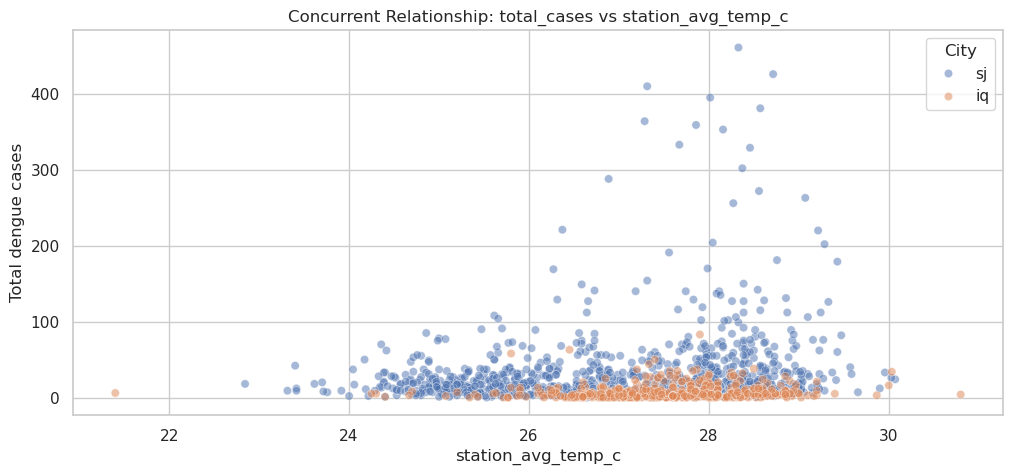

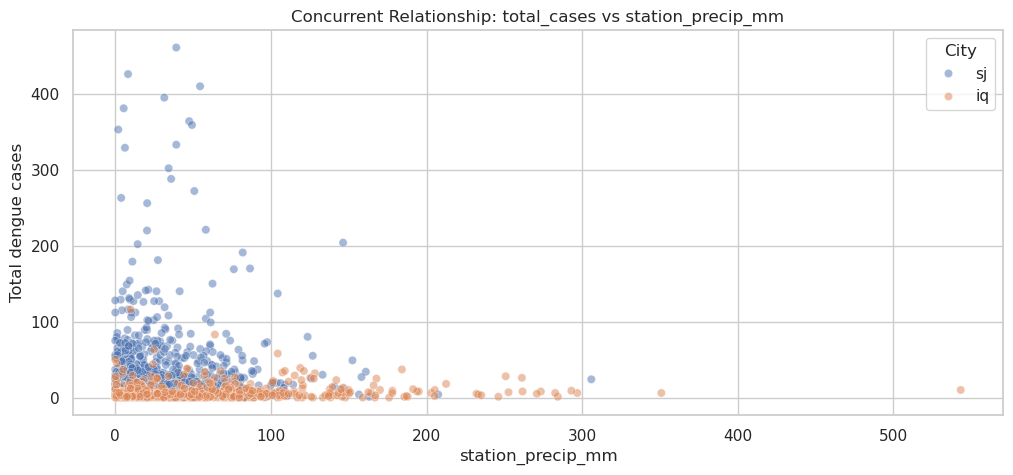

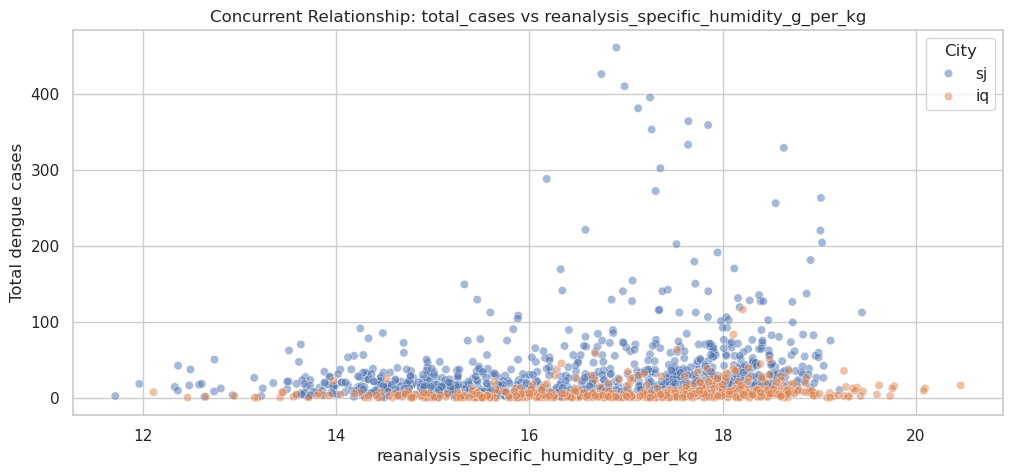

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select a few representative features for plotting
features_to_plot = [
    "station_avg_temp_c",
    "station_precip_mm",
    "reanalysis_specific_humidity_g_per_kg"
]

for feat in features_to_plot:
    plt.figure(figsize=(12,5))
    sns.scatterplot(
        data=train_df, 
        x=feat, 
        y="total_cases", 
        hue="city", 
        alpha=0.5
    )
    plt.title(f"Concurrent Relationship: total_cases vs {feat}")
    plt.xlabel(feat)
    plt.ylabel("Total dengue cases")
    plt.legend(title="City")
    plt.show()


**Concurrent Target–Feature Relationships**

**Station average temperature (`station_avg_temp_c`):**
- **San Juan (sj):** dengue cases cluster strongly in the **26–29°C** range, peaking around 28°C.  
  → Suggests an *optimal temperature band* for mosquito survival and virus transmission.  
- **Iquitos (iq):** values are generally lower and less variable, with weaker concurrent association.  

**Station precipitation (`station_precip_mm`):**
- Both cities: high dengue case counts often occur when weekly rainfall is **moderate (0–100 mm)**.  
- At very high rainfall (>200 mm), cases do not increase further — likely due to **flooding flushing out breeding sites**.  
- Relationship appears **nonlinear** (inverted U-shape).  

**Specific humidity (`reanalysis_specific_humidity_g_per_kg`):**
- **San Juan:** cases rise with humidity, strongest clustering between **16–18 g/kg**.  
- **Iquitos:** humidity is high but more stable; no strong concurrent relationship visible.  
- Confirms **San Juan’s outbreaks are humidity-driven**, while Iquitos is less sensitive in concurrent terms.  

---

**Takeaways**
- Concurrent relationships are **nonlinear** and **city-specific**:  
  - **San Juan:** clear climate sensitivity (temperature band, humidity).  
  - **Iquitos:** weaker concurrent climate links, suggesting lagged effects or other drivers.  
- **Modeling implications:**  
  - Linear models may not capture these relationships well → consider **transformations (splines, polynomials)** or **tree-based models**.  
  - Climate features should be combined with **lags/rolling averages** to capture delayed effects more reliably.


## <span style="color:blue">**Feature Engineering:**</span>

<a id="fe-roadmap"></a>

## <span style="color:blue">Feature Engineering Roadmap</span>

We design feature engineering in **layers**: start with data cleaning (drop & impute), then add seasonality, memory, climate lags, and interaction terms.  
This ensures a reproducible pipeline that works for both city-specific and joint models.

---

#### 0. Data Cleaning (Preprocessing Foundation)
- **Drop columns:**  
  - NDVI features → patchy coverage, unreliable.  
  - Station-based variables → may keep in city-specific models, drop in joint models.  
  - Meta columns (`week_start_date`, etc.) → not direct features.  
- **Fill missing values:**  
  - Interpolation (linear, time-based) for continuous climate variables.  
  - Forward/backfill for small gaps.  
  - Avoid ARIMA imputation (overkill, risk of leakage).

---

#### 1. Seasonality Features
- **Week-of-year cyclic encoding:**  
  - Add `sin(2π · woy / 52)` and `cos(2π · woy / 52)`.  
  - Captures annual seasonality.  
- **Optional Fourier expansion:**  
  - Add higher harmonics (k=2,3…) only if base pair insufficient.  

---

#### 2. Target Memory (Autoregressive Features)
- **Lagged target variables:**  
  - Always: `y_{t-1}`, `y_{t-2}`, `y_{t-3}`.  
  - San Juan: consider up to `y_{t-8}`.  
- **Rolling averages of target:**  
  - 4–8 week rolling mean of `total_cases`.  
- **Anomaly features:**  
  - Seasonal baseline (mean cases by week-of-year).  
  - Anomaly = observed – baseline.  
  - Outbreak flag for large positive anomalies.  

---

#### 3. Climate Features (Lagged & Smoothed)
- **Lagged climate variables (city-specific):**  
  - San Juan → `temp` lags (8–12 weeks).  
  - Iquitos → `humidity`, `dew_point` lags (0–2 weeks).  
- **Rolling climate variables:**  
  - San Juan → rolling avg of temperature (8–12 weeks).  
  - Iquitos → rolling avg of humidity/temp (2–4 weeks).  
- **Precipitation:**  
  - Use 4–8 week rolling sum/mean.  
  - Raw weekly rainfall is too noisy, often negative correlation.

---

#### 4. Interactions & City Effects
- **City indicator:**  
  - Required for joint models (categorical/one-hot).  
- **City × feature interactions:**  
  - Capture different sensitivities by city.  
- **Climate × season interactions:**  
  - E.g., temperature × sin(woy).  

---

#### 5. Redundancy Handling
- **Early option:** drop highly correlated groups (e.g., avg vs min vs max temperature).  
- **Alternative:** keep them all and let regularization (L1/L2) or tree-based models prune.  
- **Recommendation:**  
  - If using GLM/NB regression → prune early (multicollinearity is harmful).  
  - If using trees → safe to keep, importance measures handle redundancy.

---

#3## 6. Feature Selection & Regularization
- Use:  
  - L1 (Lasso) for GLMs.  
  - Tree-based feature importance (XGBoost, RF).  
  - Recursive feature elimination (RFE) if needed.  
- Helps shrink feature set and reduce noise.

---

#### Next Steps
1. Implement **column dropping + missing value imputation** first.  
2. Prototype new features in notebook (seasonality, lags, rolling, anomalies).  
3. Decide on minimal but informative feature set.  
4. Wrap into scikit-learn transformers:  
   - `ColumnDropper`  
   - `TimeSeriesImputer`  
   - `FourierSeasonality`  
   - `LagFeatureAdder`  
   - `RollingFeatureAdder`  
   - `AnomalyFeatureAdder`  
   - `InteractionFeatures`  
5. Chain everything in a preprocessing pipeline for reproducibility.


<a id="fe-drop-impute"></a>

### <span style="color:blue">Feature Engineering — Dropping Columns & Missing Value Imputation</span>

We begin feature engineering by handling **redundant or unreliable columns** and **missing data**.

**Step 1 — Drop columns:**  
- NDVI variables: patchy coverage, unreliable across years.  
- Station-based variables: may be kept in city-specific models, but are inconsistent across cities.  
- Meta columns (e.g., `week_start_date`) should be excluded from numeric modeling.

**Step 2 — Impute missing values:**  
- Apply interpolation (linear or time-based) or forward/backward fill.  
- Avoid ARIMA imputation (too heavy, risk of leakage).  
- Imputation should be applied **after dropping** irrelevant columns.

We implement this using **custom transformers** compatible with scikit-learn pipelines.


In [38]:
class ColumnDropper(BaseEstimator, TransformerMixin):
    def __init__(self, drop_cols=None):
        self.drop_cols = drop_cols if drop_cols is not None else []

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        return X.drop(columns=self.drop_cols, errors="ignore")


In [39]:
class TimeSeriesImputer(BaseEstimator, TransformerMixin):
    def __init__(self, method="linear", limit_direction="both", window=None):
        """
        method: "linear", "ffill", "bfill", "rolling"
        window: if method="rolling", size of rolling window
        """
        self.method = method
        self.limit_direction = limit_direction
        self.window = window

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        # Make best effort to convert numeric-looking object columns
        X = X.infer_objects(copy=False)

        # For methods that need numeric math, operate only on numeric cols
        numeric_cols = X.select_dtypes(include=[np.number]).columns

        if self.method == "linear":
            X[numeric_cols] = (
                X[numeric_cols]
                .interpolate(method="linear", limit_direction=self.limit_direction)
            )
            return X

        elif self.method == "ffill":
            # Forward/back fill is fine across types
            return X.ffill().bfill()

        elif self.method == "bfill":
            return X.bfill().ffill()

        elif self.method == "rolling":
            if self.window is None:
                raise ValueError("`window` must be set when using method='rolling'")
            X[numeric_cols] = X[numeric_cols].fillna(
                X[numeric_cols].rolling(self.window, min_periods=1).mean()
            )
            return X

        else:
            raise ValueError(f"Unknown method: {self.method}")


<a id="fe-fourier-seasonality"></a>

### <span style="color:blue">Feature Engineering — Fourier Seasonality</span>

We encode **annual seasonality** for weekly data using **Fourier terms**:

- Base pair: `sin(2π·woy/52)`, `cos(2π·woy/52)`  
- Optional higher harmonics (k = 2, 3, …) to capture more complex shapes.

**Why:** Smooth, cyclic features model repeating yearly patterns better than raw week-of-year integers and avoid artificial breaks between week 52 → week 1.

**Guideline:** Start with **k=1** (one sine + one cosine). Add more harmonics only if residual seasonality remains.


In [40]:
# FourierSeasonality transformer (scikit-learn compatible)
class FourierSeasonality(BaseEstimator, TransformerMixin):
    """
    Add Fourier seasonal terms for weekly seasonality.
    
    Parameters
    ----------
    date_col : str
        Name of datetime column (e.g., 'week_start_date').
    period : int
        Seasonal period (52 for weekly annual cycle).
    k_max : int
        Number of harmonics to add. k=1 -> sin/cos base pair; k>1 adds higher frequencies.
    drop_woy : bool
        If True, drops the intermediate week-of-year column after creating features.
    prefix : str
        Prefix for created columns.
    """
    def __init__(self, date_col="week_start_date", period=52, k_max=1, drop_woy=True, prefix="fourier"):
        self.date_col = date_col
        self.period = period
        self.k_max = int(k_max)
        self.drop_woy = drop_woy
        self.prefix = prefix
        self.feature_names_ = None

    def fit(self, X, y=None):
        # Nothing to learn; just remember names for get_feature_names_out
        self.feature_names_ = self._make_feature_names()
        return self

    def transform(self, X):
        X = X.copy()
        if self.date_col not in X.columns:
            raise ValueError(f"'{self.date_col}' not found in columns.")
        # Ensure datetime
        wdt = pd.to_datetime(X[self.date_col], errors="coerce")
        if wdt.isna().all():
            raise ValueError(f"Column '{self.date_col}' could not be parsed as datetime.")

        # Week-of-year in [1..52]; map ISO weeks (1..53) into 1..52
        woy = wdt.dt.isocalendar().week.astype(int)
        woy = ((woy - 1) % self.period) + 1  # fold week 53 into cycle
        X["_woy_"] = woy

        # Add Fourier terms
        for k in range(1, self.k_max + 1):
            ang = 2 * np.pi * k * X["_woy_"] / self.period
            X[f"{self.prefix}_sin_k{k}"] = np.sin(ang)
            X[f"{self.prefix}_cos_k{k}"] = np.cos(ang)

        if self.drop_woy:
            X.drop(columns=["_woy_"], inplace=True)

        return X

    def _make_feature_names(self):
        names = []
        for k in range(1, self.k_max + 1):
            names += [f"{self.prefix}_sin_k{k}", f"{self.prefix}_cos_k{k}"]
        return names

    def get_feature_names_out(self, input_features=None):
        return np.array(self.feature_names_ if self.feature_names_ is not None else self._make_feature_names())


<a id="fe-lag-feature-adder"></a>

### <span style="color:blue">Feature Engineering — LagFeatureAdder</span>

We create **lagged versions** of selected columns to capture temporal memory (e.g., `y_{t-1}`, `temp_{t-8}`).

- Supports **global** lags or **city-specific** lags (different lag sets per city).
- Leakage-safe: during `fit`, it stores the **last *max(lags)* rows** per city as **context**; during `transform` on test data, it **prepends** this context so lags are computed correctly without peeking into the future.
- Works with any columns (target or features). Use **after** imputation and baseline seasonality features.


In [41]:
class LagFeatureAdder(BaseEstimator, TransformerMixin):
    """
    Add lagged versions of specified columns with the SAME lag set for all groups.
    Leakage-safe via stored tail 'context' per group from fit().

    Parameters
    ----------
    cols : list[str] or None
        Columns to lag. If None, infer numeric columns (excl. group/date).
    lags : list[int]
        Positive lags in time steps (e.g., [1,2,3,8,12]).
    date_col : str
        Datetime column to sort by (e.g., 'week_start_date').
    group_col : str
        Group column for independent sequences (e.g., 'city').
    drop_na : bool
        If True, drop rows that become NaN due to lagging.
    suffix : str
        Name pattern for new columns; uses {col} and {lag}.
    """
    def __init__(self,
                 cols=None,
                 lags=(1, 2, 3),
                 date_col="week_start_date",
                 group_col="city",
                 drop_na=False,
                 suffix="{col}_lag{lag}"):
        self.cols = None if cols is None else list(cols)
        self.lags = list(lags)
        self.date_col = date_col
        self.group_col = group_col
        self.drop_na = drop_na
        self.suffix = suffix

        # fitted attributes
        self.max_lag_ = None
        self.used_cols_ = None
        self.context_ = None
        self.feature_names_out_ = None

    def fit(self, X, y=None):
        X = X.copy()
        # checks
        if self.date_col not in X.columns:
            raise ValueError(f"'{self.date_col}' not found.")
        if self.group_col not in X.columns:
            raise ValueError(f"'{self.group_col}' not found.")
        # parse date for stable sorting
        X[self.date_col] = pd.to_datetime(X[self.date_col], errors="coerce")
        if X[self.date_col].isna().all():
            raise ValueError(f"Column '{self.date_col}' could not be parsed as datetime.")

        # columns to lag
        if self.cols is None:
            num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
            for c in [self.group_col, self.date_col]:
                if c in num_cols:
                    num_cols.remove(c)
            self.used_cols_ = num_cols
        else:
            self.used_cols_ = [c for c in self.cols if c in X.columns]

        self.max_lag_ = max(self.lags) if self.lags else 0

        # store tail context per group
        ctx_cols = [self.date_col, self.group_col] + self.used_cols_
        context = {}
        if self.max_lag_ > 0:
            for g, gdf in X[ctx_cols].groupby(self.group_col, dropna=False):
                gdf = gdf.sort_values(self.date_col)
                context[g] = gdf.tail(self.max_lag_).copy()
        self.context_ = context

        # feature names
        feat_names = [self.suffix.format(col=c, lag=lag)
                      for c in self.used_cols_ for lag in self.lags]
        self.feature_names_out_ = feat_names
        return self

    def transform(self, X):
        X = X.copy()
        X[self.date_col] = pd.to_datetime(X[self.date_col], errors="coerce")
        if X[self.date_col].isna().all():
            raise ValueError(f"Column '{self.date_col}' could not be parsed as datetime.")

        # ensure all used cols exist (create NaNs if missing)
        for c in self.used_cols_:
            if c not in X.columns:
                X[c] = np.nan

        out_frames = []
        for g, gdf in X.groupby(self.group_col, dropna=False, sort=False):
            gdf = gdf.sort_values(self.date_col).copy()

            # prepend stored context (from fit) for continuity
            if self.max_lag_ > 0 and self.context_ is not None and g in self.context_:
                ctx = self.context_[g][[self.date_col, self.group_col] + self.used_cols_]
                aug = pd.concat([ctx, gdf[[self.date_col, self.group_col] + self.used_cols_]],
                                axis=0, ignore_index=True)
            else:
                aug = gdf[[self.date_col, self.group_col] + self.used_cols_]

            # compute lags on augmented frame
            lagged = {}
            for c in self.used_cols_:
                for lag in self.lags:
                    cname = self.suffix.format(col=c, lag=lag)
                    lagged[cname] = aug[c].shift(lag)
            lagged_df = pd.DataFrame(lagged, index=aug.index)

            # keep only rows corresponding to original gdf (drop prepended context)
            keep_idx = range(len(aug) - len(gdf), len(aug))
            lagged_df = lagged_df.iloc[list(keep_idx)].reset_index(drop=True)

            gdf_out = pd.concat([gdf.reset_index(drop=True), lagged_df], axis=1)

            if self.drop_na:
                g_newcols = [self.suffix.format(col=c, lag=lag) for c in self.used_cols_ for lag in self.lags]
                gdf_out = gdf_out.dropna(subset=g_newcols, how="any")

            out_frames.append(gdf_out)

        X_out = pd.concat(out_frames, axis=0, ignore_index=True)

        # ensure all announced lag columns exist
        for cname in self.feature_names_out_:
            if cname not in X_out.columns:
                X_out[cname] = np.nan
        return X_out

    def get_feature_names_out(self, input_features=None):
        return np.array(self.feature_names_out_)


<a id="fe-rolling-feature-adder"></a>

### <span style="color:blue">Feature Engineering — RollingFeatureAdder</span>

We add **rolling window features** to capture *sustained* climate conditions (e.g., 4–8 week means) and target smoothing (e.g., 4-week mean of cases).

**Why:** Dengue dynamics respond to *persistent* temperature/humidity/rainfall rather than a single week’s value.  
**How:** Compute rolling **mean / sum / min / max / std** over a fixed window per city timeline, leakage-safe across train→test.

**Guidelines**
- Use windows from EDA:  
  - **San Juan:** longer windows (8–12 weeks) for temperature.  
  - **Iquitos:** shorter windows (2–4 weeks) for humidity/temperature.  
- Prefer **means** for temperature/humidity and **sums or means** for rainfall.  
- Create rolling **after imputation** (so NaNs don’t propagate).


In [42]:
class RollingFeatureAdder(BaseEstimator, TransformerMixin):
    """
    Add rolling-window statistics for specified columns, grouped by a time key (e.g., city),
    with leakage-safe context across train/test splits.

    Parameters
    ----------
    cols : list[str] or None
        Columns to roll. If None, infer numeric columns (excluding date/group).
    windows : list[int]
        Window sizes in time steps (e.g., [2,4,8,12]).
    funcs : list[str]
        Aggregations to compute: any of {"mean","sum","min","max","std"}.
    date_col : str
        Datetime column for sorting within each group.
    group_col : str
        Group column for independent sequences (e.g., 'city').
    min_periods : int or None
        Minimum observations in window; default None → uses window size.
    center : bool
        If True, center window (usually False for forecasting).
    suffix : str
        Pattern for new column names; uses {col}, {win}, {func}.

    Notes
    -----
    • Leakage-safe: during fit(), stores the last (max(window)-1) rows per group as context.
      During transform(), context is prepended so rolling windows for the first test rows are valid.
    • Run this AFTER imputing missing values.
    """

    def __init__(self,
                 cols=None,
                 windows=(4, 8),
                 funcs=("mean",),
                 date_col="week_start_date",
                 group_col="city",
                 min_periods=None,
                 center=False,
                 suffix="{col}_roll{win}_{func}"):
        self.cols = None if cols is None else list(cols)
        self.windows = list(windows)
        self.funcs = list(funcs)
        self.date_col = date_col
        self.group_col = group_col
        self.min_periods = min_periods
        self.center = center
        self.suffix = suffix

        # fitted attrs
        self.max_window_ = None
        self.used_cols_ = None
        self.context_ = None
        self.feature_names_out_ = None

    def fit(self, X, y=None):
        X = X.copy()
        if self.date_col not in X.columns:
            raise ValueError(f"'{self.date_col}' not found.")
        if self.group_col not in X.columns:
            raise ValueError(f"'{self.group_col}' not found.")
        X[self.date_col] = pd.to_datetime(X[self.date_col], errors="coerce")
        if X[self.date_col].isna().all():
            raise ValueError(f"Column '{self.date_col}' could not be parsed as datetime.")

        if self.cols is None:
            num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
            for c in [self.group_col, self.date_col]:
                if c in num_cols:
                    num_cols.remove(c)
            self.used_cols_ = num_cols
        else:
            self.used_cols_ = [c for c in self.cols if c in X.columns]

        self.max_window_ = max(self.windows) if self.windows else 0
        ctx_cols = [self.date_col, self.group_col] + self.used_cols_
        context = {}
        if self.max_window_ > 1:
            need_tail = self.max_window_ - 1
            for g, gdf in X[ctx_cols].groupby(self.group_col, dropna=False):
                gdf = gdf.sort_values(self.date_col)
                context[g] = gdf.tail(need_tail).copy()
        self.context_ = context

        # feature names
        feats = []
        for c in self.used_cols_:
            for w in self.windows:
                for fn in self.funcs:
                    feats.append(self.suffix.format(col=c, win=w, func=fn))
        self.feature_names_out_ = feats
        return self

    def transform(self, X):
        X = X.copy()
        X[self.date_col] = pd.to_datetime(X[self.date_col], errors="coerce")
        if X[self.date_col].isna().all():
            raise ValueError(f"Column '{self.date_col}' could not be parsed as datetime.")
        for c in self.used_cols_:
            if c not in X.columns:
                X[c] = np.nan

        out_frames = []
        need_tail = self.max_window_ - 1 if self.max_window_ and self.max_window_ > 1 else 0

        for g, gdf in X.groupby(self.group_col, dropna=False, sort=False):
            gdf = gdf.sort_values(self.date_col).copy()

            # prepend context for leakage-safe rolling
            if need_tail > 0 and self.context_ is not None and g in self.context_:
                ctx = self.context_[g][[self.date_col, self.group_col] + self.used_cols_]
                aug = pd.concat([ctx, gdf[[self.date_col, self.group_col] + self.used_cols_]],
                                axis=0, ignore_index=True)
            else:
                aug = gdf[[self.date_col, self.group_col] + self.used_cols_]

            # compute rolling stats
            rolled = {}
            for c in self.used_cols_:
                s = aug[c]
                for w in self.windows:
                    mp = self.min_periods if self.min_periods is not None else w
                    r = s.rolling(window=w, min_periods=mp, center=self.center)
                    for fn in self.funcs:
                        cname = self.suffix.format(col=c, win=w, func=fn)
                        if fn == "mean":
                            rolled[cname] = r.mean()
                        elif fn == "sum":
                            rolled[cname] = r.sum()
                        elif fn == "min":
                            rolled[cname] = r.min()
                        elif fn == "max":
                            rolled[cname] = r.max()
                        elif fn == "std":
                            rolled[cname] = r.std()
                        else:
                            raise ValueError(f"Unsupported func: {fn}")

            rolled_df = pd.DataFrame(rolled, index=aug.index)

            # remove the prepended context rows
            if need_tail > 0:
                rolled_df = rolled_df.iloc[need_tail:].reset_index(drop=True)
            else:
                rolled_df = rolled_df.reset_index(drop=True)

            gdf_out = pd.concat([gdf.reset_index(drop=True), rolled_df], axis=1)
            out_frames.append(gdf_out)

        X_out = pd.concat(out_frames, axis=0, ignore_index=True)

        # ensure all announced columns exist (in case some funcs/windows invalidated)
        for cname in self.feature_names_out_:
            if cname not in X_out.columns:
                X_out[cname] = np.nan
        return X_out

    def get_feature_names_out(self, input_features=None):
        return np.array(self.feature_names_out_)


<a id="fe-anomaly-feature-adder"></a>

### <span style="color:blue">Feature Engineering — AnomalyFeatureAdder</span>

We enrich the dataset with **seasonal baselines** and **anomaly features**.

**Idea:**  
- For each **feature × city × week-of-year**, compute a **seasonal index** (baseline expected value).  
- Define anomalies as **departures from baseline**:  
  - **Absolute anomaly:**  
    $$
    a^{\text{abs}}_{t} = x_t - \text{baseline}_{city, woy}
    $$
  - **Percent anomaly:**  
    $$
    a^{\%}_{t} = \frac{x_t - \text{baseline}_{city, woy}}{\text{baseline}_{city, woy} + \epsilon}
    $$
    (with small \(\epsilon\) to avoid division by zero).  

**Why:**  
- Separates “typical seasonal level” from unusual conditions (e.g., unusually wet or dry weeks).  
- Helps the model focus on *anomalies* as outbreak triggers, while still keeping the seasonal baseline.  

**⚠️ Leakage caution:**  
- In EDA, we can compute seasonal baselines using the **entire dataset**.  
- For modeling, recompute inside each **time-aware CV fold** using only past data.


In [43]:
class AnomalyFeatureAdder(BaseEstimator, TransformerMixin):
    """
    Add seasonal baseline and anomaly features per (group, week-of-year).

    Parameters
    ----------
    cols : list[str]
        Feature columns to process.
    date_col : str
        Datetime column (to derive week-of-year).
    group_col : str
        Grouping column (e.g., 'city').
    add_baseline : bool
        Whether to keep the baseline as a feature.
    add_abs : bool
        Whether to add absolute anomalies.
    add_pct : bool
        Whether to add percent anomalies.
    eps : float
        Small value to avoid division by zero in percent anomaly.
    suffix : str
        Naming pattern for new columns ({col}, {kind}).
    """
    def __init__(self,
                 cols,
                 date_col="week_start_date",
                 group_col="city",
                 add_baseline=True,
                 add_abs=True,
                 add_pct=True,
                 eps=1e-6,
                 suffix="{col}_{kind}"):
        self.cols = list(cols)
        self.date_col = date_col
        self.group_col = group_col
        self.add_baseline = add_baseline
        self.add_abs = add_abs
        self.add_pct = add_pct
        self.eps = eps
        self.suffix = suffix

        self.baselines_ = None
        self.feature_names_out_ = None

    def fit(self, X, y=None):
        X = X.copy()
        X[self.date_col] = pd.to_datetime(X[self.date_col], errors="coerce")
        if X[self.date_col].isna().all():
            raise ValueError(f"'{self.date_col}' could not be parsed as datetime.")
        X["_woy_"] = X[self.date_col].dt.isocalendar().week.astype(int)

        # Compute baseline means
        grp = X.groupby([self.group_col, "_woy_"])[self.cols].mean().reset_index()
        self.baselines_ = grp

        # Feature names
        feats = []
        for c in self.cols:
            if self.add_baseline:
                feats.append(self.suffix.format(col=c, kind="baseline"))
            if self.add_abs:
                feats.append(self.suffix.format(col=c, kind="anom_abs"))
            if self.add_pct:
                feats.append(self.suffix.format(col=c, kind="anom_pct"))
        self.feature_names_out_ = feats
        return self

    def transform(self, X):
        X = X.copy()
        X[self.date_col] = pd.to_datetime(X[self.date_col], errors="coerce")
        X["_woy_"] = X[self.date_col].dt.isocalendar().week.astype(int)

        # Merge baselines
        merged = pd.merge(
            X,
            self.baselines_,
            how="left",
            left_on=[self.group_col, "_woy_"],
            right_on=[self.group_col, "_woy_"],
            suffixes=("", "_baseline")
        )

        # Create anomaly features
        for c in self.cols:
            base_col = f"{c}_baseline"
            if self.add_baseline:
                merged[self.suffix.format(col=c, kind="baseline")] = merged[base_col]
            if self.add_abs:
                merged[self.suffix.format(col=c, kind="anom_abs")] = merged[c] - merged[base_col]
            if self.add_pct:
                merged[self.suffix.format(col=c, kind="anom_pct")] = (
                    (merged[c] - merged[base_col]) / (merged[base_col] + self.eps)
                )

        # Clean up helper cols
        merged = merged.drop(columns=[f"{c}_baseline" for c in self.cols] + ["_woy_"])
        return merged

    def get_feature_names_out(self, input_features=None):
        return np.array(self.feature_names_out_)


<a id="fe-interaction-features"></a>

### <span style="color:blue">Feature Engineering — InteractionFeatures</span>

**Goal:** let the model capture effects that depend on *two* signals at once, e.g.  
- **Climate × Season:** temperature impact varies by time of year (multiply climate features by Fourier sin/cos).  
- **City × Feature:** same feature has different slope per city (multiply features by city indicators).

**Why:** EDA showed city-specific sensitivities and seasonal modulation (e.g., SJ: temp @ 8–12w). Purely additive models may miss these interactions.

**Keep it lean:** add only interactions motivated by EDA (avoid combinatorial blow-ups).


In [44]:
def _safe_name(s: str) -> str:
    return "".join(ch if ch.isalnum() or ch in "._" else "_" for ch in s)

class InteractionFeatures(BaseEstimator, TransformerMixin):
    """
    Create interaction (product) features between two sets of columns, and/or
    between specified columns and one-hot(group_col).

    Parameters
    ----------
    left : list[str] or None
        Left-hand side columns. If None, infer numeric cols (excl. group/date/right).
    right : list[str] or None
        Right-hand side columns. If None and interact_with_group=False, no cross terms created
        unless include_self=True (pairwise within 'left').
    include_self : bool
        If True and right is None, create pairwise products within 'left' (i<=j if self_pairs='all',
        or only i<j if self_pairs='strict'). See self_pairs.
    self_pairs : {'strict','all'}
        'strict' -> only i<j (no squares). 'all' -> includes squares.
    interact_with_group : bool
        If True, create interactions between 'left' and one-hot(group_col).
    group_col : str
        Categorical grouping column (e.g., 'city') to one-hot and interact with.
    drop_first_group : bool
        Drop the first group dummy to avoid perfect multicollinearity (GLM). Keep False for trees.
    suffix : str
        Pattern for new names. Placeholders: {a} (left col), {b} (right col).
    """
    def __init__(self,
                 left=None,
                 right=None,
                 include_self=False,
                 self_pairs="strict",
                 interact_with_group=False,
                 group_col="city",
                 drop_first_group=True,
                 suffix="{a}__x__{b}"):
        self.left = None if left is None else list(left)
        self.right = None if right is None else list(right)
        self.include_self = include_self
        self.self_pairs = self_pairs
        self.interact_with_group = interact_with_group
        self.group_col = group_col
        self.drop_first_group = drop_first_group
        self.suffix = suffix

        # fitted
        self.used_left_ = None
        self.used_right_ = None
        self.group_levels_ = None
        self.feature_names_out_ = None

    def fit(self, X, y=None):
        X = X.copy()
        cols = X.columns.tolist()

        # infer left/right if needed
        num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
        if self.group_col in num_cols:
            num_cols.remove(self.group_col)

        if self.left is None:
            self.used_left_ = num_cols.copy()
        else:
            self.used_left_ = [c for c in self.left if c in cols]

        if self.right is None:
            self.used_right_ = []
        else:
            self.used_right_ = [c for c in self.right if c in cols]

        # group levels for interactions with group
        if self.interact_with_group:
            if self.group_col not in cols:
                raise ValueError(f"'{self.group_col}' not found for group interactions.")
            # store category order as appearing
            self.group_levels_ = pd.Categorical(X[self.group_col]).categories.tolist()
            if self.drop_first_group and len(self.group_levels_) > 0:
                self.group_levels_ = self.group_levels_[1:]  # drop first for identifiability
        else:
            self.group_levels_ = []

        # Precompute output names
        names = []

        # left x right
        for a in self.used_left_:
            for b in self.used_right_:
                names.append(self.suffix.format(a=_safe_name(a), b=_safe_name(b)))

        # self interactions (within left)
        if self.include_self and len(self.used_right_) == 0:
            L = self.used_left_
            for i, a in enumerate(L):
                rng = range(i+1, len(L)) if self.self_pairs == "strict" else range(i, len(L))
                for j in rng:
                    b = L[j]
                    names.append(self.suffix.format(a=_safe_name(a), b=_safe_name(b)))

        # left x group
        for g in self.group_levels_:
            gname = f"{self.group_col}=={g}"
            for a in self.used_left_:
                names.append(self.suffix.format(a=_safe_name(a), b=_safe_name(gname)))

        self.feature_names_out_ = names
        return self

    def transform(self, X):
        X = X.copy()
        out = pd.DataFrame(index=X.index)

        # Ensure presence of columns (fill NaN if missing)
        for c in self.used_left_ + self.used_right_:
            if c not in X.columns:
                X[c] = np.nan

        # Build right-side matrix
        rights = {}

        # explicit right columns
        for b in self.used_right_:
            rights[b] = X[b]

        # self interactions
        if self.include_self and len(self.used_right_) == 0:
            # handled in product loop

            pass

        # group interactions
        if self.interact_with_group:
            if self.group_col not in X.columns:
                raise ValueError(f"'{self.group_col}' not found at transform time.")
            gcat = pd.Categorical(X[self.group_col])
            levels_present = gcat.categories.tolist()

            # Build dummies for the SAME levels seen in fit (ensure stable columns)
            for g in self.group_levels_:
                colname = f"{self.group_col}=={g}"
                rights[colname] = pd.Series((X[self.group_col] == g).astype(float), index=X.index)

        # left x right products
        for a in self.used_left_:
            a_vals = X[a]
            # left x explicit right
            for b in self.used_right_:
                cname = self.suffix.format(a=_safe_name(a), b=_safe_name(b))
                out[cname] = a_vals * X[b]

            # self interactions if requested (no explicit right)
            if self.include_self and len(self.used_right_) == 0:
                L = self.used_left_
                idx_a = L.index(a)
                rng = range(idx_a+1, len(L)) if self.self_pairs == "strict" else range(idx_a, len(L))
                for j in rng:
                    b = L[j]
                    cname = self.suffix.format(a=_safe_name(a), b=_safe_name(b))
                    out[cname] = a_vals * X[b]

            # left x group dummies
            for g in self.group_levels_:
                b = f"{self.group_col}=={g}"
                cname = self.suffix.format(a=_safe_name(a), b=_safe_name(b))
                out[cname] = a_vals * rights[b]

        # Ensure all announced columns exist (for stability across train/test)
        for cname in self.feature_names_out_:
            if cname not in out.columns:
                out[cname] = np.nan

        # Concatenate back to X
        X_out = pd.concat([X, out], axis=1)
        return X_out

    def get_feature_names_out(self, input_features=None):
        return np.array(self.feature_names_out_)


<a id="modelling"></a>
## <span style="color:#1f77b4;">Modelling</span>
 

**Time-Series Modelling Plan**

We’ll proceed in **two phases**:

1) **City-specific models (now).**  
   For each city we train **two separate statistical models**: a **SARIMAX (AutoARIMA) with exogenous covariates** and a simple **ETS / Exponential Smoothing** baseline (no exog). These runs use our **leakage-safe feature pipeline** and a **per-city `config_dict`** (drop lists, lags, rolling windows, etc.). We start with **San Juan (sj)** and then mirror the setup for **Iquitos (iq)**.

2) **Single pooled model (later).**  
   After comparing the per-city results, we’ll switch to a **one-model (pooled) approach** using **ML with covariates** (e.g., RandomForest or XGBoost). That model will train **once across both cities**, with city indicators and engineered features, and will use a slightly different pipeline suited to tree/boosting models.

The next cell defines the configuration for **San Juan**.


<a id="city-specific-models"></a>
### <span style="color:#1f77b4;">City-Specific Models</span>


<h4 id="config-sj"><span style="color:#1f77b4">San Juan configuration (config_dict_sj)</span></h3>


In [45]:
config_dict_sj = {
  "features": {
    # ---------- DROP LISTS ----------
    "drop_cols_early": [
      "ndvi_ne"
    ],
    "drop_cols_late_highcorr": [
      "reanalysis_sat_precip_amt_mm",
      "reanalysis_air_temp_k",
      "reanalysis_min_air_temp_k",
      "reanalysis_max_air_temp_k",
      "reanalysis_dew_point_temp_k"
    ],

    # ---------- FOURIER (FourierSeasonality) ----------
    "fourier": {
      "date_col": "week_start_date",
      "period": 52,
      "k_max": 1,
      "drop_woy": True,
      "prefix": "fourier"
    },

    # ---------- ANOMALY (AnomalyFeatureAdder) ----------
    "anomaly": {
      "cols": [
        "station_max_temp_c","station_min_temp_c","station_avg_temp_c","station_diur_temp_rng_c",
        "precipitation_amt_mm",
        "reanalysis_avg_temp_k","reanalysis_specific_humidity_g_per_kg",
        "reanalysis_relative_humidity_percent","reanalysis_tdtr_k",
        "ndvi_nw","ndvi_se","ndvi_sw"
      ],
      "date_col": "week_start_date",
      "group_col": "city",
      "add_baseline": True,
      "add_abs": True,
      "add_pct": True,
      "eps": 1e-9,
      "suffix": "{col}_{kind}"
    },

    # ---------- INTERACTIONS (InteractionFeatures) ----------
    "interaction": {
      "left":  ["station_avg_temp_c","reanalysis_specific_humidity_g_per_kg"],
      "right": ["fourier_sin_k1","fourier_cos_k1"],
      "include_self": False,
      "self_pairs": "strict",
      "interact_with_group": False,
      "group_col": "city",
      "drop_first_group": True,
      "suffix": "interact_season_{a}__x__{b}"
    },

    # ---------- LAGS (LagFeatureAdder) ----------
    "lags": {
      "temperature": {
        "cols": ["station_avg_temp_c","reanalysis_avg_temp_k","station_diur_temp_rng_c","reanalysis_tdtr_k"],
        "lags": [8,9,10,11,12],
        "date_col": "week_start_date",
        "group_col": "city",
        "drop_na": False,
        "suffix": "{col}_lag{lag}"
      },
      "humidity": {
        "cols": ["reanalysis_specific_humidity_g_per_kg","reanalysis_relative_humidity_percent"],
        "lags": list(range(1,13)),  # positive lags only
        "date_col": "week_start_date",
        "group_col": "city",
        "drop_na": False,
        "suffix": "{col}_lag{lag}"
      }
    },

    # ---------- ROLLING (RollingFeatureAdder) ----------
    "rolling": {
      "temperature": {
        "cols": ["station_avg_temp_c","reanalysis_avg_temp_k","reanalysis_tdtr_k"],
        "windows": [8,12],
        "funcs": ["mean"],           # your class uses 'funcs'
        "min_periods": 8,
        "center": False,
        "date_col": "week_start_date",
        "group_col": "city",
        "suffix": "{col}_roll{win}_{func}"
      },
      "humidity": {
        "cols": ["reanalysis_specific_humidity_g_per_kg","reanalysis_relative_humidity_percent"],
        "windows": [8,12],
        "funcs": ["mean"],
        "min_periods": 8,
        "center": False,
        "date_col": "week_start_date",
        "group_col": "city",
        "suffix": "{col}_roll{win}_{func}"
      }
    }
  },

  "preprocess": {
    "ts_imputer":   { "method": "linear", "limit_direction": "both", "window": None },
    "final_imputer":{ "method": "ffill",  "limit_direction": "forward", "window": None },
    "scaler":       { "with_mean": True, "with_std": True }
  },

  # optional: target transform controls (not a model hyperparam)
  "target": { "log1p": True, "bias_correction": True },

  "cv": { "strategy": "expanding", "n_splits": 5, "min_train_frac": 0.40 }
}


<a id="config-iq"></a>
#### <span style="color:#1f77b4;">Iquitos configuration (`config_dict_iq`)</span>


In [63]:
config_dict_iq = {
  "features": {
    # ---------- DROP LISTS ----------
    # Keep temp features with ~7% missing; impute instead of dropping.
    "drop_cols_early": [],
    "drop_cols_late_highcorr": [
      "reanalysis_sat_precip_amt_mm",   # dup of precipitation_amt_mm
      "reanalysis_air_temp_k",          # keep reanalysis_avg_temp_k instead
      "reanalysis_max_air_temp_k",      # focus on min/avg per EDA
      # NDVI: keep only one representative (ndvi_sw)
      "ndvi_ne", "ndvi_nw", "ndvi_se"
    ],

    # ---------- FOURIER (FourierSeasonality) ----------
    "fourier": {
      "date_col": "week_start_date",
      "period": 52,
      "k_max": 1,
      "drop_woy": True,
      "prefix": "fourier"
    },

    # ---------- ANOMALY (AnomalyFeatureAdder) ----------
    "anomaly": {
      "cols": [
        "station_max_temp_c","station_min_temp_c","station_avg_temp_c","station_diur_temp_rng_c",
        "precipitation_amt_mm",
        "reanalysis_avg_temp_k","reanalysis_min_air_temp_k",
        "reanalysis_specific_humidity_g_per_kg","reanalysis_dew_point_temp_k",
        "reanalysis_relative_humidity_percent","reanalysis_tdtr_k",
        "ndvi_sw"  # single NDVI representative
      ],
      "date_col": "week_start_date",
      "group_col": "city",
      "add_baseline": True,
      "add_abs": True,
      "add_pct": True,
      "eps": 1e-9,
      "suffix": "{col}_{kind}"
    },

    # ---------- INTERACTIONS (InteractionFeatures) ----------
    "interaction": {
      "left":  ["reanalysis_specific_humidity_g_per_kg","reanalysis_min_air_temp_k"],
      "right": ["fourier_sin_k1","fourier_cos_k1"],
      "include_self": False,
      "self_pairs": "strict",
      "interact_with_group": False,
      "group_col": "city",
      "drop_first_group": True,
      "suffix": "interact_season_{a}__x__{b}"
    },

    # ---------- LAGS (LagFeatureAdder) ----------
    # EDA: short lags (0–2). Lag 0 is the raw column; we add [1,2].
    "lags": {
      "humidity": {
        "cols": ["reanalysis_specific_humidity_g_per_kg", "reanalysis_dew_point_temp_k"],
        "lags": [1, 2],
        "date_col": "week_start_date",
        "group_col": "city",
        "drop_na": False,
        "suffix": "{col}_lag{lag}"
      },
      "temperature_min": {
        "cols": ["reanalysis_min_air_temp_k", "station_min_temp_c"],
        "lags": [1, 2],
        "date_col": "week_start_date",
        "group_col": "city",
        "drop_na": False,
        "suffix": "{col}_lag{lag}"
      }
    },

    # ---------- ROLLING (RollingFeatureAdder) ----------
    # EDA: best windows are short-to-medium.
    "rolling": {
      "temperature": {
        "cols": ["reanalysis_min_air_temp_k", "station_min_temp_c"],
        "windows": [4, 8],
        "funcs": ["mean"],
        "min_periods": 4,
        "center": False,
        "date_col": "week_start_date",
        "group_col": "city",
        "suffix": "{col}_roll{win}_{func}"
      },
      "humidity": {
        "cols": ["reanalysis_specific_humidity_g_per_kg", "reanalysis_dew_point_temp_k"],
        "windows": [2, 4],
        "funcs": ["mean"],
        "min_periods": 2,
        "center": False,
        "date_col": "week_start_date",
        "group_col": "city",
        "suffix": "{col}_roll{win}_{func}"
      }
    }
  },

  "preprocess": {
    "ts_imputer":   { "method": "linear", "limit_direction": "both", "window": None },
    "final_imputer":{ "method": "ffill",  "limit_direction": "forward", "window": None },
    "scaler":       { "with_mean": True, "with_std": True }
  },

  # Target transform controls (not model hyperparams)
  "target": { "log1p": True, "bias_correction": True },

  "cv": { "strategy": "expanding", "n_splits": 5, "min_train_frac": 0.40 }
}


<a id="sarimax"></a>
### <span style="color:#1f77b4;">SARIMAX with Exogenous Covariates (AutoARIMA Orders)</span>


<a id="sj-pipeline"></a>
#### <span style="color:#1f77b4;">San Juan: Pipeline + SARIMAX (AutoARIMA orders)</span>

In [46]:
# If these helpers are already defined in your notebook, you can skip them.
class KeepNumeric(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.numeric_cols_ = X.select_dtypes(include=np.number).columns.tolist()
        return self
    def transform(self, X):
        df = X.select_dtypes(include=np.number).copy()
        return df.reindex(columns=self.numeric_cols_, fill_value=np.nan)

class PandasStandardScaler(BaseEstimator, TransformerMixin):
    def __init__(self, with_mean=True, with_std=True):
        self.with_mean = with_mean; self.with_std = with_std
    def fit(self, X, y=None):
        self.mean_ = X.mean()
        self.std_  = X.std(ddof=0).replace(0, 1.0)
        return self
    def transform(self, X):
        Z = X.copy()
        if self.with_mean: Z = Z - self.mean_
        if self.with_std:  Z = Z / self.std_
        return Z

**Step 1 — Slice IQ data & run early preprocessing (drop → impute)**

In [47]:
# --- Pull config once
cfg = config_dict_sj  # must be the updated version matching your class signatures

# --- SJ splits (assumes 'week_start_date' is already present)
train_sj = train_df[train_df.city=="sj"].copy()
test_sj  = feat_test [feat_test.city=="sj"].copy()

y_train = train_sj["total_cases"].astype(float)
X_train = train_sj.drop(columns=["total_cases"])
X_test  = test_sj.copy()


In [48]:
# --- Stage A: early (drop -> your time-series imputer)
early_pipe = Pipeline([
    ("drop_early", ColumnDropper(drop_cols=cfg["features"]["drop_cols_early"])),
    ("impute_ts",  TimeSeriesImputer(**cfg["preprocess"]["ts_imputer"])),
])
X_train_A = early_pipe.fit_transform(X_train, y_train)
X_test_A  = early_pipe.transform(X_test)


/home/minealsan/anaconda3/envs/dengue-case-counts/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


**Step 2 — Mid Feature Engineering (Fourier → anomaly → interactions → lags/rolling → late drop)**


In [49]:
# --- Stage B: mid FE (fit on TRAIN; transform TRAIN & TEST)
# Uses your custom transformers; LagFeatureAdder/RollingFeatureAdder are stateful (carry train tail)
fe_mid = Pipeline([
    ("fourier",  FourierSeasonality(**cfg["features"]["fourier"])),
    ("anomaly",  AnomalyFeatureAdder(**cfg["features"]["anomaly"])),
    ("inter",    InteractionFeatures(**cfg["features"]["interaction"])),

    ("lags_temp", LagFeatureAdder(**cfg["features"]["lags"]["temperature"])),
    ("lags_hum",  LagFeatureAdder(**cfg["features"]["lags"]["humidity"])),

    ("roll_temp", RollingFeatureAdder(**cfg["features"]["rolling"]["temperature"])),
    ("roll_hum",  RollingFeatureAdder(**cfg["features"]["rolling"]["humidity"])),

    ("drop_late", ColumnDropper(drop_cols=cfg["features"]["drop_cols_late_highcorr"])),
    ("keep_num",  KeepNumeric()),
])

fe_mid.fit(X_train_A, y_train)
X_train_B = fe_mid.transform(X_train_A)
X_test_B  = fe_mid.transform(X_test_A)


**Step 3 — Final NA patch (split-wise) & scale**


In [50]:
# --- Stage C: final NA patch per split (edge NaNs from lags/rolling)
final_imp = TimeSeriesImputer(**cfg["preprocess"]["final_imputer"])
X_train_C = final_imp.fit_transform(X_train_B)
X_test_C  = final_imp.transform(X_test_B)

assert not X_train_C.isna().any().any(), "Train exog still has NaNs"
assert not X_test_C.isna().any().any(),  "Test exog still has NaNs"


In [51]:
# --- Stage D: scale (fit on train, transform test)
scaler = PandasStandardScaler(**cfg["preprocess"]["scaler"])
X_train_exog = scaler.fit_transform(X_train_C).to_numpy()
X_test_exog  = scaler.transform(X_test_C).to_numpy()


**Step 4 — AutoARIMA (orders on *y* only, with p<sub>max</sub>=8), then fit one SARIMAX with exog**

In [62]:
tgt = cfg.get("target", {"log1p": True, "bias_correction": True})
use_log = tgt.get("log1p", True)
bias_corr = tgt.get("bias_correction", True)

y_fit = np.log1p(y_train.values) if use_log else y_train.values
m = cfg["features"]["fourier"]["period"]  # 52

# Downcast exogenous to float32 to halve RAM
X_train_exog = X_train_exog.astype(np.float32, copy=False)
X_test_exog  = X_test_exog.astype(np.float32,  copy=False)

# --- Stage A: quick order search WITHOUT X (cheap) ---
ord_sel = auto_arima(
    y=y_fit, X=None,
    seasonal=True, m=m,
    d=0, D=0,                        # SJ looked stationary
    start_p=0, start_q=0, start_P=0, start_Q=0,
    max_p=8, max_q=2, max_P=1, max_Q=1,  # tighter space
    max_order=5,
    stepwise=True,
    simple_differencing=True,
    information_criterion="aic",
    error_action="ignore",
    suppress_warnings=True,
    trace=True,                      # progress feedback
    maxiter=75
)
order, seasonal_order = ord_sel.order, ord_sel.seasonal_order
print("Selected (p,d,q):", order, " seasonal (P,D,Q,m):", seasonal_order)

# --- Stage B: fit ONE SARIMAX with X using those orders ---
arima_sj = ARIMA(order=order, seasonal_order=seasonal_order, with_intercept=True)
arima_sj = arima_sj.fit(y=y_fit, X=X_train_exog, maxiter=75)

# --- Forecast test horizon ---
y_fore = arima_sj.predict(n_periods=len(X_test_exog), X=X_test_exog)

# --- Inverse transform with optional bias correction (Jensen) ---
if use_log:
    try:
        y_in = arima_sj.predict_in_sample(X=X_train_exog)
        sigma2 = float(np.var(y_fit - y_in, ddof=1))
    except Exception:
        sigma2 = 0.0
    bias = 0.5 * sigma2 if (bias_corr and sigma2 > 0) else 0.0
    y_pred = np.expm1(y_fore + bias)
else:
    y_pred = y_fore

submission_sj = test_sj[["city","year","weekofyear"]].copy()
submission_sj["total_cases"] = np.maximum(0, np.round(y_pred)).astype(int)
submission_sj.head()


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[52] intercept   : AIC=2719.284, Time=0.04 sec
 ARIMA(1,0,0)(1,0,0)[52] intercept   : AIC=1027.219, Time=5.46 sec
 ARIMA(0,0,1)(0,0,1)[52] intercept   : AIC=1947.180, Time=2.60 sec
 ARIMA(0,0,0)(0,0,0)[52]             : AIC=4820.959, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[52] intercept   : AIC=1025.242, Time=0.06 sec
 ARIMA(1,0,0)(0,0,1)[52] intercept   : AIC=1027.223, Time=2.48 sec
 ARIMA(1,0,0)(1,0,1)[52] intercept   : AIC=inf, Time=15.24 sec
 ARIMA(2,0,0)(0,0,0)[52] intercept   : AIC=947.941, Time=0.11 sec
 ARIMA(2,0,0)(1,0,0)[52] intercept   : AIC=949.470, Time=8.92 sec
 ARIMA(2,0,0)(0,0,1)[52] intercept   : AIC=949.566, Time=2.15 sec
 ARIMA(2,0,0)(1,0,1)[52] intercept   : AIC=inf, Time=21.43 sec
 ARIMA(3,0,0)(0,0,0)[52] intercept   : AIC=913.817, Time=0.12 sec
 ARIMA(3,0,0)(1,0,0)[52] intercept   : AIC=913.277, Time=9.19 sec
 ARIMA(3,0,0)(1,0,1)[52] intercept   : AIC=inf, Time=21.43 sec
 ARIMA(3,0,0)(0,0,1)[52] intercept  

city  year  weekofyear  total_cases
0   sj  2008          18            5
1   sj  2008          19            4
2   sj  2008          20            8
3   sj  2008          21            6
4   sj  2008          22            2

**Step 5 — Plot: train actual vs. fitted, and test forecast**

In [65]:
# ----- dates & actuals (test set has no ground truth in this competition)
date_col = config_dict_sj["features"]["fourier"]["date_col"]
train_dates = pd.to_datetime(train_sj[date_col])
test_dates  = pd.to_datetime(test_sj[date_col])
y_train_actual = y_train.values

# ----- re-create the training target on the modeling scale (log1p if enabled)
tgt_cfg = config_dict_sj.get("target", {"log1p": True, "bias_correction": True})
use_log = tgt_cfg.get("log1p", True)
bias_correction = tgt_cfg.get("bias_correction", True)

y_fit_scale = np.log1p(y_train_actual) if use_log else y_train_actual

# ----- in-sample fitted values (model scale) → back-transform
y_fit_hat = arima_sj.predict_in_sample(X=X_train_exog)

# estimate residual variance on the modeling scale for bias correction
resid = y_fit_scale - y_fit_hat
sigma2 = float(np.var(resid, ddof=1)) if len(resid) > 1 else 0.0

if use_log:
    if bias_correction and sigma2 > 0:
        y_fitted = np.expm1(y_fit_hat + 0.5 * sigma2)
    else:
        y_fitted = np.expm1(y_fit_hat)
else:
    y_fitted = y_fit_hat

# ----- test forecasts (recompute to ensure consistent transform handling)
y_fore = arima_sj.predict(n_periods=len(X_test_exog), X=X_test_exog)
if use_log:
    if bias_correction and sigma2 > 0:
        y_pred = np.expm1(y_fore + 0.5 * sigma2)
    else:
        y_pred = np.expm1(y_fore)
else:
    y_pred = y_fore



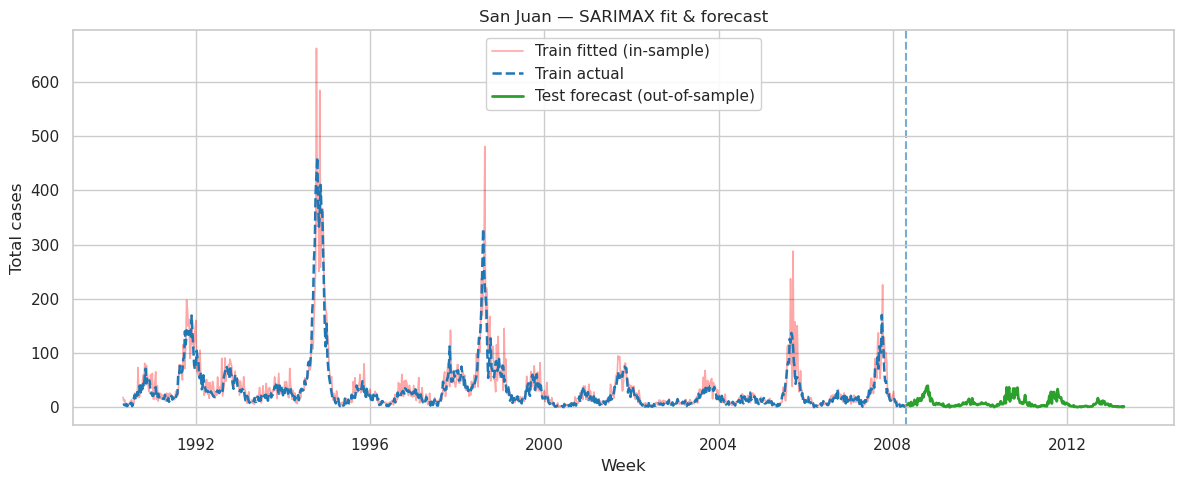

In [77]:
#----- plot: make train actuals stand out
plt.figure(figsize=(12, 5))
ax = plt.gca()

# draw fitted FIRST (faint) so it doesn't cover the actuals
ax.plot(train_dates, y_fitted,
        label="Train fitted (in-sample)",
        linewidth=1.2, alpha=0.35, color="red", zorder=1)

# draw actuals LAST (on top), darker & slightly thicker
ax.plot(train_dates, y_train_actual,
        label="Train actual", linestyle="--",
        linewidth=1.8, color="tab:blue", zorder=3)

# test forecasts
ax.plot(test_dates, y_pred,
        label="Test forecast (out-of-sample)",
        linewidth=2.0, color="tab:green", zorder=2)

# vertical split line
if len(train_dates) > 0:
    ax.axvline(train_dates.iloc[-1], linestyle="--", color="tab:blue", alpha=0.6, zorder=0)

ax.set_title("San Juan — SARIMAX fit & forecast")
ax.set_xlabel("Week")
ax.set_ylabel("Total cases")

# make legend readable
leg = ax.legend(frameon=True)
leg.get_frame().set_alpha(0.9)

plt.tight_layout()
plt.show()

**Step 6 — Metrics: MAE**

In [66]:
import numpy as np
from sklearn.metrics import mean_absolute_error

# ==== 1) In-sample MAE on training (optimistic) ====
# Uses the same y_fitted we built for the plot (bias-corrected inverse log if enabled)
mae_train = mean_absolute_error(y_train.values, y_fitted)
print(f"Train MAE (in-sample) for sj: {mae_train:.3f}")


Train MAE (in-sample) for sj: 13.124


<a id="iq-pipeline"></a>
### <span style="color:#1f77b4;">Iquitos: Pipeline + SARIMAX (AutoARIMA orders)</span>

**Step 1 — Slice IQ data & run early preprocessing (drop → impute)**

In [69]:
# --- IQ slices
iq_train = train_df[train_df.city == "iq"].copy()
iq_test  = feat_test [feat_test.city == "iq"].copy()

y_train_iq = iq_train["total_cases"].astype(float)
X_train_iq = iq_train.drop(columns=["total_cases"])
X_test_iq  = iq_test.copy()

# --- Stage A: early (city-specific drops + your time-series imputer)
early_iq = Pipeline([
    ("drop_early", ColumnDropper(drop_cols=config_dict_iq["features"]["drop_cols_early"])),
    ("impute_ts",  TimeSeriesImputer(**config_dict_iq["preprocess"]["ts_imputer"])),
])
X_train_iq_A = early_iq.fit_transform(X_train_iq, y_train_iq)
X_test_iq_A  = early_iq.transform(X_test_iq)


**Step 2 — Mid Feature Engineering (Fourier → anomaly → interactions → lags/rolling → late drop)**

In [70]:
fe_mid_iq = Pipeline([
    ("fourier",  FourierSeasonality(**config_dict_iq["features"]["fourier"])),
    ("anomaly",  AnomalyFeatureAdder(**config_dict_iq["features"]["anomaly"])),
    ("inter",    InteractionFeatures(**config_dict_iq["features"]["interaction"])),

    # Lags per IQ EDA (short: 1–2 weeks)
    ("lags_hum",  LagFeatureAdder(**config_dict_iq["features"]["lags"]["humidity"])),
    ("lags_tmin", LagFeatureAdder(**config_dict_iq["features"]["lags"]["temperature_min"])),

    # Rolling per IQ EDA (2–8 weeks)
    ("roll_temp", RollingFeatureAdder(**config_dict_iq["features"]["rolling"]["temperature"])),
    ("roll_hum",  RollingFeatureAdder(**config_dict_iq["features"]["rolling"]["humidity"])),

    # Late drop (redundant/highly correlated originals)
    ("drop_late", ColumnDropper(drop_cols=config_dict_iq["features"]["drop_cols_late_highcorr"])),

    # Keep numeric only for exog
    ("keep_num",  KeepNumeric()),
])

fe_mid_iq.fit(X_train_iq_A, y_train_iq)
X_train_iq_B = fe_mid_iq.transform(X_train_iq_A)
X_test_iq_B  = fe_mid_iq.transform(X_test_iq_A)


**Step 3 — Final NA patch (split-wise) & scale**

In [71]:
# Final small NA tidy-up
final_imp_iq = TimeSeriesImputer(**config_dict_iq["preprocess"]["final_imputer"])
X_train_iq_C = final_imp_iq.fit_transform(X_train_iq_B)
X_test_iq_C  = final_imp_iq.transform(X_test_iq_B)

# Scale to dense numpy (float32 keeps RAM low)
scaler_iq = PandasStandardScaler(**config_dict_iq["preprocess"]["scaler"])
X_train_exog_iq = scaler_iq.fit_transform(X_train_iq_C).to_numpy(dtype=np.float32)
X_test_exog_iq  = scaler_iq.transform(X_test_iq_C).to_numpy(dtype=np.float32)


**Step 4 — AutoARIMA (orders on *y* only, with p<sub>max</sub>=3), then fit one SARIMAX with exog**

In [72]:
from pmdarima import auto_arima
from pmdarima.arima import ARIMA
import numpy as np

tgt_iq = config_dict_iq.get("target", {"log1p": True, "bias_correction": True})
use_log = tgt_iq.get("log1p", True)
bias_corr = tgt_iq.get("bias_correction", True)

y_fit_iq = np.log1p(y_train_iq.values) if use_log else y_train_iq.values
m_iq = config_dict_iq["features"]["fourier"]["period"]  # 52

# Order search WITHOUT X (cheap) — per EDA, allow p up to 3
ord_sel_iq = auto_arima(
    y=y_fit_iq, X=None,
    seasonal=True, m=m_iq,
    d=0, D=0,                       # IQ usually near-stationary after our processing
    start_p=0, start_q=0, start_P=0, start_Q=0,
    max_p=3, max_q=3, max_P=1, max_Q=1,
    max_order=8,
    stepwise=True, simple_differencing=True,
    information_criterion="aic",
    error_action="ignore", suppress_warnings=True,
    trace=True, maxiter=75
)
order_iq, seas_iq = ord_sel_iq.order, ord_sel_iq.seasonal_order
print("IQ selected (p,d,q):", order_iq, " seasonal (P,D,Q,m):", seas_iq)

# Fit ONE SARIMAX with exog using the selected orders
arima_iq = ARIMA(order=order_iq, seasonal_order=seas_iq, with_intercept=True)
arima_iq = arima_iq.fit(y=y_fit_iq, X=X_train_exog_iq, maxiter=75)

# Forecast test horizon
y_fore_iq = arima_iq.predict(n_periods=len(X_test_exog_iq), X=X_test_exog_iq)

# Inverse transform + optional Jensen bias correction
try:
    y_in_iq = arima_iq.predict_in_sample(X=X_train_exog_iq) if use_log else None
    sigma2_iq = float(np.var(y_fit_iq - y_in_iq, ddof=1)) if (use_log and y_in_iq is not None) else 0.0
except Exception:
    sigma2_iq = 0.0

if use_log:
    bias_iq = 0.5 * sigma2_iq if (bias_corr and sigma2_iq > 0) else 0.0
    y_pred_iq = np.expm1(y_fore_iq + bias_iq)
else:
    y_pred_iq = y_fore_iq

submission_iq = iq_test[["city","year","weekofyear"]].copy()
submission_iq["total_cases"] = np.maximum(0, np.round(y_pred_iq)).astype(int)
submission_iq.head()


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[52] intercept   : AIC=1542.519, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[52] intercept   : AIC=945.795, Time=1.64 sec
 ARIMA(0,0,1)(0,0,1)[52] intercept   : AIC=1254.151, Time=1.43 sec
 ARIMA(0,0,0)(0,0,0)[52]             : AIC=2156.930, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[52] intercept   : AIC=947.646, Time=0.04 sec
 ARIMA(1,0,0)(1,0,1)[52] intercept   : AIC=inf, Time=4.49 sec
 ARIMA(1,0,0)(0,0,1)[52] intercept   : AIC=946.550, Time=1.65 sec
 ARIMA(0,0,0)(1,0,0)[52] intercept   : AIC=1543.771, Time=1.35 sec
 ARIMA(2,0,0)(1,0,0)[52] intercept   : AIC=897.107, Time=2.11 sec
 ARIMA(2,0,0)(0,0,0)[52] intercept   : AIC=903.445, Time=0.05 sec
 ARIMA(2,0,0)(1,0,1)[52] intercept   : AIC=inf, Time=5.20 sec
 ARIMA(2,0,0)(0,0,1)[52] intercept   : AIC=898.851, Time=2.07 sec
 ARIMA(3,0,0)(1,0,0)[52] intercept   : AIC=894.756, Time=9.37 sec
 ARIMA(3,0,0)(0,0,0)[52] intercept   : AIC=900.330, Time=0.09 sec
 ARIMA(3,0,0)(1,0,1)[52] intercept   

city  year  weekofyear  total_cases
260   iq  2010          26            4
261   iq  2010          27            5
262   iq  2010          28            5
263   iq  2010          29            0
264   iq  2010          30            2

**Step 5 — Plot: train actual vs. fitted, and test forecast**

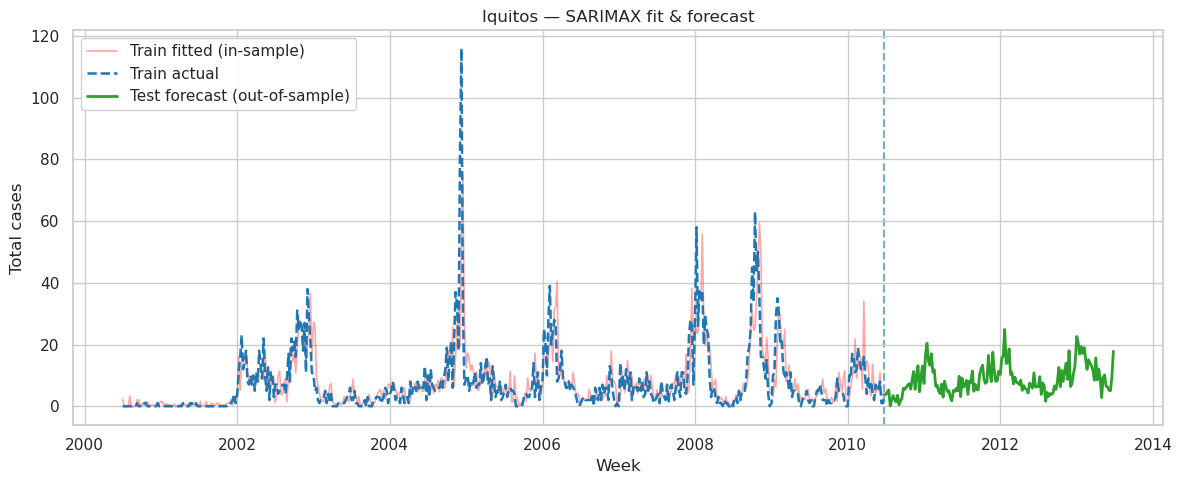

In [76]:
date_col = config_dict_iq["features"]["fourier"]["date_col"]
train_dates_iq = pd.to_datetime(iq_train[date_col])
test_dates_iq  = pd.to_datetime(iq_test[date_col])

# Build fitted series on original scale
y_fit_hat_iq = arima_iq.predict_in_sample(X=X_train_exog_iq)
if use_log:
    y_fitted_iq = np.expm1(y_fit_hat_iq + (0.5 * sigma2_iq if (bias_corr and sigma2_iq > 0) else 0.0))
else:
    y_fitted_iq = y_fit_hat_iq

plt.figure(figsize=(12, 5))
ax = plt.gca()

# plot fitted first (faint)
ax.plot(train_dates_iq, y_fitted_iq, label="Train fitted (in-sample)",
        linewidth=1.2, alpha=0.35, color="red", zorder=1)

# actuals on top
ax.plot(train_dates_iq, y_train_iq.values, label="Train actual", linestyle="--",
        linewidth=1.8, color="tab:blue", zorder=3)

# test forecast
ax.plot(test_dates_iq, y_pred_iq, label="Test forecast (out-of-sample)",
        linewidth=2.0, color="tab:green", zorder=2)

if len(train_dates_iq) > 0:
    ax.axvline(train_dates_iq.iloc[-1], linestyle="--", color="tab:blue", alpha=0.6, zorder=0)

ax.set_title("Iquitos — SARIMAX fit & forecast")
ax.set_xlabel("Week")
ax.set_ylabel("Total cases")
ax.legend(frameon=True).get_frame().set_alpha(0.9)
plt.tight_layout()
plt.show()


**Step 6 — Metrics: MAE**


In [79]:
mae_train_iq = mean_absolute_error(y_train_iq.values, y_fitted_iq)
print(f"Train MAE (in-sample) for iq: {mae_train_iq:.3f}")

Train MAE (in-sample) for iq: 3.906


**Combining submissions for competition**

In [83]:
# If you already built submission_sj and submission_iq earlier, combine them:
cols = ["city", "year", "weekofyear", "total_cases"]
preds = pd.concat(
    [submission_sj[cols].copy(), submission_iq[cols].copy()],
    axis=0, ignore_index=True
)

# Align to the original test order
final_submission = (
    feat_test[["city", "year", "weekofyear"]]
    .merge(preds, on=["city", "year", "weekofyear"], how="left")
)

# Basic checks & cleanup
final_submission["total_cases"] = (
    final_submission["total_cases"].fillna(0).clip(lower=0).round().astype(int)
)
assert len(final_submission) == len(feat_test), "Row count mismatch vs test_df"

# ---- Save to repo root's data/processed (one level up from notebooks/)
out_dir = Path.cwd().parent / "data" / "processed"
out_dir.mkdir(parents=True, exist_ok=True)

# Your preferred name
out_path_named = out_dir / "sarimax_two_models.csv"
final_submission.to_csv(out_path_named, index=False)

print("Saved:")
print(" -", out_path_named.resolve())



Saved:
 - /home/minealsan/Projects/dengue_case_counts/data/processed/sarimax_two_models.csv
